# Setup

### Import Statements

In [1764]:
import pandas as pd
import numpy as np

import string
import re
import datetime
import requests

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pickle

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

### Data Loading & Cleaning

In [1210]:
total_layoffs_by_month = pd.read_csv('data/monthly_layoffs.csv')
layoffs_raw = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/job_postings.csv')

In [1165]:
# Indeed Job Postings
# url: https://www.hiringlab.org/2022/06/09/data/

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [1153]:
# visually inspecting

display(total_layoffs_by_month.head())
display(layoffs_raw.head())
display(job_postings_national.head())

month  total_laid_off
0 2020-03-01          9628.0
1 2020-04-01         26710.0
2 2020-05-01         25804.0
3 2020-06-01          7627.0
4 2020-07-01          7112.0

company     location industry  total_laid_off  percentage_laid_off  \
0     me poupe    Sao Paulo  Finance            60.0                 0.50   
1  cointracker  SF Bay Area   Crypto            19.0                  NaN   
2       ssense     Montreal   Retail           138.0                 0.07   
3    dealshare    Bengaluru   Retail           100.0                 0.06   
4     synopsys  SF Bay Area    Other           100.0                  NaN   

        date     stage        country  funds_raised  year      month  
0 2023-01-28   Unknown         Brazil         148.0  2023 2023-01-01  
1 2023-01-28  Series A  United States         101.0  2023 2023-01-01  
2 2023-01-27  Series A         Canada         148.0  2023 2023-01-01  
3 2023-01-27  Series E          India         390.0  2023 2023-01-01  
4 2023-01-27       IPO  United States         148.0  2023 2023-01-01

Unnamed: 0  year  month  day_endofweek  bg_posts  bg_posts_ss30  \
0           0  2020      1             10   -0.0407        -0.0748   
1           1  2020      1             17    0.1180         0.0922   
2           2  2020      1             24   -0.0954        -0.0819   
3           3  2020      1             31    0.0183         0.0645   
4           4  2020      2              7   -0.0943        -0.1200   

   bg_posts_ss55  bg_posts_ss60  bg_posts_ss65  bg_posts_ss70  bg_posts_jz1  \
0        -0.0399         -0.104        -0.1020        0.00711        0.0629   
1         0.0660          0.170         0.2240        0.07930        0.0934   
2        -0.1020         -0.117        -0.1520       -0.02490       -0.0591   
3         0.0758          0.051         0.0292       -0.06150       -0.0973   
4        -0.0350         -0.121        -0.0890       -0.09110       -0.0294   

   bg_posts_jzgrp12  bg_posts_jz2  bg_posts_jz3  bg_posts_jzgrp345  \
0           -0.0013      -0.00683       -0.0723            -0.0646   
1            0.1120       0.11400        0.1730             0.1260   
2           -0.0570      -0.05680       -0.1170            -0.1150   
3           -0.0538      -0.05010        0.0168             0.0535   
4           -0.0901      -0.09540       -0.1030            -0.1000   

   bg_posts_jz4  bg_posts_jz5        date  
0       -0.0512       -0.0889  2020-01-10  
1        0.0656        0.2060  2020-01-17  
2       -0.0985       -0.1640  2020-01-24  
3        0.0841        0.0465  2020-01-31  
4       -0.0933       -0.1140  2020-02-07

In [1089]:
crunchbase = pd.read_csv('data/companies-csv-1-31-2023.csv')
crunchbase2 = pd.read_csv('data/companies-4-csv-1-31-2023.csv')

In [1090]:
crunchbase.head()

Organization Name                              Organization Name URL  \
0           Twitter    https://www.crunchbase.com/organization/twitter   
1         Microsoft  https://www.crunchbase.com/organization/microsoft   
2           Netflix    https://www.crunchbase.com/organization/netflix   
3         ConsenSys  https://www.crunchbase.com/organization/consen...   
4            Amazon     https://www.crunchbase.com/organization/amazon   

                                          Industries  \
0   Blogging Platforms, Messaging, SMS, Social Media   
1  Developer Tools, Enterprise Software, Operatin...   
2  Digital Entertainment, Media and Entertainment...   
3  Blockchain, Cryptocurrency, FinTech, Mobile, S...   
4        Crowdsourcing, Delivery, E-Commerce, Retail   

                      Headquarters Location  \
0  San Francisco, California, United States   
1        Redmond, Washington, United States   
2      Los Gatos, California, United States   
3         Brooklyn, New York, United States   
4        Seattle, Washington, United States   

                                         Description  \
0  Twitter is a social networking platform that a...   
1  Microsoft is a software corporation that devel...   
2  Netflix is an online streaming platform that e...   
3  ConsenSys builds Ethereum blockchain infrastru...   
4  Amazon is an e-commerce website for consumers,...   

                    Website Founded Date Founded Date Precision  \
0    http://www.twitter.com   2006-03-21                    day   
1  http://www.microsoft.com   1975-04-04                    day   
2   https://www.netflix.com   1997-01-01                    day   
3  http://www.consensys.net   2014-01-01                   year   
4         http://amazon.com   1994-07-05                    day   

                                     Industry Groups Number of Employees  ...  \
0  Content and Publishing, Information Technology...          5001-10000  ...   
1                                Platforms, Software              10001+  ...   
2  Content and Publishing, Media and Entertainmen...              10001+  ...   
3  Financial Services, Mobile, Other, Payments, S...            501-1000  ...   
4  Administrative Services, Commerce and Shopping...              10001+  ...   

  Number of Funding Rounds      Funding Status  Last Funding Date  \
0                     15.0                 IPO         2022-06-01   
1                      3.0                 IPO         2022-11-30   
2                     13.0                 IPO         2018-05-05   
3                      8.0  Late Stage Venture         2022-10-18   
4                      3.0                 IPO         2023-01-03   

   Last Funding Amount  Last Funding Amount Currency  \
0                  NaN                           NaN   
1         5.000000e+06                           USD   
2         2.666198e+06                           USD   
3         1.670000e+06                           USD   
4         8.000000e+09                           USD   

   Last Funding Amount Currency (in USD) Last Funding Type  \
0                                    NaN   Post-IPO Equity   
1                           5.000000e+06    Private Equity   
2                           2.666198e+06     Post-IPO Debt   
3                           1.670000e+06  Secondary Market   
4                           8.000000e+09     Post-IPO Debt   

   Total Funding Amount  Total Funding Amount Currency  \
0          1.286919e+10                            USD   
1          6.000000e+06                            USD   
2          1.219077e+11                            USD   
3          7.266700e+08                            USD   
4          8.108000e+09                            USD   

  Total Funding Amount Currency (in USD)  
0                           1.286919e+10  
1                           6.000000e+06  
2                           1.219077e+11  
3                           7.266700e+08  
4                    

In [1092]:
crunchbase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  954 non-null    object 
 1   Organization Name URL                              954 non-null    object 
 2   Industries                                         951 non-null    object 
 3   Headquarters Location                              952 non-null    object 
 4   Description                                        954 non-null    object 
 5   Website                                            953 non-null    object 
 6   Founded Date                                       946 non-null    object 
 7   Founded Date Precision                             946 non-null    object 
 8   Industry Groups                                    951 non-null    object 
 9   Number of 

In [1121]:
crunchbase[crunchbase['Organization Name']=='Ada']

Organization Name                              Organization Name URL  \
139               Ada  https://www.crunchbase.com/organization/ada-su...   

                                            Industries  \
139  Artificial Intelligence, Intelligent Systems, ...   

        Headquarters Location  \
139  Toronto, Ontario, Canada   

                                           Description              Website  \
139  Ada is an automated customer experience compan...  https://www.ada.cx/   

    Founded Date Founded Date Precision  \
139   2016-01-01                   year   

                                       Industry Groups Number of Employees  \
139  Artificial Intelligence, Data and Analytics, S...             101-250   

     ... Number of Funding Rounds      Funding Status  Last Funding Date  \
139  ...                      7.0  Late Stage Venture         2021-05-07   

     Last Funding Amount  Last Funding Amount Currency  \
139          130000000.0                           USD   

     Last Funding Amount Currency (in USD) Last Funding Type  \
139                            130000000.0          Series C   

     Total Funding Amount  Total Funding Amount Currency  \
139           190620620.0                            USD   

    Total Funding Amount Currency (in USD)  
139                            190620620.0  

[1 rows x 56 columns]

In [1476]:
cb_all = pd.concat([crunchbase, crunchbase2], ignore_index=True)
cb_all['Organization Name'] = [name.lower().strip() for name in cb_all['Organization Name']] 
cb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  1168 non-null   object 
 1   Organization Name URL                              1168 non-null   object 
 2   Industries                                         1163 non-null   object 
 3   Headquarters Location                              1166 non-null   object 
 4   Description                                        1168 non-null   object 
 5   Website                                            1167 non-null   object 
 6   Founded Date                                       1158 non-null   object 
 7   Founded Date Precision                             1158 non-null   object 
 8   Industry Groups                                    1163 non-null   object 
 9   Number o

In [1477]:
# to help with merging with layoffs_raw dataset
cb_all['Organization Name'][cb_all['Organization Name']=='ada'] = 'ada support'

In [1478]:
cb_all[cb_all['Organization Name']=='ada support'] 

Organization Name                              Organization Name URL  \
139       ada support  https://www.crunchbase.com/organization/ada-su...   

                                            Industries  \
139  Artificial Intelligence, Intelligent Systems, ...   

        Headquarters Location  \
139  Toronto, Ontario, Canada   

                                           Description              Website  \
139  Ada is an automated customer experience compan...  https://www.ada.cx/   

    Founded Date Founded Date Precision  \
139   2016-01-01                   year   

                                       Industry Groups Number of Employees  \
139  Artificial Intelligence, Data and Analytics, S...             101-250   

     ... Number of Funding Rounds      Funding Status  Last Funding Date  \
139  ...                      7.0  Late Stage Venture         2021-05-07   

     Last Funding Amount  Last Funding Amount Currency  \
139          130000000.0                           USD   

     Last Funding Amount Currency (in USD) Last Funding Type  \
139                            130000000.0          Series C   

     Total Funding Amount  Total Funding Amount Currency  \
139           190620620.0                            USD   

    Total Funding Amount Currency (in USD)  
139                            190620620.0  

[1 rows x 56 columns]

In [1479]:
layoffs_raw[layoffs_raw.company=='ada support']

company location industry  total_laid_off  percentage_laid_off  \
710   ada support  Toronto  Support            78.0                 0.16   
1741  ada support  Toronto  Support            36.0                 0.23   

           date     stage country  funds_raised  year  
710  2022-09-20  Series C  Canada         190.0  2022  
1741 2020-04-24  Series B  Canada          60.0  2020

In [1480]:
layoffs_raw['company'][layoffs_raw['company']=='ada'] = 'ada support'

In [1481]:
layoffs_raw[layoffs_raw.company=='ada']

Empty DataFrame
Columns: [company, location, industry, total_laid_off, percentage_laid_off, date, stage, country, funds_raised, year]
Index: []

In [1482]:
layoffs_raw['company'] = [name.lower().strip() for name in layoffs_raw['company']]
layoffs_all = layoffs_raw.merge(cb_all, left_on='company', right_on='Organization Name', how='left')
layoffs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2119
Data columns (total 66 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   company                                            2120 non-null   object        
 1   location                                           2120 non-null   object        
 2   industry                                           2120 non-null   object        
 3   total_laid_off                                     1464 non-null   float64       
 4   percentage_laid_off                                1427 non-null   float64       
 5   date                                               2120 non-null   datetime64[ns]
 6   stage                                              2120 non-null   object        
 7   country                                            2120 non-null   object        
 8   funds_raised      

In [1349]:
len(set(layoffs_all.company[layoffs_all['Organization Name'].isna()]))

596

In [1136]:
#set(layoffs_all.company[layoffs_all['Organization Name'].isna()])

In [ ]:
# ada = ada support
# canadian company customer service

In [1483]:
# dropping columns with too many nans

layoffs_fin = layoffs_all.drop(columns=['Aberdeen - Services Spend', 
                                        'Aberdeen - Services Spend Currency', 
                                        'Aberdeen - Services Spend Currency (in USD)', 
                                        'Last Layoff Mention Date', 
                                        'Apptopia - Number of Apps', 
                                        'Apptopia - Downloads Last 30 Days', 
                                        'Stock Symbol', 
                                        'Stock Symbol URL', 
                                        'Aberdeen - IT Spend', 
                                        'Aberdeen - IT Spend Currency', 
                                        'Aberdeen - IT Spend Currency (in USD)', 
                                        'Aberdeen - Software Spend', 
                                        'Aberdeen - Software Spend Currency', 
                                        'Aberdeen - Software Spend Currency (in USD)', 
                                        'Aberdeen - Communications Spend', 
                                        'Aberdeen - Communications Spend Currency', 
                                        'Aberdeen - Communications Spend Currency (in USD)', 
                                        'Organization Name URL', 
                                        'Description', 
                                        'Website', 
                                        'Acquisition Status'], 
                               axis=1)

In [1484]:
layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2119
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   company                                 2120 non-null   object        
 1   location                                2120 non-null   object        
 2   industry                                2120 non-null   object        
 3   total_laid_off                          1464 non-null   float64       
 4   percentage_laid_off                     1427 non-null   float64       
 5   date                                    2120 non-null   datetime64[ns]
 6   stage                                   2120 non-null   object        
 7   country                                 2120 non-null   object        
 8   funds_raised                            2120 non-null   float64       
 9   year                                    2120 non-nul

In [1485]:
layoffs_fin = layoffs_fin.dropna(subset = ['Organization Name']).reset_index(drop=True)
layoffs_fin.shape

(1471, 45)

In [1486]:
layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   company                                 1471 non-null   object        
 1   location                                1471 non-null   object        
 2   industry                                1471 non-null   object        
 3   total_laid_off                          1349 non-null   float64       
 4   percentage_laid_off                     1063 non-null   float64       
 5   date                                    1471 non-null   datetime64[ns]
 6   stage                                   1471 non-null   object        
 7   country                                 1471 non-null   object        
 8   funds_raised                            1471 non-null   float64       
 9   year                                    1471 non-nul

In [1487]:
layoffs_fin['Number of Acquisitions'] = layoffs_fin['Number of Acquisitions'].fillna(0)

In [1488]:
set(layoffs_fin['Number of Employees'])

{'1-10',
 '10001+',
 '1001-5000',
 '101-250',
 '11-50',
 '251-500',
 '5001-10000',
 '501-1000',
 '51-100',
 nan}

In [1489]:
layoffs_fin = layoffs_fin.dropna(subset = ['Number of Employees', 
                                           'Industries', 
                                           'Industry Groups', 
                                           'Operating Status']).reset_index(drop=True)

In [1490]:
employee_count = {'10001+': 10000,
                  '1001-5000': 3000, 
                  '101-250': 175, 
                  '11-50': 30, 
                  '251-500': 375,
                  '51-100': 75,
                  '1-10': 5,
                  '5001-10000': 7500,
                  '501-1000': 750
                 }
layoffs_fin['employee_count_est'] = [employee_count[ct] for ct in layoffs_fin['Number of Employees']]
set(layoffs_fin['employee_count_est'])

{5, 30, 75, 175, 375, 750, 3000, 7500, 10000}

In [1491]:
layoffs_fin['percentage_laid_off'][layoffs_fin['percentage_laid_off'].isna()] = \
layoffs_fin['total_laid_off'] / layoffs_fin['employee_count_est']

layoffs_fin['total_laid_off'][layoffs_fin['total_laid_off'].isna()] = \
layoffs_fin['percentage_laid_off'] * layoffs_fin['employee_count_est']

layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   company                                 1457 non-null   object        
 1   location                                1457 non-null   object        
 2   industry                                1457 non-null   object        
 3   total_laid_off                          1389 non-null   float64       
 4   percentage_laid_off                     1389 non-null   float64       
 5   date                                    1457 non-null   datetime64[ns]
 6   stage                                   1457 non-null   object        
 7   country                                 1457 non-null   object        
 8   funds_raised                            1457 non-null   float64       
 9   year                                    1457 non-nul

In [1774]:
df_classification_cb = layoffs_fin.merge(ff, on='company', how='left')

In [1775]:
df_classification_cb = df_classification_cb[['company',
                                             'date',
                                             'industry',
                                             'country',
                                             'Headquarters Location',
                                             'Headquarters Regions',
                                             'Operating Status',
                                             'total_laid_off', 
                                             'percentage_laid_off', 
                                             'stage',
                                             'Industries', 
                                             'Industry Groups',
                                             'Total Funding Amount Currency (in USD)', 
                                             'Estimated Revenue Range', 
                                             'Number of Funding Rounds', 
                                             'Trend Score (30 Days)',
                                             'Number of Employees', 
                                             'Number of Acquisitions',
                                             'year_fr',
                                             'funds_raised_fr',
                                             'Founded Date'
                                            ]]

In [1776]:
df_classification_cb['founded_year'] = [pd.to_datetime(day).year for day 
                                        in df_classification_cb['Founded Date']]

In [1777]:
df_classification_cb['Total Funding Amount Currency (in USD)'].\
    fillna(df_classification_cb['Total Funding Amount Currency (in USD)'].median(), 
           inplace=True)

In [1778]:
set(df_classification_cb['Estimated Revenue Range'])

{'$100M to $500M',
 '$10B+',
 '$10M to $50M',
 '$1B to $10B',
 '$1M to $10M',
 '$500M to $1B',
 '$50M to $100M',
 'Less than $1M',
 nan}

In [1542]:
sum(df_classification_cb['Estimated Revenue Range'].isna())

293

In [1779]:
rev_ranges = {
'$100M to $500M': 300000000,
'$10B+': 10000000000,
'$10M to $50M': 30000000,
'$1B to $10B': 5000000000,
'$1M to $10M': 5000000,
'$500M to $1B': 750000000,
'$50M to $100M': 75000000,
'Less than $1M': 500000
}

df_classification_cb['Estimated Revenue Range'].fillna('n/a', inplace=True)

df_classification_cb['rev_est'] = [rev_ranges[rev] if rev!= 'n/a' else np.nan 
                                   for rev in df_classification_cb['Estimated Revenue Range']]

df_classification_cb['rev_est'].fillna(df_classification_cb['rev_est'].median(), 
                                       inplace=True)

In [1780]:
df_classification_cb['total_laid_off'].\
fillna(df_classification_cb['total_laid_off'].median(), inplace=True)

df_classification_cb['percentage_laid_off'].\
fillna(df_classification_cb['percentage_laid_off'].median(), inplace=True)

df_classification_cb['Number of Funding Rounds'].\
fillna(df_classification_cb['Number of Funding Rounds'].median(), inplace=True)

In [1781]:
df_classification_cb = df_classification_cb.dropna(subset=['Founded Date']).reset_index(drop=True)

In [1580]:
df_classification_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   company                                 1455 non-null   object        
 1   date                                    1455 non-null   datetime64[ns]
 2   industry                                1455 non-null   object        
 3   Headquarters Location                   1455 non-null   object        
 4   Headquarters Regions                    1333 non-null   object        
 5   Operating Status                        1455 non-null   object        
 6   total_laid_off                          1455 non-null   float64       
 7   percentage_laid_off                     1455 non-null   float64       
 8   stage                                   1455 non-null   object        
 9   Industries                              1455 non-nul

## Helper Functions

In [87]:
#Plot rolling statistics
def check_stationarity(df, window, values):
    
    '''
    df includes index
    window is int (representing period of time)
    values are x values in df (1d array)
    '''
    
    moving_avg = df.rolling(window).mean() # 4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(values, autolag='AIC')

    # Extract and display test results
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
# mean and standard deviation increasing with time = not stationary

In [128]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [1052]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y, cat_columns):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]

    # continuous features
    X_train_cont = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object']).reset_index(drop=True)
    
    # categorical featurs
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Standard Scaler:
    scaler = StandardScaler() # instantiate Standard Scaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [972]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

# Time Series Forecasting - Job Postings

## Job Postings

In [1154]:
job_postings_national.head() # should get rid of first column (extra index)

Unnamed: 0  year  month  day_endofweek  bg_posts  bg_posts_ss30  \
0           0  2020      1             10   -0.0407        -0.0748   
1           1  2020      1             17    0.1180         0.0922   
2           2  2020      1             24   -0.0954        -0.0819   
3           3  2020      1             31    0.0183         0.0645   
4           4  2020      2              7   -0.0943        -0.1200   

   bg_posts_ss55  bg_posts_ss60  bg_posts_ss65  bg_posts_ss70  bg_posts_jz1  \
0        -0.0399         -0.104        -0.1020        0.00711        0.0629   
1         0.0660          0.170         0.2240        0.07930        0.0934   
2        -0.1020         -0.117        -0.1520       -0.02490       -0.0591   
3         0.0758          0.051         0.0292       -0.06150       -0.0973   
4        -0.0350         -0.121        -0.0890       -0.09110       -0.0294   

   bg_posts_jzgrp12  bg_posts_jz2  bg_posts_jz3  bg_posts_jzgrp345  \
0           -0.0013      -0.00683       -0.0723            -0.0646   
1            0.1120       0.11400        0.1730             0.1260   
2           -0.0570      -0.05680       -0.1170            -0.1150   
3           -0.0538      -0.05010        0.0168             0.0535   
4           -0.0901      -0.09540       -0.1030            -0.1000   

   bg_posts_jz4  bg_posts_jz5        date  
0       -0.0512       -0.0889  2020-01-10  
1        0.0656        0.2060  2020-01-17  
2       -0.0985       -0.1640  2020-01-24  
3        0.0841        0.0465  2020-01-31  
4       -0.0933       -0.1140  2020-02-07

In [1182]:
df = job_postings_national[['date', 'bg_posts']]
df.head()

date  bg_posts
0  2020-01-10   -0.0407
1  2020-01-17    0.1180
2  2020-01-24   -0.0954
3  2020-01-31    0.0183
4  2020-02-07   -0.0943

In [1183]:
df = job_postings_national[['date', 'bg_posts']]

# index needs to be DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
# weekly frequency, on Fridays 
#df = df['bg_posts'].resample('W-FRI').mean()
df = df.asfreq('W-FRI')
df.head()

bg_posts
date                
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943

#### Stationarity Check & Trend Visualization

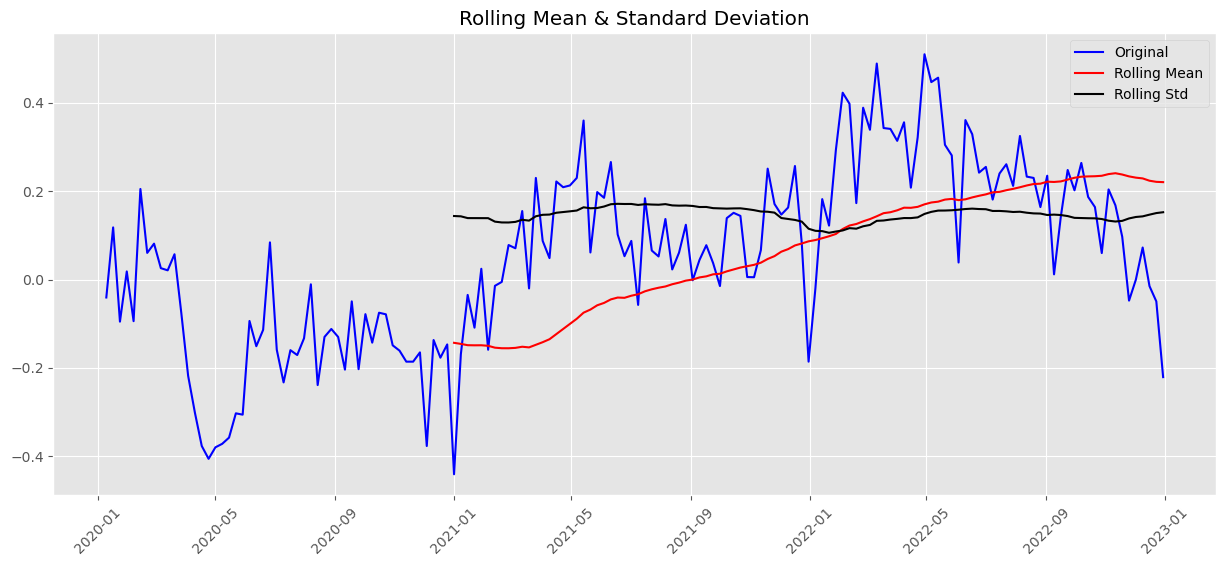

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [1184]:
# dickey fuller test to check stationarity - 52 week window

# the below plot and data does not show stationarity (p value > 0.05, 
# as well as clear upward trend in the rolling mean)

check_stationarity(df, 52, df['bg_posts'])

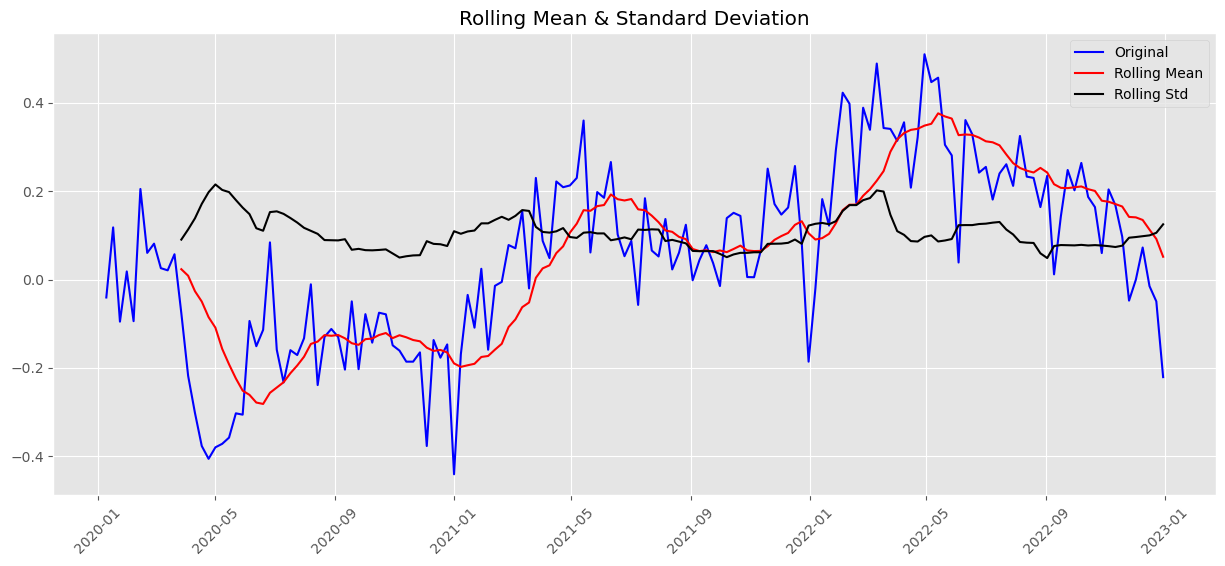

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [1185]:
# dickey Fuller test to check stationarity - 12 week window
check_stationarity(df, 12, df['bg_posts'])

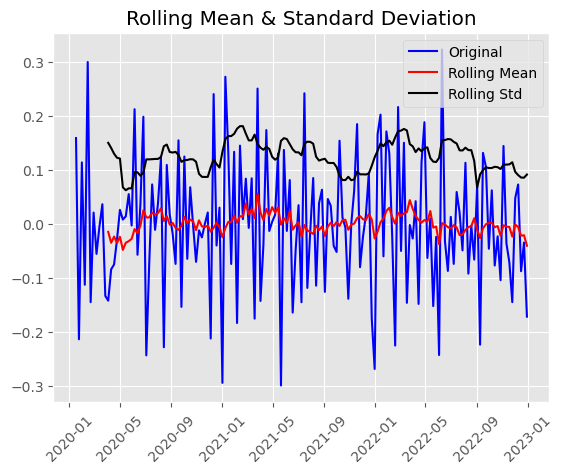

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [60]:
# this looks more stationary, implies one degree of differencing needed
# p value less than 0.05
check_stationarity(df.diff(), 12, df['bg_posts'].diff().dropna())

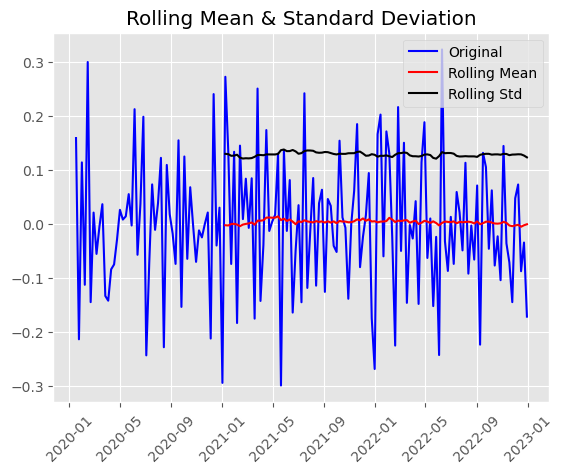

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [59]:
# this is the most stationary, implies one degree of differencing needed
# flat rolling mean and std, differenced data, 52 week period
check_stationarity(df.diff(), 52, df['bg_posts'].diff().dropna())

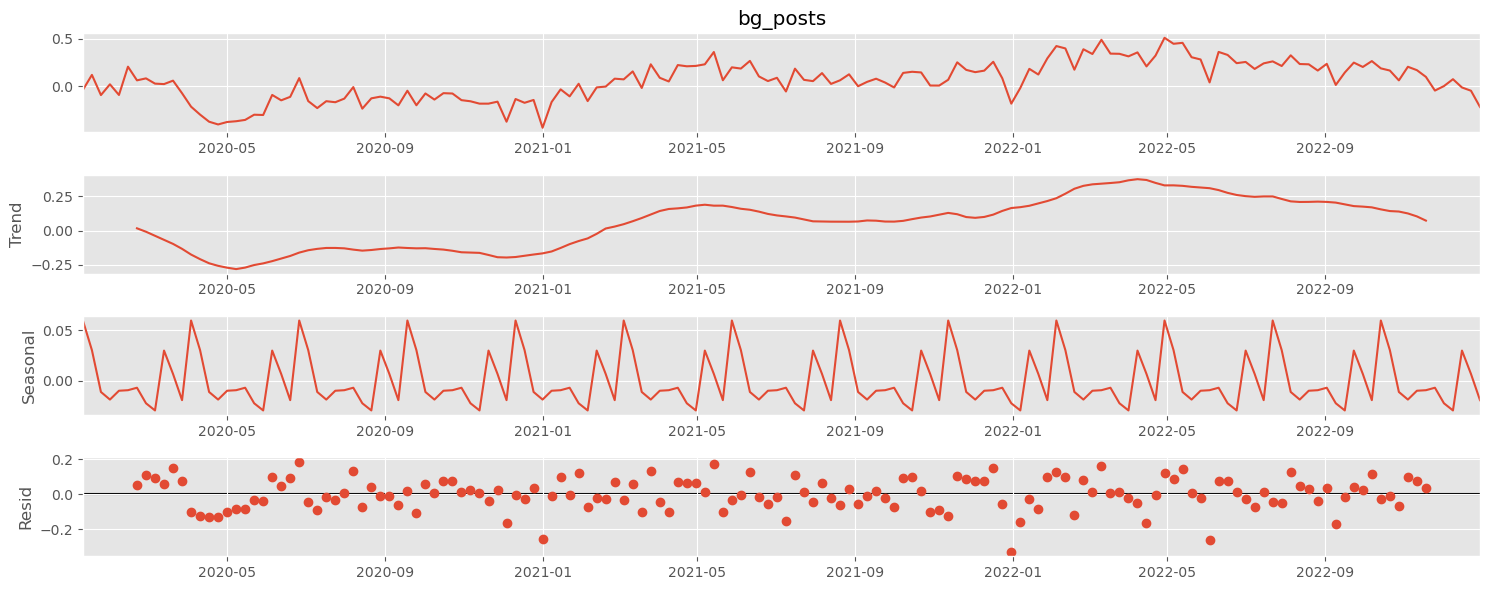

In [176]:
# with 12 period, see clear seasonal pattern and upward trend
# residuals look ok (evenly spread out)

sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

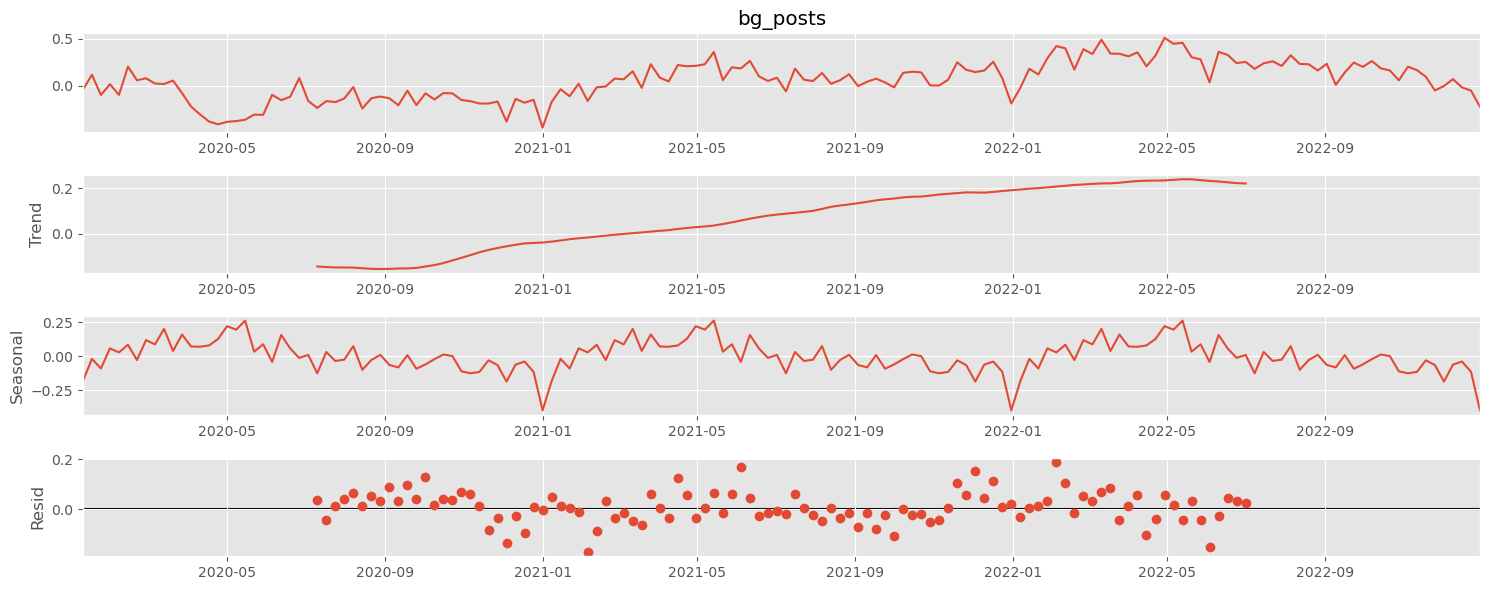

In [175]:
# upward trend even clearer with 52 week period
# 1y seasonality evident
# residuals look ok

sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

<AxesSubplot: xlabel='date'>

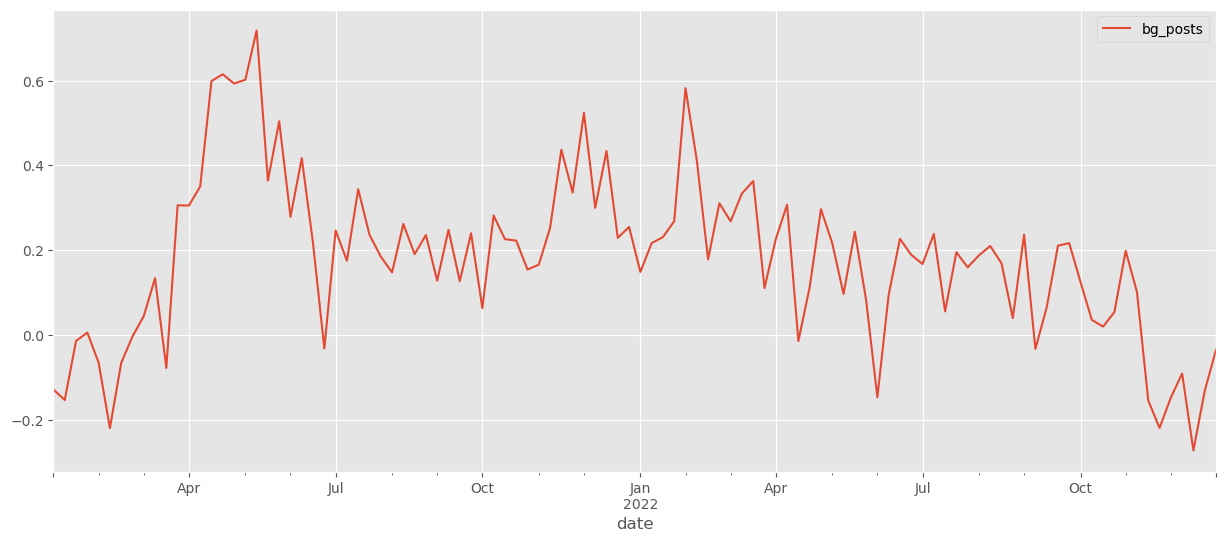

In [1187]:
# visualizing 52 week shift / differencing
diff = df.dropna()
df_s_adj = diff - diff.shift(52)
df_s_adj = df_s_adj.dropna()
df_s_adj.plot()

In [ ]:
# briefly looking at monthly data

In [1188]:
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

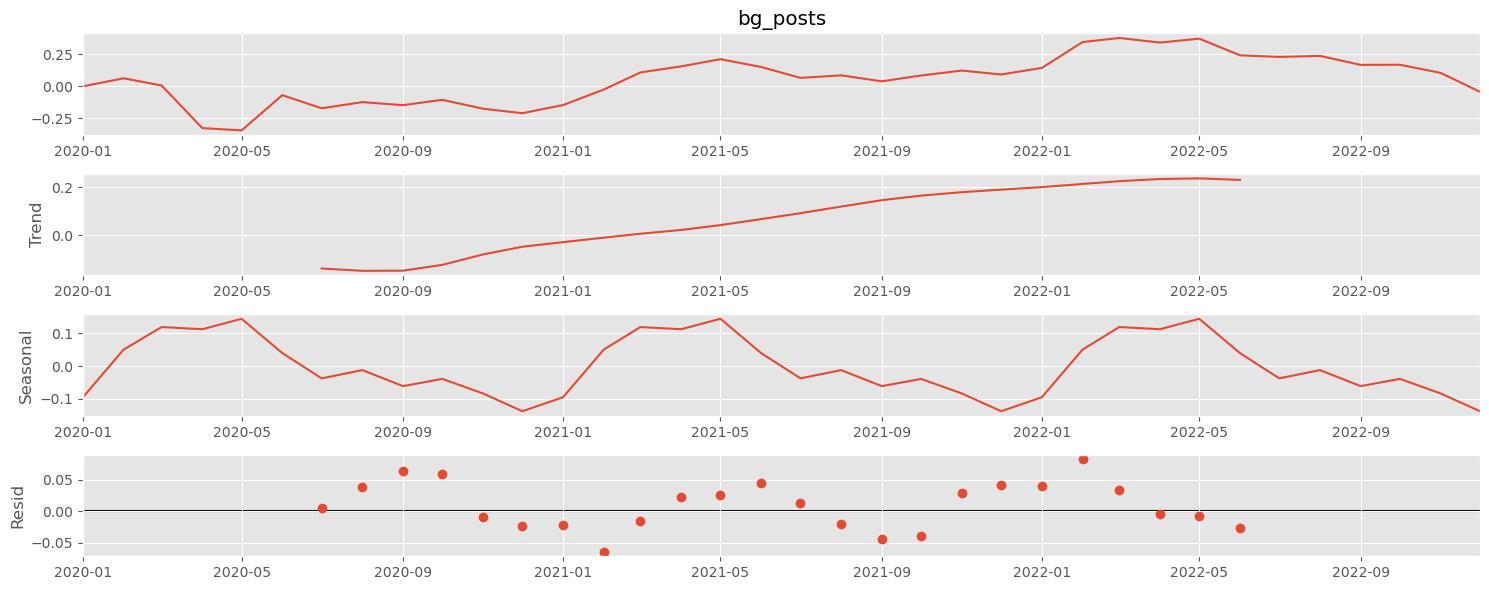

In [1189]:
# smoother, but obvious seasonality and trend
# residuals not evenly spread out
# will stick with weekly data

sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

#### Train Test Split

In [1190]:
df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [1191]:
df.head() # weekly data

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [1163]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

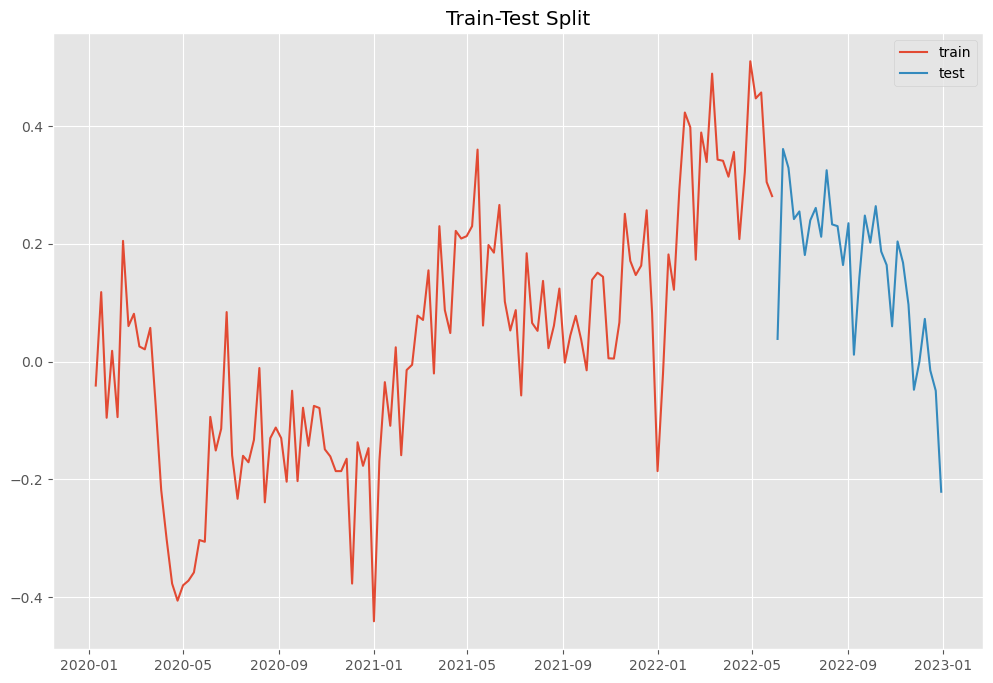

In [1164]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [1167]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [1168]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30336D-01    |proj g|=  2.21640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     14      1     0     0   2.216D-04  -1.303D-01
  F = -0.13033558207419485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-30.583895518548715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0      

 This problem is unconstrained.



At iterate    5    f= -1.33015D-01    |proj g|=  3.12541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   8.927D-07  -1.330D-01
  F = -0.13301524780163512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 1, 52): AIC Calculated=-29.25381195040878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74406D-01    |proj g|=  1.82074D+00

At iterate    5    f=  1.23460D-01    |proj g|=  1.42469D-06

  

 This problem is unconstrained.


ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=32.86494280730628
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03337D-01    |proj g|=  4.84881D+00


 This problem is unconstrained.



At iterate    5    f=  1.16355D-01    |proj g|=  2.48079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     14      1     0     0   8.355D-08   1.163D-01
  F =  0.11626760266719087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=33.06690066679772
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30228D-01    |proj g|=  2.92109D-01


 This problem is unconstrained.



At iterate    5    f= -1.31298D-01    |proj g|=  6.19560D-03

At iterate   10    f= -1.31303D-01    |proj g|=  2.25052D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   2.251D-06  -1.313D-01
  F = -0.13130324053554118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-28.825810133885298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30141D-01    |proj g|=  1.34109D-01


 This problem is unconstrained.



At iterate    5    f= -1.44815D-01    |proj g|=  3.40531D-01

At iterate   10    f= -1.47219D-01    |proj g|=  2.25087D-02

At iterate   15    f= -1.47880D-01    |proj g|=  5.18566D-02

At iterate   20    f= -1.47972D-01    |proj g|=  2.71440D-03

At iterate   25    f= -1.47984D-01    |proj g|=  4.89722D-04

At iterate   30    f= -1.47986D-01    |proj g|=  8.33466D-04

At iterate   35    f= -1.47986D-01    |proj g|=  1.57639D-05

At iterate   40    f= -1.47986D-01    |proj g|=  7.93839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     54      1     0     0   3.117D-04  -1.480D-01
  F = -0.147986012417

 This problem is unconstrained.



At iterate    5    f=  1.16346D-01    |proj g|=  1.87020D-02

At iterate   10    f=  1.16268D-01    |proj g|=  7.19295D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   7.193D-06   1.163D-01
  F =  0.11626760288683366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=33.066900721708414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03337D-01    |proj g|=  4.84881D+00


 This problem is unconstrained.



At iterate    5    f=  1.16291D-01    |proj g|=  2.29147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   3.596D-06   1.163D-01
  F =  0.11626760266454622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=35.066900666136554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40015D-01    |proj g|=  1.79239D+00

At iterate    5    f= -3.88258D-01    |proj g|=  1.11345D-02

  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40015D-01    |proj g|=  1.79239D+00


 This problem is unconstrained.



At iterate    5    f= -3.89186D-01    |proj g|=  2.17496D-01

At iterate   10    f= -3.90311D-01    |proj g|=  1.30881D-01

At iterate   15    f= -3.90847D-01    |proj g|=  1.56341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   9.576D-06  -3.908D-01
  F = -0.39084680253926263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-91.71170063481566
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -5.35136D-02    |proj g|=  2.05495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   2.758D-06  -5.351D-02
  F =  -5.3513713172915409E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-9.378428293228852
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56125D-01


 This problem is unconstrained.



At iterate    5    f= -5.44329D-02    |proj g|=  9.54541D-03

At iterate   10    f= -5.46754D-02    |proj g|=  3.43573D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   9.431D-05  -5.471D-02
  F =  -5.4705797098029953E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 1, 52): AIC Calculated=-7.676449274507489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.37491D-01    |proj g|=  1.77698D+00


 This problem is unconstrained.



At iterate    5    f= -3.85268D-01    |proj g|=  3.30323D-01

At iterate   10    f= -3.89754D-01    |proj g|=  1.20308D-02

At iterate   15    f= -3.89854D-01    |proj g|=  4.20405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.453D-04  -3.899D-01
  F = -0.38985395692083435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-91.4634892302086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -3.88789D-01    |proj g|=  2.65533D-01

At iterate   10    f= -3.90247D-01    |proj g|=  1.32019D-02

At iterate   15    f= -3.90586D-01    |proj g|=  1.18349D-01

At iterate   20    f= -3.98868D-01    |proj g|=  1.20439D-01

At iterate   25    f= -3.99340D-01    |proj g|=  7.95755D-03

At iterate   30    f= -3.99743D-01    |proj g|=  8.17264D-03

At iterate   35    f= -3.99800D-01    |proj g|=  2.64465D-03

At iterate   40    f= -3.99809D-01    |proj g|=  2.52549D-03

At iterate   45    f= -3.99811D-01    |proj g|=  5.34605D-04

At iterate   50    f= -3.99811D-01    |proj g|=  8.56163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.44938D-02    |proj g|=  8.56146D-03

At iterate   10    f= -5.47058D-02    |proj g|=  9.11228D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     27      1     0     0   2.532D-05  -5.471D-02
  F =  -5.4705797993758895E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 0, 52): AIC Calculated=-7.676449498439723
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56125D-01


 This problem is unconstrained.



At iterate    5    f= -5.47038D-02    |proj g|=  4.97766D-03

At iterate   10    f= -5.47058D-02    |proj g|=  1.26920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.362D-04  -5.471D-02
  F =  -5.4705798154296874E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-5.676449538574218
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44859D-01    |proj g|=  6.29484D-02

  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -6.66560D-01    |proj g|=  1.52468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   1.057D-05  -6.666D-01
  F = -0.66656043251987940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-162.64010812996986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10857D-01    |proj g|=  3.65066D+00

At iterate    5    f= -2.63981D-01    |proj g|=  1.31050D-02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8     50      2     0     0   1.439D-04  -2.640D-01
  F = -0.26398286122472014     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-63.99571530618003


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63954D-01    |proj g|=  1.00139D-01

At iterate    5    f= -2.93747D-01    |proj g|=  6.75805D-03

At iterate   10    f= -2.94773D-01    |proj g|=  4.37848D-02

At iterate   15    f= -2.94855D-01    |proj g|=  8.00789D-03

At iterate   20    f= -2.94856D-01    |proj g|=  3.13552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     35      1     0     0   5.133D-04  -2.949D-01
  F = -0.29485556922554235     

CONVERG

 This problem is unconstrained.



At iterate   10    f= -6.69359D-01    |proj g|=  1.36165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   8.382D-06  -6.694D-01
  F = -0.66935936534081886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-163.3398413352047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44857D-01    |proj g|=  1.70224D-01


 This problem is unconstrained.



At iterate    5    f= -6.67993D-01    |proj g|=  5.12058D-03

At iterate   10    f= -6.68072D-01    |proj g|=  1.29536D-01

At iterate   15    f= -6.71148D-01    |proj g|=  7.15503D-01

At iterate   20    f= -6.73081D-01    |proj g|=  3.96212D-02

At iterate   25    f= -6.73254D-01    |proj g|=  2.18503D-02

At iterate   30    f= -6.73310D-01    |proj g|=  3.48347D-03

At iterate   35    f= -6.73324D-01    |proj g|=  6.74429D-03

At iterate   40    f= -6.73328D-01    |proj g|=  7.65069D-03

At iterate   45    f= -6.73329D-01    |proj g|=  2.42255D-03

At iterate   50    f= -6.73331D-01    |proj g|=  8.01683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.94923D-01    |proj g|=  3.66430D-02

At iterate   10    f= -2.95175D-01    |proj g|=  1.61518D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     54      2     0     0   9.206D-05  -2.952D-01
  F = -0.29517554349103592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-69.79388587275898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63954D-01    |proj g|=  1.00139D-01


 This problem is unconstrained.



At iterate    5    f= -2.95171D-01    |proj g|=  2.40657D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     25      1     0     0   1.524D-04  -2.952D-01
  F = -0.29517554248406680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-67.7938856210167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57717D-01    |proj g|=  1.42385D-02

At iterate    5    f= -7.57904D-01    |proj g|=  8.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = tota

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57717D-01    |proj g|=  1.42992D-01

At iterate    5    f= -7.74405D-01    |proj g|=  1.50816D-02

At iterate   10    f= -7.74587D-01    |proj g|=  7.35226D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   6.206D-06  -7.746D-01
  F = -0.77461886036265948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-187.65471509066487
RU

 This problem is unconstrained.



At iterate    5    f= -3.26449D-01    |proj g|=  1.32073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     16      1     0     0   4.735D-05  -3.265D-01
  F = -0.32645041403857072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-77.61260350964268


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24111D-01    |proj g|=  1.30248D-01

At iterate    5    f= -3.46657D-01    |proj g|=  2.66647D-02

At iterate   10    f= -3.46994D-01    |proj g|=  2.55389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     20      1     0     0   2.500D-04  -3.470D-01
  F = -0.34699354507021429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-80.74838626755357
RUN

 This problem is unconstrained.



At iterate    5    f= -7.76417D-01    |proj g|=  4.26681D-02

At iterate   10    f= -7.76424D-01    |proj g|=  3.34241D-03

At iterate   15    f= -7.76425D-01    |proj g|=  8.39108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     39      1     0     0   8.391D-05  -7.764D-01
  F = -0.77642512665370422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-188.10628166342605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57717D-01    |proj g|=  1.42998D-01


 This problem is unconstrained.



At iterate    5    f= -7.75471D-01    |proj g|=  1.82058D-02

At iterate   10    f= -7.75623D-01    |proj g|=  4.22252D-02

At iterate   15    f= -7.75769D-01    |proj g|=  1.74822D-01

At iterate   20    f= -7.77058D-01    |proj g|=  2.23173D-02

At iterate   25    f= -7.77922D-01    |proj g|=  1.98930D-03

At iterate   30    f= -7.77924D-01    |proj g|=  1.17582D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     39      1     0     0   1.176D-03  -7.779D-01
  F = -0.77792374707797951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-18

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20322D-01    |proj g|=  1.27614D+00

At iterate    5    f= -3.38379D-01    |proj g|=  9.70643D-02

At iterate   10    f= -3.45768D-01    |proj g|=  1.90508D-01

At iterate   15    f= -3.46179D-01    |proj g|=  1.22109D-01

At iterate   20    f= -3.46993D-01    |proj g|=  2.25802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   3.726D-05  -3.470D-01
  F = -0.34699354430537643     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -3.46987D-01    |proj g|=  4.56359D-03

At iterate   10    f= -3.46994D-01    |proj g|=  7.82823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   7.828D-05  -3.470D-01
  F = -0.34699354396048920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-78.7483859901223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92135D-01    |proj g|=  6.44458D-02

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.12136D-01    |proj g|=  1.53269D-03

At iterate   10    f= -7.12148D-01    |proj g|=  2.21156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.106D-07  -7.121D-01
  F = -0.71214777834557186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-172.03694458639296
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  4.45639D-02


 This problem is unconstrained.



At iterate    5    f= -2.85037D-01    |proj g|=  1.65245D-02

At iterate   10    f= -2.85136D-01    |proj g|=  1.35182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   2.253D-04  -2.851D-01
  F = -0.28513637137917158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-67.2840928447929
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  8.72599D-02

At iterate    5    f= -3.06894D-01    |proj g|=  3.79687D-02

At iterate   10    f= -3.08569D-01    |proj g|=  1.93933D-02

At iterate   15    f= -3.08607D-01    |proj g|=  5.13028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   2.419D-03  -3.086D-01
  F = -0.30860802891999867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 52): AIC Calculated=-71.1

 This problem is unconstrained.



At iterate    5    f= -7.12912D-01    |proj g|=  9.80032D-03

At iterate   10    f= -7.13023D-01    |proj g|=  9.60482D-02

At iterate   15    f= -7.13087D-01    |proj g|=  4.30677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   4.307D-05  -7.131D-01
  F = -0.71308666274848842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-172.2716656871221
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92135D-01    |proj g|=  1.54473D-01

At iterate    5    f= -7.12642D-01    |proj g|=  3.64987D-03

At iterate   10    f= -7.12726D-01    |proj g|=  3.44037D-02

At iterate   15    f= -7.12797D-01    |proj g|=  1.62683D-02

At iterate   20    f= -7.13263D-01    |proj g|=  2.70686D-02

At iterate   25    f= -7.13321D-01    |proj g|=  3.55795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   3.752D-06  -7.133D-01
  F = -0.71332120758426

 This problem is unconstrained.



At iterate    5    f= -3.07454D-01    |proj g|=  6.33759D-02

At iterate   10    f= -3.08586D-01    |proj g|=  6.76008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   1.502D-05  -3.086D-01
  F = -0.30858614485992597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-71.1465362149815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  8.72599D-02


 This problem is unconstrained.



At iterate    5    f= -3.07188D-01    |proj g|=  1.05573D-02

At iterate   10    f= -3.08595D-01    |proj g|=  6.86444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   7.020D-04  -3.086D-01
  F = -0.30859545362504714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-69.14886340626178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.68321D-01    |proj g|=  1.17133D-01

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.86418D-01    |proj g|=  1.86704D-02

At iterate   10    f= -7.86515D-01    |proj g|=  9.93742D-02

At iterate   15    f= -7.86606D-01    |proj g|=  2.87944D-03

At iterate   20    f= -7.86680D-01    |proj g|=  6.71129D-02

At iterate   25    f= -7.87295D-01    |proj g|=  8.42771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.242D-06  -7.873D-01
  F = -0.78729529386661234     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-188.8238234666531
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -3.32183D-01    |proj g|=  7.99294D-02

At iterate   10    f= -3.32237D-01    |proj g|=  8.32623D-03

At iterate   15    f= -3.33008D-01    |proj g|=  1.20862D-01

At iterate   20    f= -3.33850D-01    |proj g|=  5.97677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     33      1     0     0   9.107D-05  -3.338D-01
  F = -0.33384964761890118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-77.4624119047253
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -3.51675D-01    |proj g|=  5.43403D-02

At iterate   10    f= -3.52001D-01    |proj g|=  5.81851D-03

At iterate   15    f= -3.52036D-01    |proj g|=  3.94023D-02

At iterate   20    f= -3.52058D-01    |proj g|=  1.84930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   4.605D-04  -3.521D-01
  F = -0.35205827234733517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-80.01456808683379
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-189.09640321619395
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -7.87294D-01    |proj g|=  1.37385D-02

At iterate   10    f= -7.87366D-01    |proj g|=  1.48198D-02

At iterate   15    f= -7.87830D-01    |proj g|=  3.48667D-01

At iterate   20    f= -7.88668D-01    |proj g|=  3.01477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   8.286D-05  -7.887D-01
  F = -0.78866847498427972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 52): AIC Calculated=-187.16711874606992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -3.51476D-01    |proj g|=  1.23941D-02

At iterate   10    f= -3.51636D-01    |proj g|=  6.81819D-04

At iterate   15    f= -3.51690D-01    |proj g|=  3.81245D-02

At iterate   20    f= -3.51791D-01    |proj g|=  1.32283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   5.022D-05  -3.518D-01
  F = -0.35179153762873683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-79.9478844071842
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

 This problem is unconstrained.



At iterate    5    f= -3.51676D-01    |proj g|=  1.00503D-02

At iterate   10    f= -3.51785D-01    |proj g|=  7.33189D-04

At iterate   15    f= -3.51869D-01    |proj g|=  8.11275D-03

At iterate   20    f= -3.52019D-01    |proj g|=  2.67442D-03

At iterate   25    f= -3.52028D-01    |proj g|=  1.76231D-02

At iterate   30    f= -3.52103D-01    |proj g|=  8.51360D-03

At iterate   35    f= -3.52141D-01    |proj g|=  3.50160D-03

At iterate   40    f= -3.52166D-01    |proj g|=  3.02022D-03

At iterate   45    f= -3.52169D-01    |proj g|=  2.34455D-03
  ys=-2.392E-06  -gs= 2.367E-06 BFGS update SKIPPED

At iterate   50    f= -3.52174D-01    |proj g|=  4.61304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.60515D-01    |proj g|=  1.39549D-03

At iterate   10    f= -7.60517D-01    |proj g|=  1.53331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.592D-06  -7.605D-01
  F = -0.76051674830497951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-184.12918707624488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  5.68706D-02


 This problem is unconstrained.



At iterate    5    f= -3.27219D-01    |proj g|=  1.53277D-02

At iterate   10    f= -3.27229D-01    |proj g|=  1.76129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   1.519D-04  -3.272D-01
  F = -0.32722856608956791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-77.80714152239197


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  9.39367D-02

At iterate    5    f= -3.49208D-01    |proj g|=  8.78380D-02

At iterate   10    f= -3.49620D-01    |proj g|=  5.76936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   5.914D-04  -3.496D-01
  F = -0.34962031977081359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-81.4050799427034
RUNN

 This problem is unconstrained.



At iterate    5    f= -7.62524D-01    |proj g|=  1.79418D-02

At iterate   10    f= -7.62545D-01    |proj g|=  1.27466D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -7.62545D-01    |proj g|=  5.67357D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     36      1     0     0   5.674D-05  -7.625D-01
  F = -0.76254473947490764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-184.6361848687269


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.39592D-01    |proj g|=  1.57855D-01

At iterate    5    f= -7.61586D-01    |proj g|=  2.01495D-02

At iterate   10    f= -7.61620D-01    |proj g|=  8.33552D-02

At iterate   15    f= -7.61920D-01    |proj g|=  4.08271D-02

At iterate   20    f= -7.62688D-01    |proj g|=  3.49247D-01

At iterate   25    f= -7.63426D-01    |proj g|=  5.50395D-02

At iterate   30    f= -7.63849D-01    |proj g|=  9.11927D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     76      2     0     0   4.872D-04  -7.639D-01
  F = -0.76385138681684017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-182.96284670421005



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27404D-01    |proj g|=  1.27671D+00

At iterate    5    f= -3.44603D-01    |proj g|=  3.83802D-02

At iterate   10    f= -3.48295D-01    |proj g|=  2.88582D-01

At iterate   15    f= -3.48984D-01    |proj g|=  9.13263D-02

At iterate   20    f= -3.49616D-01    |proj g|=  1.85618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   2.591D-04  -3.496D-01
  F = -0.34962031729657267     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -3.49505D-01    |proj g|=  9.18266D-03

At iterate   10    f= -3.49620D-01    |proj g|=  5.66780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   2.542D-05  -3.496D-01
  F = -0.34962032006439425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-79.40508001609857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  2.14193D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.74996D-01    |proj g|=  3.57280D-03

At iterate   10    f= -7.75084D-01    |proj g|=  1.33559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   1.361D-04  -7.751D-01
  F = -0.77508357708045983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-185.77089427011495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30651D-01    |proj g|=  1.50907D-01


 This problem is unconstrained.



At iterate    5    f= -3.30932D-01    |proj g|=  1.63576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   1.764D-04  -3.309D-01
  F = -0.33094223167091363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 52): AIC Calculated=-76.73555791772841
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30651D-01    |proj g|=  1.50907D-01


 This problem is unconstrained.



At iterate    5    f= -3.49924D-01    |proj g|=  3.44181D-02

At iterate   10    f= -3.50641D-01    |proj g|=  2.31730D-03

At iterate   15    f= -3.50754D-01    |proj g|=  5.36154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   6.709D-04  -3.508D-01
  F = -0.35075385446411550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-79.68846361602887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -7.76833D-01    |proj g|=  1.98415D-02

At iterate   10    f= -7.76892D-01    |proj g|=  2.54976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.493D-04  -7.769D-01
  F = -0.77689402531544982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-186.22350632886244
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  1.44600D-01

At iterate    5    f= -7.75744D-01    |proj g|=  7.51056D-02

At iterate   10    f= -7.75969D-01    |proj g|=  1.47421D-02

At iterate   15    f= -7.76193D-01    |proj g|=  1.68388D-01

At iterate   20    f= -7.76670D-01    |proj g|=  1.66596D-02

At iterate   25    f= -7.77985D-01    |proj g|=  8.56664D-02

At iterate   30    f= -7.78257D-01    |proj g|=  1.13165D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     53      1     0     0   4.388D-04  -7.783D-01
  F = -0.77825761844443275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 52): AIC Calculated=-184.5644046111082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25949D-01    |proj g|=  1.29360D+00


 This problem is unconstrained.



At iterate    5    f= -3.44157D-01    |proj g|=  8.01833D-02

At iterate   10    f= -3.48222D-01    |proj g|=  2.38777D-02

At iterate   15    f= -3.50235D-01    |proj g|=  2.33432D-01

At iterate   20    f= -3.50654D-01    |proj g|=  5.34981D-03

At iterate   25    f= -3.50754D-01    |proj g|=  7.82013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   1.814D-04  -3.508D-01
  F = -0.35075385714502216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-79.68846428625554
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -3.50502D-01    |proj g|=  6.46962D-02

At iterate   10    f= -3.50586D-01    |proj g|=  1.79659D-02

At iterate   15    f= -3.50734D-01    |proj g|=  2.75049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   7.048D-05  -3.508D-01
  F = -0.35075385363412520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-77.6884634085313


In [1169]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [1170]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [1172]:
# Fit the model and print results
print(sari_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  98.548
Date:                             Tue, 31 Jan 2023   AIC                           -189.096
Time:                                     03:45:07   BIC                           -177.783
Sample:                                 01-10-2020   HQIC                          -184.500
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.031     30.506      0.000       0.892       1.015
ma.L1         -0.4428      

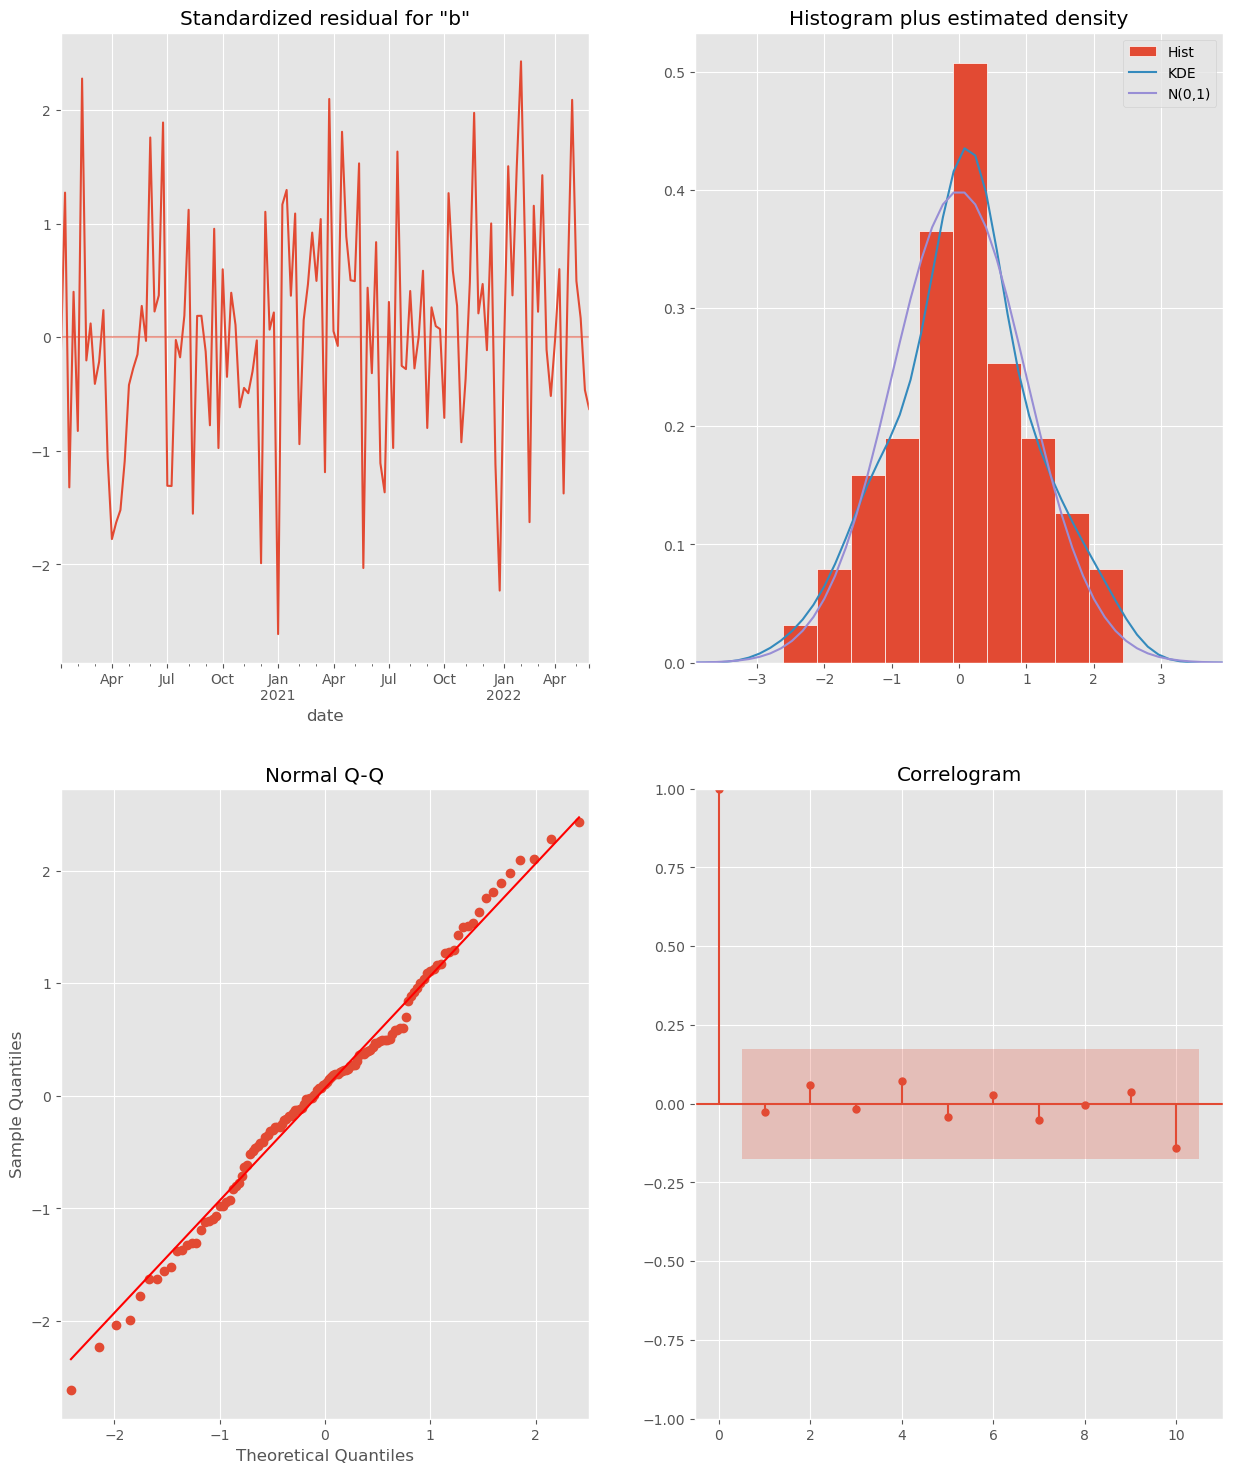

<Figure size 1500x600 with 0 Axes>

In [1198]:
sari_mod.plot_diagnostics(figsize=(15, 18))
plt.show()
plt.savefig('images/timeseries_diagnostics.png')

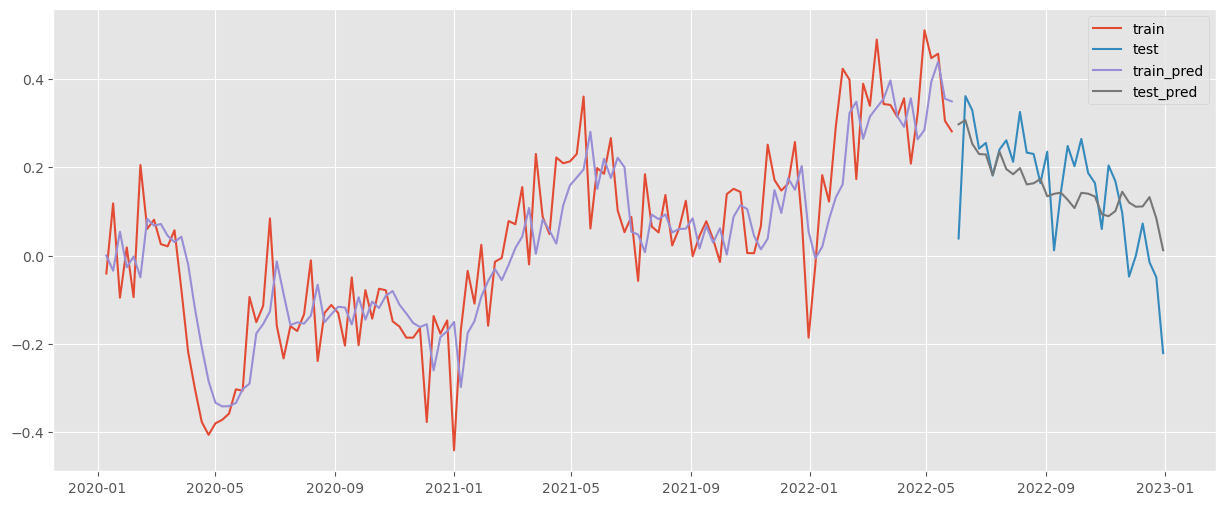

In [1197]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1], 
                              typ='levels', dynamic=True)

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend()

plt.savefig('images/timeseries_validation.png');

In [1179]:
print("MSE, train: ", str(np.sqrt(mean_squared_error(train, y_hat_train))))

error = np.sqrt(mean_squared_error(test, y_hat_test))
print("MSE, test: ", str(error))

MSE, train:  0.10948173385866404
MSE, test:  0.10358723013923056


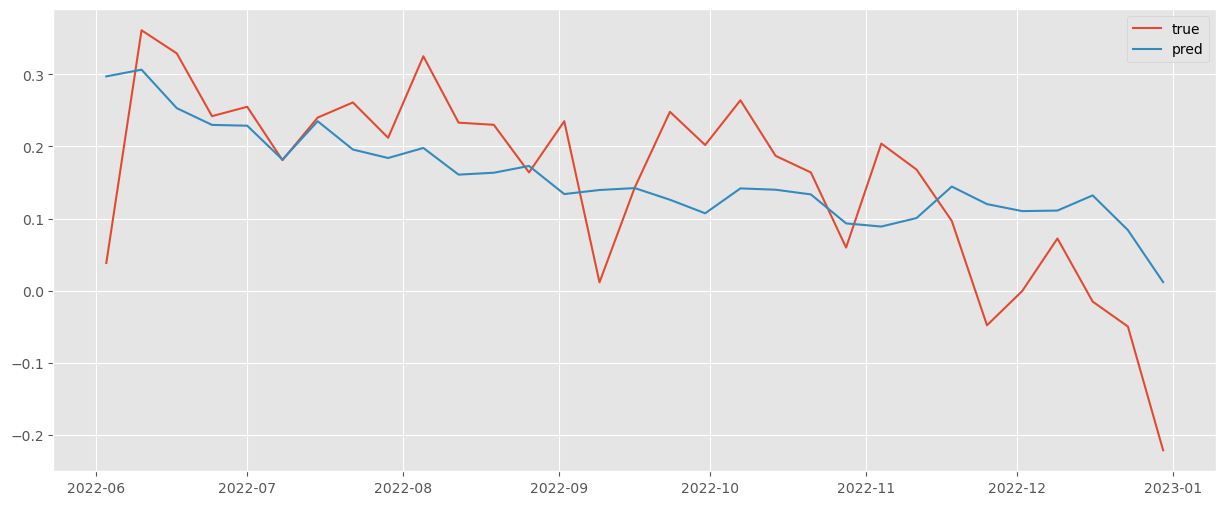

In [1177]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

#### Forecast

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01

At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

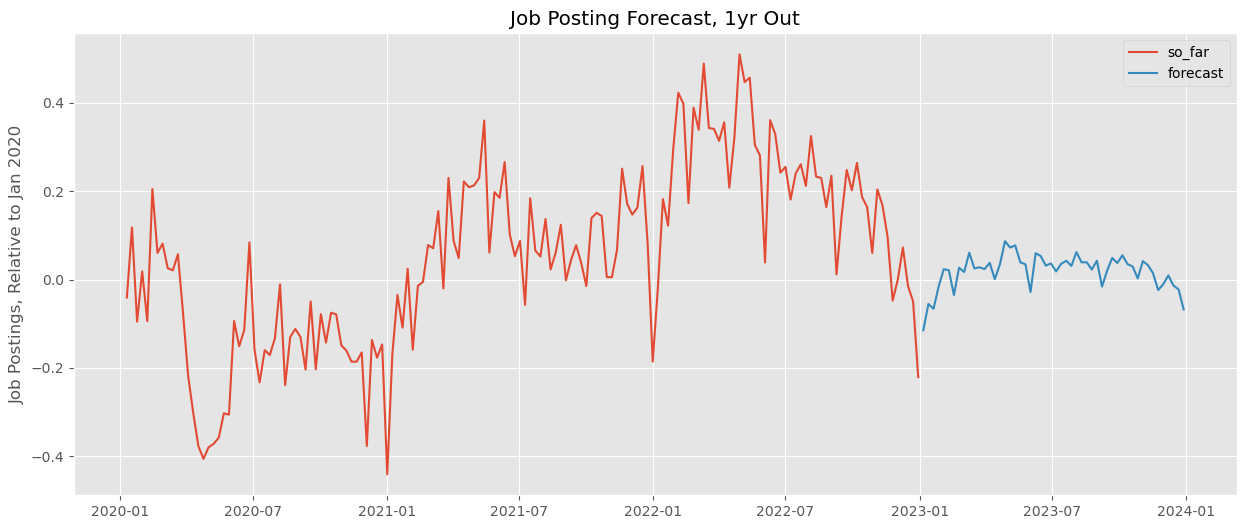

In [1192]:
# Forecast

# running model on full series
sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order).fit()

forecast = sari_mod_final.forecast(steps=52, dynamic=True)


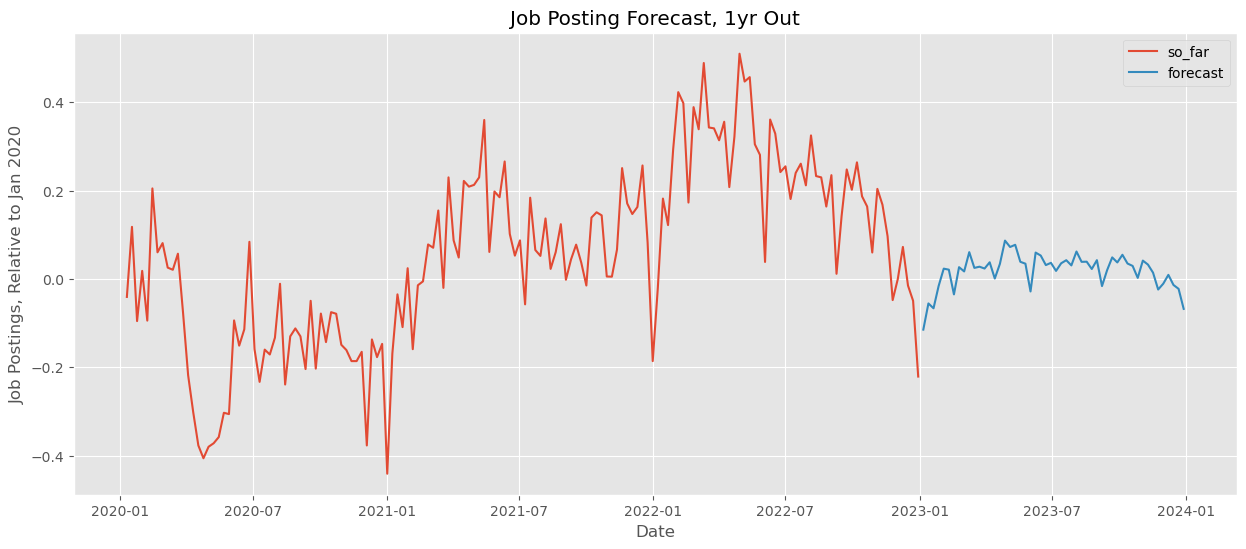

In [1196]:
fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings, Relative to Jan 2020')

plt.legend()

plt.savefig('images/job_forecast.png');

In [1204]:
# storing preds in dataframe
forecast_df = pd.DataFrame(forecast).reset_index()
forecast_df.columns = ['date', 'prediction']
forecast_df.to_csv('data/jobs_forecast.csv')

In [1206]:
forecast_df

date  prediction
0  2023-01-06   -0.114719
1  2023-01-13   -0.055429
2  2023-01-20   -0.066422
3  2023-01-27   -0.015941
4  2023-02-03    0.023354
5  2023-02-10    0.021015
6  2023-02-17   -0.034971
7  2023-02-24    0.026671
8  2023-03-03    0.017052
9  2023-03-10    0.060688
10 2023-03-17    0.025067
11 2023-03-24    0.027755
12 2023-03-31    0.023608
13 2023-04-07    0.037748
14 2023-04-14    0.000983
15 2023-04-21    0.034084
16 2023-04-28    0.086829
17 2023-05-05    0.072389
18 2023-05-12    0.077338
19 2023-05-19    0.038894
20 2023-05-26    0.034543
21 2023-06-02   -0.028286
22 2023-06-09    0.059747
23 2023-06-16    0.052974
24 2023-06-23    0.031420
25 2023-06-30    0.036503
26 2023-07-07    0.018262
27 2023-07-14    0.035483
28 2023-07-21    0.042480
29 2023-07-28    0.030708
30 2023-08-04    0.062155
31 2023-08-11    0.038769
32 2023-08-18    0.039104
33 2023-08-25    0.022552
34 2023-09-01    0.042551
35 2023-09-08   -0.016131
36 2023-09-15    0.019882
37 2023-09-22    0.048823
38 2023-09-29    0.037377
39 2023-10-06    0.054746
40 2023-10-13    0.034937
41 2023-10-20    0.029519
42 2023-10-27    0.002398
43 2023-11-03    0.041557
44 2023-11-10    0.032566
45 2023-11-17    0.014166
46 2023-11-24   -0.023928
47 2023-12-01   -0.010705
48 2023-12-08    0.009268
49 2023-12-15   -0.013621
50 2023-12-22   -0.022374
51 2023-12-29   -0.067753

<AxesSubplot: >

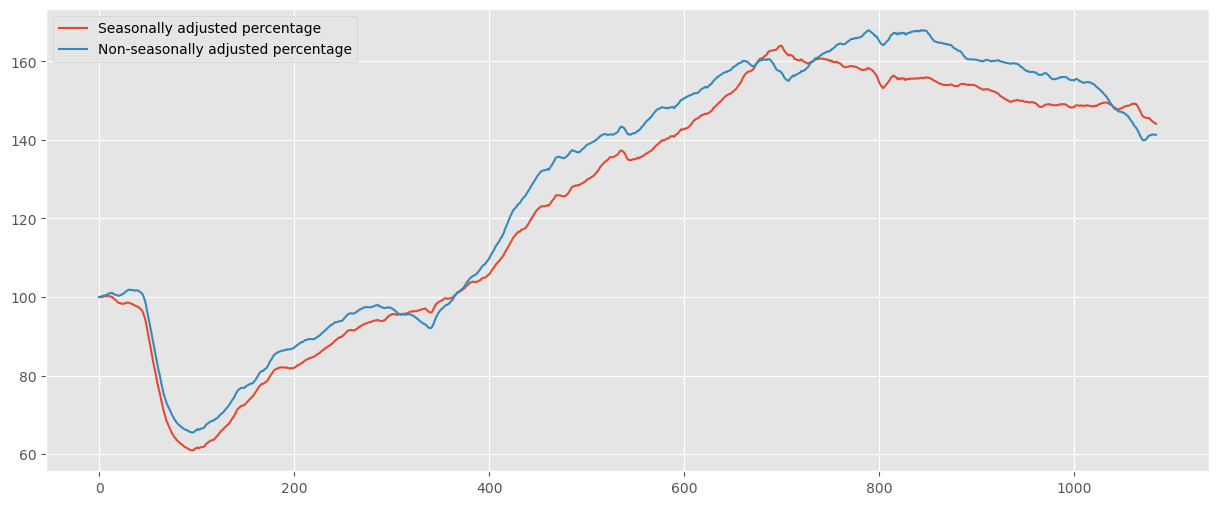

In [1166]:
# indeed

indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

#### Facebook Prophet Model - To Be Continued

In [408]:
from prophet import Prophet

In [565]:
df_prophet = job_postings_national[['date', 'bg_posts']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [566]:
Model = Prophet(interval_width=0.95)
Model.fit(df_prophet)

17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing


In [567]:
future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
future_dates.tail()

ds
203 2023-11-25
204 2023-12-02
205 2023-12-09
206 2023-12-16
207 2023-12-23

In [568]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-01-10 -0.208884   -0.552839   -0.074961    -0.208884    -0.208884   
1 2020-01-17 -0.205506   -0.388145    0.061553    -0.205506    -0.205506   
2 2020-01-24 -0.202128   -0.311618    0.149671    -0.202128    -0.202128   
3 2020-01-31 -0.198749   -0.289169    0.154841    -0.198749    -0.198749   
4 2020-02-07 -0.195371   -0.323479    0.156889    -0.195371    -0.195371   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.097315             -0.097315             -0.097315 -0.097315   
1        0.039271              0.039271              0.039271  0.039271   
2        0.119544              0.119544              0.119544  0.119544   
3        0.126872              0.126872              0.126872  0.126872   
4        0.108079              0.108079              0.108079  0.108079   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.097315     -0.097315                   0.0   
1      0.039271      0.039271                   0.0   
2      0.119544      0.119544                   0.0   
3      0.126872      0.126872                   0.0   
4      0.108079      0.108079                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0 -0.306200  
1                         0.0                         0.0 -0.166235  
2                         0.0                         0.0 -0.082583  
3                         0.0                         0.0 -0.071877  
4                         0.0                         0.0 -0.087291

In [569]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
203 2023-11-25  0.343216    0.098608    0.588175
204 2023-12-02  0.360484    0.121522    0.600604
205 2023-12-09  0.361987    0.127966    0.602158
206 2023-12-16  0.320453    0.080495    0.552397
207 2023-12-23  0.259500    0.007886    0.499737

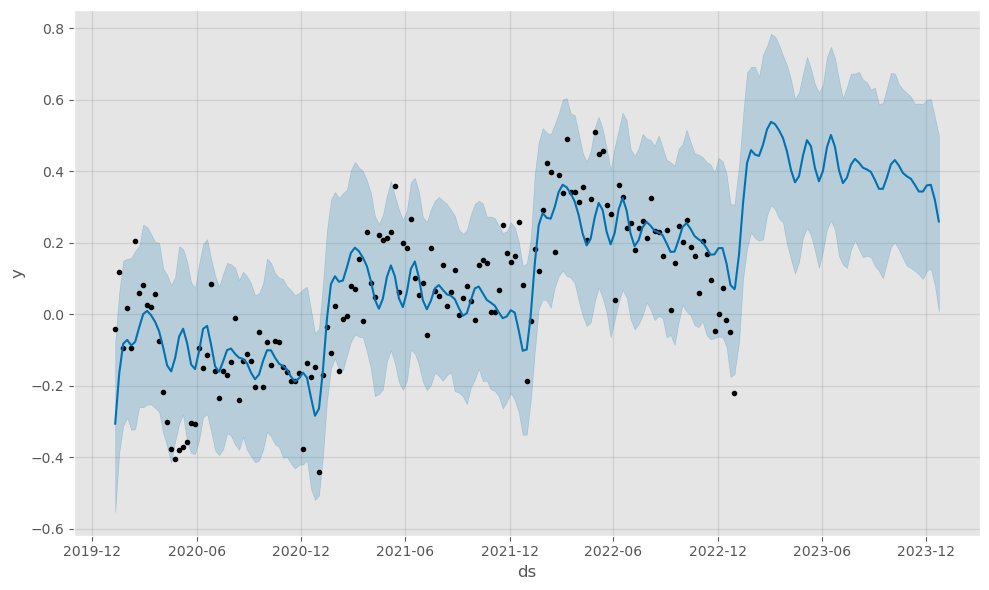

In [570]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

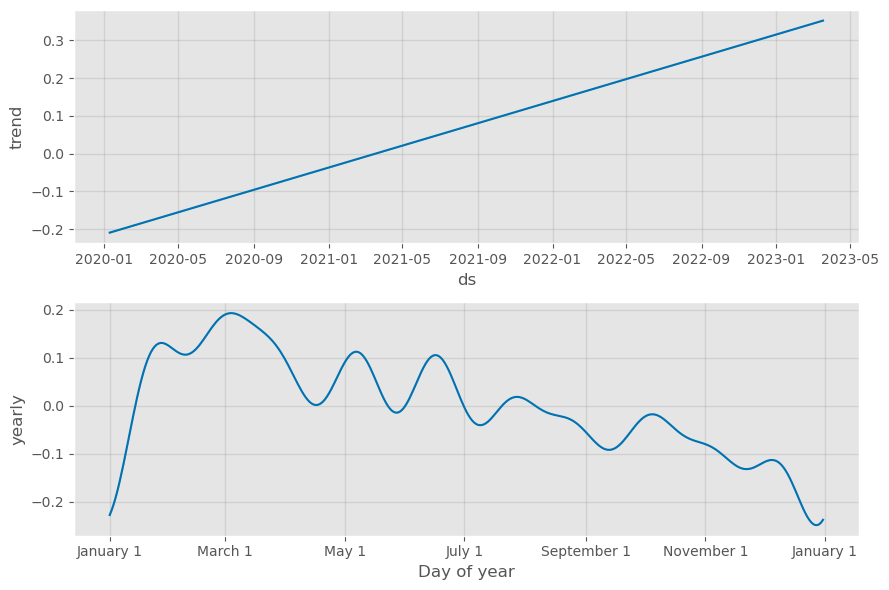

In [416]:
# Plot model components 
Model.plot_components(forecast)
plt.show()

### Regression

In [760]:
job_postings_national.head()

Unnamed: 0  year  month  day_endofweek  bg_posts  bg_posts_ss30  \
0           0  2020      1             10   -0.0407        -0.0748   
1           1  2020      1             17    0.1180         0.0922   
2           2  2020      1             24   -0.0954        -0.0819   
3           3  2020      1             31    0.0183         0.0645   
4           4  2020      2              7   -0.0943        -0.1200   

   bg_posts_ss55  bg_posts_ss60  bg_posts_ss65  bg_posts_ss70  bg_posts_jz1  \
0        -0.0399         -0.104        -0.1020        0.00711        0.0629   
1         0.0660          0.170         0.2240        0.07930        0.0934   
2        -0.1020         -0.117        -0.1520       -0.02490       -0.0591   
3         0.0758          0.051         0.0292       -0.06150       -0.0973   
4        -0.0350         -0.121        -0.0890       -0.09110       -0.0294   

   bg_posts_jzgrp12  bg_posts_jz2  bg_posts_jz3  bg_posts_jzgrp345  \
0           -0.0013      -0.00683       -0.0723            -0.0646   
1            0.1120       0.11400        0.1730             0.1260   
2           -0.0570      -0.05680       -0.1170            -0.1150   
3           -0.0538      -0.05010        0.0168             0.0535   
4           -0.0901      -0.09540       -0.1030            -0.1000   

   bg_posts_jz4  bg_posts_jz5        date  
0       -0.0512       -0.0889  2020-01-10  
1        0.0656        0.2060  2020-01-17  
2       -0.0985       -0.1640  2020-01-24  
3        0.0841        0.0465  2020-01-31  
4       -0.0933       -0.1140  2020-02-07

In [761]:
job_postings_national.shape

(156, 18)

In [762]:
indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [763]:
indeed_jobs.head()

Unnamed: 0        Date        Country  \
0           1  2020-02-01  United States   
1           2  2020-02-02  United States   
2           3  2020-02-03  United States   
3           4  2020-02-04  United States   
4           5  2020-02-05  United States   

                                     Index Type  \
0  Indeed Job Postings Index, Feb 01 2020 = 100   
1  Indeed Job Postings Index, Feb 01 2020 = 100   
2  Indeed Job Postings Index, Feb 01 2020 = 100   
3  Indeed Job Postings Index, Feb 01 2020 = 100   
4  Indeed Job Postings Index, Feb 01 2020 = 100   

   Seasonally adjusted percentage  Non-seasonally adjusted percentage  
0                           100.0                               100.0  
1                           100.0                               100.1  
2                           100.0                               100.1  
3                           100.0                               100.2  
4                           100.1                               100.3

In [773]:
indeed_sectors.head()

Unnamed: 0        Date jobcountry                     Sector  \
0           1  2020-02-01  Australia                 Accounting   
1           2  2020-02-01  Australia  Administrative Assistance   
2           3  2020-02-01  Australia   Agriculture and Forestry   
3           4  2020-02-01  Australia               Architecture   
4           5  2020-02-01  Australia     Arts and Entertainment   

                                     Index Type  \
0  Indeed Job Postings Index, Feb 01 2020 = 100   
1  Indeed Job Postings Index, Feb 01 2020 = 100   
2  Indeed Job Postings Index, Feb 01 2020 = 100   
3  Indeed Job Postings Index, Feb 01 2020 = 100   
4  Indeed Job Postings Index, Feb 01 2020 = 100   

   Seasonally adjusted percentage  Non-seasonally adjusted percentage  
0                           100.0                               100.0  
1                           100.0                               100.0  
2                           100.0                               100.0  
3                           100.0                               100.0  
4                           100.0                               100.0

In [774]:
set(indeed_sectors['Sector'])

{'Accounting',
 'Accounting (会計)',
 'Administrative Assistance',
 'Administrative Assistance (事務)',
 'Agriculture and Forestry',
 'Agriculture and Forestry (農業)',
 'Architecture',
 'Architecture (建築)',
 'Arts and Entertainment',
 'Arts and Entertainment (アート・エンターテインメント)',
 'Banking and Finance',
 'Beauty and Wellness',
 'Beauty and Wellness (美容・健康)',
 'Childcare',
 'Childcare (保育)',
 'Civil Engineering',
 'Cleaning and Sanitation',
 'Cleaning and Sanitation (クリーニング・清掃)',
 'Community and Social Service',
 'Construction',
 'Construction (建設)',
 'Customer Service',
 'Customer Service (カスタマーサービス)',
 'Dental',
 'Dental (歯科)',
 'Driving',
 'Driving (ドライバー)',
 'Education and Instruction',
 'Education and Instruction (教育)',
 'Electrical Engineering',
 'Food Preparation and Service',
 'Food Preparation and Service (飲食)',
 'Hospitality and Tourism',
 'Hospitality and Tourism (ホスピタリティ・観光)',
 'Human Resources',
 'Human Resources (人事)',
 'IT Operations and Helpdesk',
 'Industrial Engineering',
 'In

In [780]:
soft_dev_US = indeed_sectors[(indeed_sectors['Sector']=='Software Development') & 
                             (indeed_sectors['jobcountry']=='United States') & 
                             (indeed_sectors['Index Type']=='Indeed Job Postings Index, Feb 01 2020 = 100')]

In [788]:
soft_dev_US.iloc[:, 1:]

Date     jobcountry                Sector  \
127     2020-02-01  United States  Software Development   
428     2020-02-02  United States  Software Development   
729     2020-02-03  United States  Software Development   
1030    2020-02-04  United States  Software Development   
1331    2020-02-05  United States  Software Development   
...            ...            ...                   ...   
857328  2023-01-16  United States  Software Development   
858231  2023-01-17  United States  Software Development   
859134  2023-01-18  United States  Software Development   
860037  2023-01-19  United States  Software Development   
860940  2023-01-20  United States  Software Development   

                                          Index Type  \
127     Indeed Job Postings Index, Feb 01 2020 = 100   
428     Indeed Job Postings Index, Feb 01 2020 = 100   
729     Indeed Job Postings Index, Feb 01 2020 = 100   
1030    Indeed Job Postings Index, Feb 01 2020 = 100   
1331    Indeed Job Postings Index, Feb 01 2020 = 100   
...                                              ...   
857328  Indeed Job Postings Index, Feb 01 2020 = 100   
858231  Indeed Job Postings Index, Feb 01 2020 = 100   
859134  Indeed Job Postings Index, Feb 01 2020 = 100   
860037  Indeed Job Postings Index, Feb 01 2020 = 100   
860940  Indeed Job Postings Index, Feb 01 2020 = 100   

        Seasonally adjusted percentage  Non-seasonally adjusted percentage  
127                              100.0                               100.0  
428                               99.8                                99.9  
729                               99.5                                99.9  
1030                              99.3                                99.8  
1331                              99.2                                99.9  
...                                ...                                 ...  
857328                           132.2                               127.2  
858231                           132.2                               127.1  
859134                           132.2                               126.9  
860037                           132.1                               126.9  
860940                           131.7                               126.6  

[1085 rows x 6 columns]

In [768]:
print(indeed_jobs.shape)
indeed_jobs.info()

(1085, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1085 non-null   int64  
 1   Date                                1085 non-null   object 
 2   Country                             1085 non-null   object 
 3   Index Type                          1085 non-null   object 
 4   Seasonally adjusted percentage      1085 non-null   float64
 5   Non-seasonally adjusted percentage  1085 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 51.0+ KB


In [782]:
jobs_reg = soft_dev_US[['Date', 'Non-seasonally adjusted percentage']]
jobs_reg.columns = ['date', 'postings_pct']
jobs_reg['date'] = pd.to_datetime(jobs_reg['date'])
jobs_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 127 to 860940
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1085 non-null   datetime64[ns]
 1   postings_pct  1085 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.4 KB


In [801]:
jobs_reg_all = jobs_reg.merge(tech_stocks, on='date', how='left')
jobs_reg_all['close_px'] = jobs_reg_all['close_px'].ffill()
jobs_reg_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1085 non-null   datetime64[ns]
 1   postings_pct  1085 non-null   float64       
 2   close_px      1083 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 33.9 KB


In [790]:
sum(jobs_reg_all['date'].duplicated())

0

In [784]:
fig = px.scatter(x=jobs_reg_all['close_px'], 
                 y=jobs_reg_all['postings_pct'], 
                 trendline='ols')
fig.show()

In [798]:
ex = jobs_reg_all.dropna()
np.corrcoef(ex['close_px'], ex['postings_pct'])
#jobs_reg_all.dropna()

array([[1.        , 0.67226304],
       [0.67226304, 1.        ]])

In [802]:
ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083 entries, 2 to 1084
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1083 non-null   datetime64[ns]
 1   postings_pct  1083 non-null   float64       
 2   close_px      1083 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 33.8 KB


In [805]:
fig = px.line(ex, x='date', y = 'close_px')
fig.show()

# Supervised Models

When you are modeling for prediction, you are asking the question "How well can I use X (independent variables or features) to predict Y (dependent or target or outcome variable)?" Thus, in this case, you are less concerned about how and which features impact Y as opposed to how you can efficiently use them to predict Y.

When modeling for prediction, you typically use all available features (and most likely engineer new features) because you are trying to accurately predict Y, at all costs. As a result, you are less concerned about the coefficients of these features and instead focus on the overall accuracy of the model.

target = layoffs 
inputs:
- sector
- econ data
- job postings by sector?
- business openings?
- some measure of revenues

Regression for each sector?

Classification - given one layoff, prob of second?

### Data Prep

In [839]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2047 non-null   object 
 1   location             2047 non-null   object 
 2   industry             2046 non-null   object 
 3   total_laid_off       1414 non-null   float64
 4   percentage_laid_off  1377 non-null   float64
 5   date                 2047 non-null   object 
 6   stage                2041 non-null   object 
 7   country              2047 non-null   object 
 8   funds_raised         1890 non-null   float64
dtypes: float64(3), object(6)
memory usage: 144.1+ KB


In [1011]:
layoffs_raw.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         657
percentage_laid_off    690
date                     0
stage                    6
country                  0
funds_raised           171
dtype: int64

In [1215]:
# converting to numeric type
layoffs_raw['funds_raised'] = pd.to_numeric(layoffs_raw['funds_raised'], 
                                            errors='coerce')

In [1216]:
# replacing missing value of funds raised with median
layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median(), 
                                   inplace=True)

In [1217]:
# converting to datetime, adding column for year
layoffs_raw['date'] = pd.to_datetime(layoffs_raw['date'])
layoffs_raw['year'] = [day.year for day in layoffs_raw['date']]

In [1218]:
# getting rid of nans (very few for this subset)
layoffs_raw = layoffs_raw.dropna(subset=['industry', 'stage']).reset_index(drop=True)

In [1219]:
# checking for duplicates
layoffs_raw[layoffs_raw.duplicated()]

company     location        industry  total_laid_off  \
482   science 37  Los Angeles      Healthcare            90.0   
1245       cazoo       London  Transportation           750.0   

      percentage_laid_off       date stage         country  funds_raised  year  
482                   NaN 2022-11-14   IPO   United States         347.0  2022  
1245                 0.15 2022-06-07   IPO  United Kingdom        2000.0  2022

In [1223]:
# after some research, it appears there were indeed two rounds of layoffs
# for Cazoo
layoffs_raw[layoffs_raw.company=='cazoo']

company location        industry  total_laid_off  percentage_laid_off  \
96     cazoo   London  Transportation             NaN                  NaN   
1244   cazoo   London  Transportation           750.0                 0.15   
1245   cazoo   London  Transportation           750.0                 0.15   

           date stage         country  funds_raised  year  
96   2023-01-18   IPO  United Kingdom        2000.0  2023  
1244 2022-06-07   IPO  United Kingdom        2000.0  2022  
1245 2022-06-07   IPO  United Kingdom        2000.0  2022

In [1224]:
# second round of layoffs were on 9/8/2022
# source: https://sifted.eu/articles/cazoo-layoffs-european-union/ 

layoffs_raw.iloc[1245]['date'] = '2022-09-08' # adding correct value

In [1440]:
# list of companies that had more than one round of layoffs
mult_layoffs = list(layoffs_raw.company.value_counts()[layoffs_raw.company.value_counts() > 1].index)

In [1452]:
len(mult_layoffs)

293

In [1425]:
data_classification = layoffs_raw.drop(['total_laid_off', 'percentage_laid_off', 
                                        'date', 'year'], axis=1)

grouped = data_classification.groupby(by=['company', 'location', 'industry', 
                                          'stage', 'country']).sum().reset_index()

In [1428]:
data_classification['multiple'] = [True if co in mult_layoffs else False 
                                   for co in data_classification.company]
data_classification.tail()

company        location        industry     stage        country  \
2098        service     Los Angeles          Travel      Seed  United States   
2099   hopskipdrive     Los Angeles  Transportation   Unknown  United States   
2100    panda squad     SF Bay Area        Consumer      Seed  United States   
2101  tamara mellon     Los Angeles          Retail  Series C  United States   
2102       easypost  Salt Lake City       Logistics  Series A  United States   

      funds_raised  multiple  
2098           5.1      True  
2099          45.0      True  
2100           1.0     False  
2101          90.0     False  
2102          12.0      True

In [1087]:
#layoffs_raw[layoffs_raw.date>'22-01-2023'].to_csv('extra_cos.csv')

### Classification

In [1242]:
layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')
# funds raised in first round of layoffs and
#year of first layoffs

ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
ff['year_fr'] = [day.year for day in ff.date]
ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

ff[ff.company=='uber']

company  funds_raised_fr    date_fr  year_fr
1676    uber          24700.0 2020-05-06     2020

In [1244]:
layoffs_sorted[layoffs_sorted.company=='uber']

company  funds_raised       date
1676    uber       24700.0 2020-05-06
1631    uber       24700.0 2020-05-18
1612    uber       24700.0 2020-05-26
1580    uber       24700.0 2020-06-12
758     uber       24700.0 2022-09-07

In [1245]:
ff # can reset index if needed

company  funds_raised_fr    date_fr  year_fr
2102       easypost             12.0 2020-03-11     2020
2101  tamara mellon             90.0 2020-03-12     2020
2099   hopskipdrive             45.0 2020-03-13     2020
2100    panda squad              1.0 2020-03-13     2020
2097       help.com              6.0 2020-03-16     2020
...             ...              ...        ...      ...
4          synopsys            148.0 2023-01-27     2023
3         dealshare            390.0 2023-01-27     2023
2            ssense            148.0 2023-01-27     2023
1       cointracker            101.0 2023-01-28     2023
0          me poupe            148.0 2023-01-28     2023

[1710 rows x 4 columns]

In [1246]:
funds = data_classification[['company', 'funds_raised']].groupby(by='company').sum().reset_index()
display(funds.head())

company  funds_raised
0         #paid          21.0
1         &open          35.0
2   100 thieves         240.0
3  10x genomics         242.0
4       1stdibs         253.0

In [1247]:
# data_classification['multiple'] = [True if co in mult_layoffs else False 
#                                    for co in data_classification.company]

In [1449]:
layoffs_occurrance = data_classification[['company', 'multiple']].groupby(by='company').sum().reset_index()
layoffs_occurrance['multiple'] = [1 if val > 0 else 0 for val in layoffs_occurrance['multiple']]
layoffs_occurrance

company  multiple
0            #paid         0
1            &open         0
2      100 thieves         1
3     10x genomics         0
4          1stdibs         0
...            ...       ...
1704        zumper         0
1705         zuora         0
1706         zwift         1
1707      zymergen         1
1708        zywave         0

[1709 rows x 2 columns]

In [1249]:
df1 = pd.pivot_table(data_classification, 
                     index=['company', 'location', 'stage', 'industry', 'country'], 
                     values='funds_raised', aggfunc=np.sum).reset_index()

# still need to deal with duplicated companies = drop one, add value to sum
# then do multiple count column

df1 = df1.sort_values(by='stage').reset_index(drop=True)
df1

company      location     stage    industry         country  \
0                zywave     Milwaukee  Acquired     Finance   United States   
1               quandoo        Berlin  Acquired        Food         Germany   
2           booking.com  Grand Rapids  Acquired      Travel   United States   
3             glassdoor   SF Bay Area  Acquired  Recruiting   United States   
4     buy.com / rakuten   SF Bay Area  Acquired      Retail   United States   
...                 ...           ...       ...         ...             ...   
1825           cart.com        Austin   Unknown      Retail   United States   
1826         streetbees        London   Unknown        Data  United Kingdom   
1827           nextroll   SF Bay Area   Unknown   Marketing   United States   
1828        futurelearn        London   Unknown   Education  United Kingdom   
1829        techadvance         Lagos   Unknown     Finance         Nigeria   

      funds_raised  
0            148.0  
1             39.0  
2            148.0  
3            204.0  
4             42.4  
...            ...  
1825         383.0  
1826          63.0  
1827         216.0  
1828          50.0  
1829           1.0  

[1830 rows x 6 columns]

In [1250]:
# duplicated companies
dup = df1[df1.duplicated(subset='company')]

In [ ]:
# checking that index location is same in dup and df1

In [1251]:
dup[dup.company=='ebanx']

company  location    stage industry country  funds_raised
1705   ebanx  Curitiba  Unknown  Finance  Brazil          30.0

In [1252]:
df1[df1.company=='ebanx']

company  location     stage industry country  funds_raised
847    ebanx  Curitiba  Series B  Finance  Brazil         460.0
1705   ebanx  Curitiba   Unknown  Finance  Brazil          30.0

In [1253]:
# dropping duplicated where stage is Unknown
df1 = df1.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

In [1254]:
df1.tail(11)

company     location    stage    industry         country  \
1792            bitfront  SF Bay Area  Unknown      Crypto   United States   
1793           frontdesk    Milwaukee  Unknown      Travel   United States   
1794           freetrade       London  Unknown     Finance  United Kingdom   
1795               sumup    Sao Paulo  Unknown     Finance          Brazil   
1796           summerbio  SF Bay Area  Unknown  Healthcare   United States   
1797  newfront insurance  SF Bay Area  Unknown     Finance   United States   
1798            cart.com       Austin  Unknown      Retail   United States   
1799          streetbees       London  Unknown        Data  United Kingdom   
1800            nextroll  SF Bay Area  Unknown   Marketing   United States   
1801         futurelearn       London  Unknown   Education  United Kingdom   
1802         techadvance        Lagos  Unknown     Finance         Nigeria   

      funds_raised  
1792         148.0  
1793           3.0  
1794         133.0  
1795          50.0  
1796           7.0  
1797         148.0  
1798         383.0  
1799          63.0  
1800         216.0  
1801          50.0  
1802           1.0

In [1255]:
# dropping all duplicates, resetting funds_raised to sum of funds
# raised during all layoffs per company, retagging target 

df_final = df1.drop_duplicates(subset='company', keep='last').reset_index(drop=True)
df_final['funds_raised'] = [float(funds['funds_raised'][funds['company']==co]) 
                            for co in df_final['company']]
df_final['multiple'] = [int(layoffs_occurance['multiple'][layoffs_occurance['company']==co]) 
                        for co in df_final['company']]

In [1263]:
sum(df_final.company.duplicated())

0

In [1257]:
# adding in data on first round of funding
df_final = df_final.merge(ff, how='left', on='company')
df_final

company     location     stage    industry         country  \
0                zywave    Milwaukee  Acquired     Finance   United States   
1               quandoo       Berlin  Acquired        Food         Germany   
2             glassdoor  SF Bay Area  Acquired  Recruiting   United States   
3     buy.com / rakuten  SF Bay Area  Acquired      Retail   United States   
4              protocol  SF Bay Area  Acquired       Media   United States   
...                 ...          ...       ...         ...             ...   
1705           cart.com       Austin   Unknown      Retail   United States   
1706         streetbees       London   Unknown        Data  United Kingdom   
1707           nextroll  SF Bay Area   Unknown   Marketing   United States   
1708        futurelearn       London   Unknown   Education  United Kingdom   
1709        techadvance        Lagos   Unknown     Finance         Nigeria   

      funds_raised  multiple  funds_raised_fr    date_fr  year_fr  
0            148.0         0            148.0 2022-12-07     2022  
1             39.0         0             39.0 2021-02-03     2021  
2            204.0         0            204.0 2020-05-07     2020  
3             42.4         0             42.4 2020-07-30     2020  
4            148.0         0            148.0 2022-11-15     2022  
...            ...       ...              ...        ...      ...  
1705         383.0         0            383.0 2023-01-10     2023  
1706          63.0         0             63.0 2022-12-20     2022  
1707         216.0         1            108.0 2022-07-08     2022  
1708          50.0         0             50.0 2022-11-28     2022  
1709           1.0         0              1.0 2020-04-08     2020  

[1710 rows x 10 columns]

In [1271]:
X = df_final.drop(['multiple', 'company', 'funds_raised', 'date_fr'], axis=1)
y = df_final['multiple']

In [1272]:
y.value_counts(normalize=True) # fairly imbalanced, will need to address

0    0.82924
1    0.17076
Name: multiple, dtype: float64

In [1273]:
X.head()

location     stage    industry        country  funds_raised_fr  year_fr
0    Milwaukee  Acquired     Finance  United States            148.0     2022
1       Berlin  Acquired        Food        Germany             39.0     2021
2  SF Bay Area  Acquired  Recruiting  United States            204.0     2020
3  SF Bay Area  Acquired      Retail  United States             42.4     2020
4  SF Bay Area  Acquired       Media  United States            148.0     2022

In [1274]:
print(len(set(X['location'])))
print(len(set(X['country'])))

176
56


In [1321]:
# train test split & preprocess
cat_columns = ['industry', 'stage'] #'location'

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [1322]:
X_train_processed.shape

(1282, 47)

In [1323]:
# baseline
baseline_model = LogisticRegression(random_state=42) 
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [1324]:
# baseline is no better than random guessing, & very low recall
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test) 

Training Recall:  0.046948356807511735
Testing Recall:  0.0759493670886076


Training F1:  0.08695652173913043
Testing F1:  0.13953488372093026


ROC AUC:  0.5365420187878568


Training Accuracy:  0.8361934477379095
Testing Accuracy:  0.8271028037383178


In [ ]:
#### SMOTE to deal with class imbalance

In [1325]:
from imblearn.over_sampling import SMOTE

print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    1069
1     213
Name: multiple, dtype: int64
0    1069
1    1069
Name: multiple, dtype: int64
Training Recall:  0.6594948550046773
Testing Recall:  0.7088607594936709


Training F1:  0.6707897240723121
Testing F1:  0.46861924686192474


ROC AUC:  0.7054332450763483


Training Accuracy:  0.676333021515435
Testing Accuracy:  0.7032710280373832


In [1327]:
dtc = DecisionTreeClassifier(random_state=42)#, class_weight='balanced')

dtc.fit(X_train_res, y_train_res)
y_hat_train = dtc.predict(X_train_res)
y_hat_test = dtc.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9887745556594949
Testing Recall:  0.3291139240506329


Training F1:  0.9943555973659455
Testing F1:  0.3291139240506329


ROC AUC:  0.5886257299336258


Training Accuracy:  0.9943872778297475
Testing Accuracy:  0.7523364485981309


In [1328]:
pipe = Pipeline([('classifier' , DecisionTreeClassifier(random_state=42))])

param_grid = [{
    
    'classifier' : [DecisionTreeClassifier(random_state=42)],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 1, 5, 10],
    'classifier__min_samples_split': [2, 5, 15],
    'classifier__max_features': [None, 10, 100, 'auto']
    #'classifier__class_weight': [None, 'balanced'] # only need w/o SMOTE
}]

dtc_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

dtc_best = dtc_grid.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been depre

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been depre

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been depre

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been depre

In [1329]:
y_hat_train = dtc_best.predict(X_train_res)
y_hat_test = dtc_best.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9438727782974743
Testing Recall:  0.21518987341772153


Training F1:  0.9646271510516253
Testing F1:  0.23776223776223773


ROC AUC:  0.5402596931558522


Training Accuracy:  0.9653882132834425
Testing Accuracy:  0.7453271028037384


In [1330]:
xgb = XGBClassifier(random_state=42)#, scale_pos_weight=1.5)
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9289055191768008
Testing Recall:  0.17721518987341772


Training F1:  0.9612778315585673
Testing F1:  0.23529411764705885


ROC AUC:  0.5513583112690872


Training Accuracy:  0.9625818521983162
Testing Accuracy:  0.7873831775700935


In [1331]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=7)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  1.0
Testing Recall:  0.4050632911392405


Training F1:  0.8520000000000001
Testing F1:  0.380952380952381


ROC AUC:  0.6208697544521418


Training Accuracy:  0.9422776911076443
Testing Accuracy:  0.7570093457943925


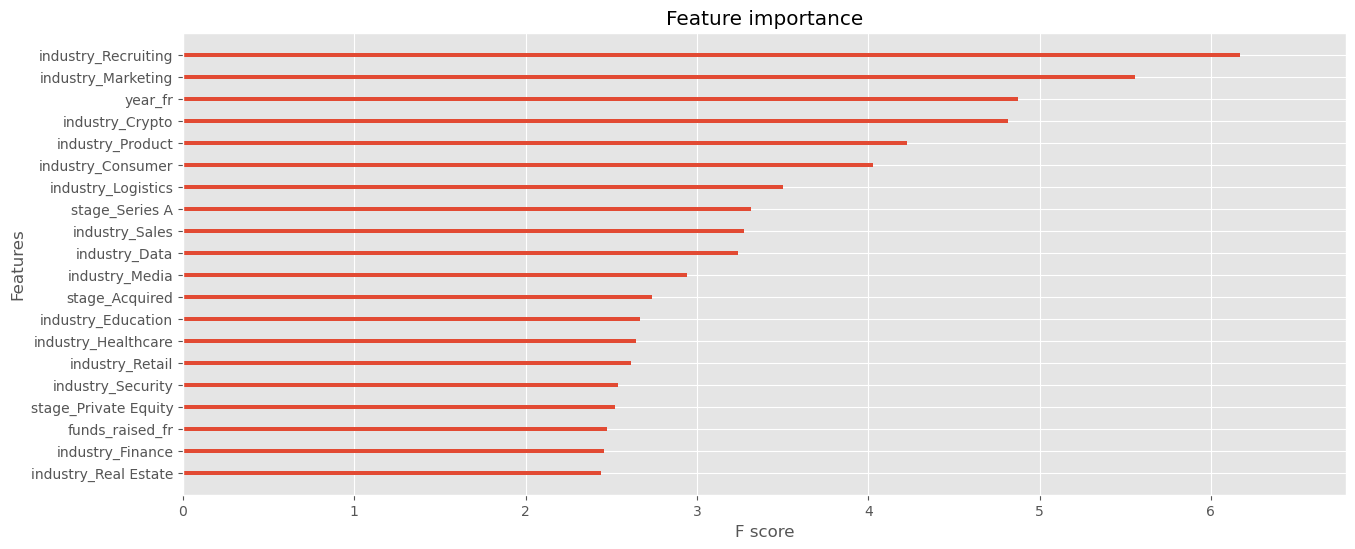

In [1332]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [1333]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_processed, y_train)
y_hat_train = rf.predict(X_train_processed)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9812206572769953
Testing Recall:  0.11392405063291139


Training F1:  0.9766355140186914
Testing F1:  0.16071428571428573


ROC AUC:  0.5225780711617278


Training Accuracy:  0.9921996879875195
Testing Accuracy:  0.780373831775701


In [1334]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_hat_train = rf.predict(X_train_res)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9887745556594949
Testing Recall:  0.27848101265822783


Training F1:  0.9938881053126469
Testing F1:  0.3308270676691729


ROC AUC:  0.5933952341228101


Training Accuracy:  0.9939195509822264
Testing Accuracy:  0.7920560747663551


In [1335]:
# Logistic Regression with balanced class weight - big improvement
lr = LogisticRegression(random_state=42, class_weight='balanced') 

lr.fit(X_train_scaled, y_train)

y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6713615023474179
Testing Recall:  0.6835443037974683


Training F1:  0.40281690140845067
Testing F1:  0.4426229508196721


ROC AUC:  0.6827463639331182


Training Accuracy:  0.6692667706708268
Testing Accuracy:  0.6822429906542056


In [1336]:
lr2 = LogisticRegression(random_state=42)
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6594948550046773
Testing Recall:  0.7088607594936709


Training F1:  0.6707897240723121
Testing F1:  0.46861924686192474


ROC AUC:  0.7054332450763483


Training Accuracy:  0.676333021515435
Testing Accuracy:  0.7032710280373832


In [1337]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

This model correctly identifies 61% of companies that had more than one round of layoffs (recall).
When it predicts a company had multiple layoffs, it is correct 41% of the time (precision).

In [1338]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.666043030869972
Testing Recall:  0.7088607594936709


Training F1:  0.67233238904627
Testing F1:  0.459016393442623


ROC AUC:  0.6982699212941134


Training Accuracy:  0.6753975678203928
Testing Accuracy:  0.6915887850467289


In [1340]:
lr_best.best_params_

{'classifier': LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear'),
 'classifier__C': 0.5,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [1341]:
best_lr = LogisticRegression(random_state=42, C=0.5, penalty='l1', solver='liblinear')
best_lr.fit(X_train_res_scaled, y_train_res_scaled)

LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear')

In [1342]:
## Top coefficients

coef_df = pd.DataFrame(best_lr.coef_, columns=X_train_res_scaled.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

coef  coef_abs
industry_Recruiting     -2.345426  2.345426
stage_Series A          -1.555835  1.555835
industry_Real Estate     1.458090  1.458090
stage_Private Equity    -1.135442  1.135442
industry_Education       1.094913  1.094913
stage_Seed              -1.024950  1.024950
industry_Data           -0.940654  0.940654
stage_Acquired          -0.891482  0.891482
industry_HR             -0.878737  0.878737
industry_Infrastructure -0.725138  0.725138
industry_Transportation  0.723769  0.723769
industry_Logistics      -0.599900  0.599900
stage_Series F           0.576473  0.576473
industry_Marketing      -0.566721  0.566721
industry_Retail          0.535124  0.535124
industry_Food            0.507632  0.507632
stage_Unknown           -0.488615  0.488615
industry_Crypto          0.448725  0.448725
industry_Travel          0.446884  0.446884
year_fr                 -0.394833  0.394833

In [1619]:
feat_importance = coef_df.sort_values(by='coef_abs', ascending=False)[:20]

y=np.array(feat_importance['coef'])
color=np.array(['rgb(255,255,255)']*y.shape[0])
color[y<0]='rgb(204,204, 205)'
color[y>=0]='rgb(130, 0, 0)'

data=[dict(type='bar',
       y=y,
       marker=dict(color=color.tolist()) 
      )]


fig = px.bar(feat_importance['coef'], color=data[0]['marker']['color'])
fig.show()

In [1621]:
fig = px.bar(feat_importance['coef'])
fig.show()

In [ ]:
### PREDICTION EXAMPLE ###
example_company = ['Austin', 'Stage B', 'Real Estate', 'United States', 50.0]

### CLASSIFICATION WITH CRUNCHBASE DATA ###

In [ ]:
# calc # of employees laid off
# either target more than one round or more than x% of employees laid off

In [1782]:
df_class_final = df_classification_cb.drop(['Headquarters Regions', 'Founded Date'], axis=1)

In [1783]:
df_class_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   company                                 1455 non-null   object        
 1   date                                    1455 non-null   datetime64[ns]
 2   industry                                1455 non-null   object        
 3   country                                 1455 non-null   object        
 4   Headquarters Location                   1455 non-null   object        
 5   Operating Status                        1455 non-null   object        
 6   total_laid_off                          1455 non-null   float64       
 7   percentage_laid_off                     1455 non-null   float64       
 8   stage                                   1455 non-null   object        
 9   Industries                              1455 non-nul

In [1784]:
df_class_final['multiple'] = [1 if co in mult_layoffs else 0 for co in df_class_final.company]

In [1785]:
df_class_final = df_class_final[~df_class_final.duplicated()]

In [1786]:
df2 = df_class_final.drop(['Estimated Revenue Range', 
                           'total_laid_off', 
                           'percentage_laid_off'], axis=1)

In [1787]:
# dropping duplicates
df2 = df2[~df2.duplicated()]

In [1788]:
# sorting from oldest to newest
df2 = df2.sort_values(by='date').reset_index(drop=True)

# dropping duplicated where stage is Unknown
dup = df2[df2.duplicated(subset='company')]
df2 = df2.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

# keeping rows with most recent record
df2 = df2.drop_duplicates(subset='company', keep='last').reset_index(drop=True)

In [1789]:
df2.multiple.value_counts(normalize=True)

0    0.778689
1    0.221311
Name: multiple, dtype: float64

In [1790]:
X = df2.drop(['multiple', 'company', 'date'], axis=1)
y = df2['multiple']

In [1791]:
X.head()

industry        country                   Headquarters Location  \
0          Retail  United States       New York, New York, United States   
1  Transportation  United States  Los Angeles, California, United States   
2        Consumer  United States           Bucharest, Bucuresti, Romania   
3         Support  United States            Austin, Texas, United States   
4       Marketing  United States        Boulder, Colorado, United States   

  Operating Status     stage  \
0           Active  Series C   
1           Active   Unknown   
2           Active      Seed   
3           Active      Seed   
4           Active      Seed   

                                          Industries  \
0  E-Commerce, Fashion, Lifestyle, Retail, Shoes,...   
1  Child Care, Children, Information Technology, ...   
2  Advertising, Event Management, Small and Mediu...   
3        Customer Service, Enterprise Software, SaaS   
4                 Advertising, Advertising Platforms   

                                     Industry Groups  \
0  Clothing and Apparel, Commerce and Shopping, C...   
1  Community and Lifestyle, Health Care, Informat...   
2  Advertising, Events, Media and Entertainment, ...   
3             Other, Professional Services, Software   
4                   Advertising, Sales and Marketing   

   Total Funding Amount Currency (in USD)  Number of Funding Rounds  \
0                              90492915.0                       3.0   
1                             123799999.0                      12.0   
2                             196000000.0                       6.0   
3                               6000000.0                       1.0   
4                               4618000.0                       5.0   

   Trend Score (30 Days) Number of Employees  Number of Acquisitions  year_fr  \
0                    1.0                1-10                     0.0     2020   
1                    2.1             101-250                     0.0     2020   
2                   -0.5                1-10                     0.0     2020   
3                    0.6               11-50                     0.0     2020   
4                    0.6               11-50                     0.0     2020   

   funds_raised_fr  founded_year    rev_est  
0             90.0        2010.0  5000000.0  
1             45.0        2014.0   500000.0  
2              1.0        2016.0   500000.0  
3              6.0        2021.0  5000000.0  
4              4.0        2012.0  5000000.0

In [1792]:
# train test split & preprocess
cat_columns = ['industry', 'stage', 'Number of Employees', 
               'Operating Status', 'country'] #'location' #industry groups

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [1793]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    624
1    199
Name: multiple, dtype: int64
1    624
0    624
Name: multiple, dtype: int64


In [1801]:
lr2 = LogisticRegression(random_state=42, solver='liblinear')
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7884615384615384
Testing Recall:  0.6590909090909091


Training F1:  0.7754137115839242
Testing F1:  0.4172661870503597


ROC AUC:  0.6866883116883117


Training Accuracy:  0.7716346153846154
Testing Accuracy:  0.7054545454545454


In [1802]:
## Top coefficients - this list makes a lot of sense

coef_df = pd.DataFrame(lr2.coef_, columns=X_train_res_scaled.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

coef  coef_abs
industry_Aerospace              2.225690  2.225690
industry_Recruiting            -2.122267  2.122267
Number of Employees_11-50      -1.720714  1.720714
country_Indonesia              -1.535202  1.535202
industry_Crypto                 1.427448  1.427448
industry_Education              1.368470  1.368470
industry_Marketing             -1.118497  1.118497
stage_Series G                 -1.117939  1.117939
country_Norway                  1.064853  1.064853
stage_Series H                  1.030865  1.030865
industry_HR                    -1.025805  1.025805
Number of Employees_5001-10000  0.970370  0.970370
Number of Employees_501-1000    0.935261  0.935261
country_Kenya                   0.929626  0.929626
country_Chile                   0.919361  0.919361
industry_Legal                 -0.913608  0.913608
industry_Real Estate            0.888966  0.888966
industry_Logistics             -0.871949  0.871949
Number of Employees_1-10       -0.852916  0.852916
country_Egypt                   0.852094  0.852094

In [1623]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

In [1630]:
lr_best.best_params_

{'classifier': LogisticRegression(C=1000000000000.0, penalty='l1', random_state=42,
                    solver='liblinear'),
 'classifier__C': 1000000000000.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [1624]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7929373996789727
Testing Recall:  0.5813953488372093


Training F1:  0.7647058823529411
Testing F1:  0.35460992907801414


ROC AUC:  0.6333700882117081


Training Accuracy:  0.7560192616372392
Testing Accuracy:  0.6690909090909091


In [1803]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr2.predict(X_train_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7437185929648241
Testing Recall:  0.6590909090909091


Training F1:  0.592
Testing F1:  0.4172661870503597


ROC AUC:  0.6866883116883117


Training Accuracy:  0.7521263669501823
Testing Accuracy:  0.7054545454545454


In [1811]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                    min_child_weight=30, subsample=0.5)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8341708542713567
Testing Recall:  0.8181818181818182


Training F1:  0.5608108108108109
Testing F1:  0.4556962025316456


ROC AUC:  0.7402597402597403


Training Accuracy:  0.68408262454435
Testing Accuracy:  0.6872727272727273


In [1870]:
# adding more specific features (location and industry group)

# train test split & preprocess
cat_columns = ['industry', 'stage', 'Number of Employees', 
               'Operating Status', 'country'] #'location' #industry groups

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [1824]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    624
1    199
Name: multiple, dtype: int64
1    624
0    624
Name: multiple, dtype: int64


In [1820]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr3.predict(X_train_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.914572864321608
Testing Recall:  0.5681818181818182


Training F1:  0.7930283224400871
Testing F1:  0.4545454545454546


ROC AUC:  0.6953463203463205


Training Accuracy:  0.8845686512758202
Testing Accuracy:  0.7818181818181819


In [1821]:
lr4 = LogisticRegression(random_state=42, penalty='l2', C=1e12)
lr4.fit(X_train_res_scaled, y_train_res)

y_hat_train = lr3.predict(X_train_res_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9310897435897436
Testing Recall:  0.5681818181818182


Training F1:  0.9056897895557288
Testing F1:  0.4545454545454546


ROC AUC:  0.6953463203463205


Training Accuracy:  0.9030448717948718
Testing Accuracy:  0.7818181818181819


In [1816]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=10, subsample=0.5) # with full data

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9045226130653267
Testing Recall:  0.7272727272727273


Training F1:  0.6360424028268551
Testing F1:  0.4266666666666667


ROC AUC:  0.7034632034632035


Training Accuracy:  0.7496962332928311
Testing Accuracy:  0.6872727272727273


In [1915]:
xgb = XGBClassifier(random_state=42, max_depth=4, min_child_weight=25, 
                    subsample=0.5) # country / industry
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8044871794871795
Testing Recall:  0.5227272727272727


Training F1:  0.8325041459369819
Testing F1:  0.4554455445544554


ROC AUC:  0.6877705627705628


Training Accuracy:  0.8381410256410257
Testing Accuracy:  0.8


In [ ]:
### BEST MODEL ###

In [1895]:
# best with indstry / country
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=30, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8341708542713567
Testing Recall:  0.8181818181818182


Training F1:  0.5608108108108109
Testing F1:  0.4556962025316456


ROC AUC:  0.7402597402597403


Training Accuracy:  0.68408262454435
Testing Accuracy:  0.6872727272727273


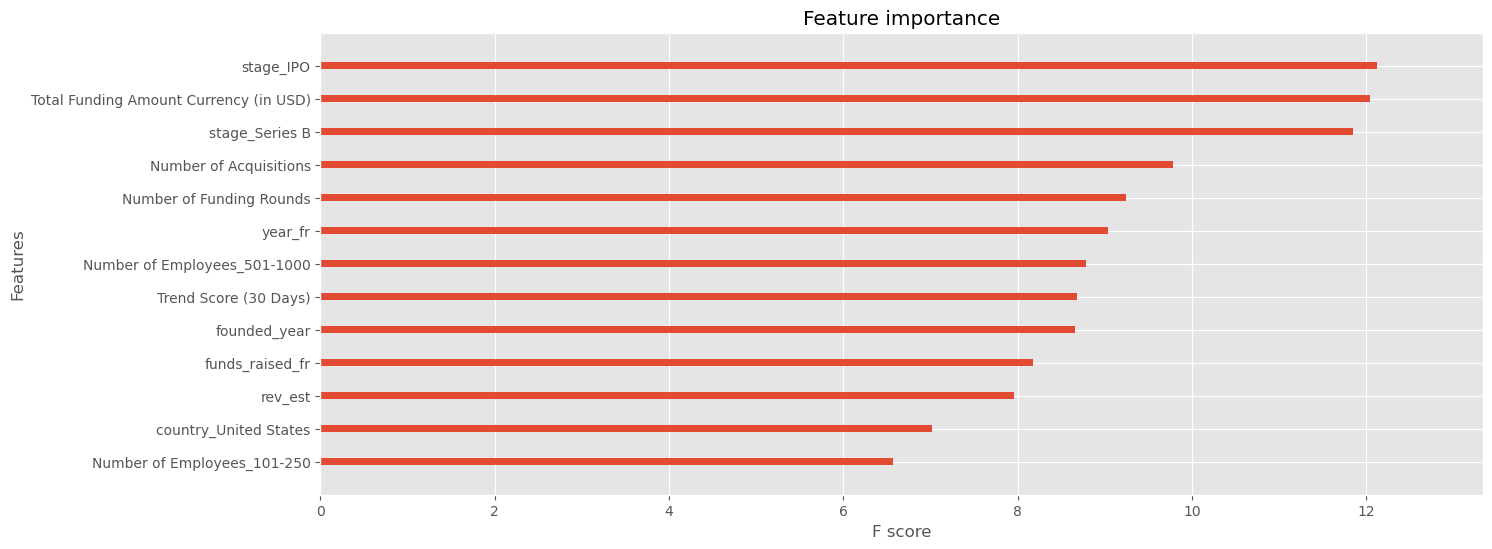

In [1872]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [ ]:
# plot ROC AUC
# plot confusion matrix

In [1896]:
filename = 'final_classification_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_processed, y_test)

print(result)

0.6872727272727273


In [1929]:
example_df

Empty DataFrame
Columns: [industry_Aerospace, country_United Kingdom, Headquarters Location, Operating Status, stage, Industries, Industry Groups, Total Funding Amount Currency (in USD), Number of Funding Rounds, Trend Score (30 Days), Number of Employees, Number of Acquisitions, year_fr, funds_raised_fr, founded_year, rev_est]
Index: []

In [1949]:
pred_df = pd.DataFrame(columns=X_train_processed.columns)
pred_df

X.columns

example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, '1000', 2, 2021, 320, 2018, 50000000]

def prep_pred(example_co):
    example_df = pd.DataFrame(columns=X.columns[-11:])
    #example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, 2, 2021, 320, 2018, 50000000]
    ex = example_co
    ex[0] = 'industry_'+ example_co[0]
    ex[1] = 'country_'+ example_co[1]
    ex[5] = 'Number of Employees_'+ example_co[5]
    example_df.rename(columns={'Industries': ex[0], 
                               'Industry Groups': ex[1], 
                               'Number of Employees': ex[5]}, inplace=True)
    
    ex[0] = 1
    ex[1] = 1
    ex[5] = 1
   
    example_df.loc[0] = ex
    
    for col in X_train_processed:
        if col not in example_df:
            print("Adding missing feature {}".format(col))
            example_df[col] = 0

    return example_df

In [1953]:
example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, '501-1000', 2, 2021, 320, 2018, 50000000]
test = prep_pred(example_co)
loaded_model.predict(test)

Adding missing feature industry_Construction
Adding missing feature industry_Consumer
Adding missing feature industry_Crypto
Adding missing feature industry_Data
Adding missing feature industry_Education
Adding missing feature industry_Energy
Adding missing feature industry_Finance
Adding missing feature industry_Fitness
Adding missing feature industry_Food
Adding missing feature industry_HR
Adding missing feature industry_Hardware
Adding missing feature industry_Healthcare
Adding missing feature industry_Infrastructure
Adding missing feature industry_Legal
Adding missing feature industry_Logistics
Adding missing feature industry_Manufacturing
Adding missing feature industry_Marketing
Adding missing feature industry_Media
Adding missing feature industry_Other
Adding missing feature industry_Product
Adding missing feature industry_Real Estate
Adding missing feature industry_Recruiting
Adding missing feature industry_Retail
Adding missing feature industry_Sales
Adding missing feature ind

ValueError: feature_names mismatch: ['industry_Aerospace', 'industry_Construction', 'industry_Consumer', 'industry_Crypto', 'industry_Data', 'industry_Education', 'industry_Energy', 'industry_Finance', 'industry_Fitness', 'industry_Food', 'industry_HR', 'industry_Hardware', 'industry_Healthcare', 'industry_Infrastructure', 'industry_Legal', 'industry_Logistics', 'industry_Manufacturing', 'industry_Marketing', 'industry_Media', 'industry_Other', 'industry_Product', 'industry_Real Estate', 'industry_Recruiting', 'industry_Retail', 'industry_Sales', 'industry_Security', 'industry_Support', 'industry_Transportation', 'industry_Travel', 'stage_Acquired', 'stage_IPO', 'stage_Private Equity', 'stage_Seed', 'stage_Series A', 'stage_Series B', 'stage_Series C', 'stage_Series D', 'stage_Series E', 'stage_Series F', 'stage_Series G', 'stage_Series H', 'stage_Series I', 'stage_Series J', 'stage_Subsidiary', 'stage_Unknown', 'Number of Employees_1-10', 'Number of Employees_10001+', 'Number of Employees_1001-5000', 'Number of Employees_101-250', 'Number of Employees_11-50', 'Number of Employees_251-500', 'Number of Employees_5001-10000', 'Number of Employees_501-1000', 'Number of Employees_51-100', 'Operating Status_Active', 'Operating Status_Closed', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Brazil', 'country_Bulgaria', 'country_Canada', 'country_Chile', 'country_China', 'country_Colombia', 'country_Denmark', 'country_Egypt', 'country_Estonia', 'country_Finland', 'country_France', 'country_Germany', 'country_Hong Kong', 'country_India', 'country_Indonesia', 'country_Ireland', 'country_Israel', 'country_Kenya', 'country_Lithuania', 'country_Luxembourg', 'country_Malaysia', 'country_Mexico', 'country_Myanmar', 'country_Netherlands', 'country_New Zealand', 'country_Nigeria', 'country_Norway', 'country_Portugal', 'country_Romania', 'country_Seychelles', 'country_Singapore', 'country_Sweden', 'country_Switzerland', 'country_Thailand', 'country_United Arab Emirates', 'country_United Kingdom', 'country_United States', 'Total Funding Amount Currency (in USD)', 'Number of Funding Rounds', 'Trend Score (30 Days)', 'Number of Acquisitions', 'year_fr', 'funds_raised_fr', 'founded_year', 'rev_est'] ['industry_Aerospace', 'country_United Kingdom', 'Total Funding Amount Currency (in USD)', 'Number of Funding Rounds', 'Trend Score (30 Days)', 'Number of Employees_501-1000', 'Number of Acquisitions', 'year_fr', 'funds_raised_fr', 'founded_year', 'rev_est', 'industry_Construction', 'industry_Consumer', 'industry_Crypto', 'industry_Data', 'industry_Education', 'industry_Energy', 'industry_Finance', 'industry_Fitness', 'industry_Food', 'industry_HR', 'industry_Hardware', 'industry_Healthcare', 'industry_Infrastructure', 'industry_Legal', 'industry_Logistics', 'industry_Manufacturing', 'industry_Marketing', 'industry_Media', 'industry_Other', 'industry_Product', 'industry_Real Estate', 'industry_Recruiting', 'industry_Retail', 'industry_Sales', 'industry_Security', 'industry_Support', 'industry_Transportation', 'industry_Travel', 'stage_Acquired', 'stage_IPO', 'stage_Private Equity', 'stage_Seed', 'stage_Series A', 'stage_Series B', 'stage_Series C', 'stage_Series D', 'stage_Series E', 'stage_Series F', 'stage_Series G', 'stage_Series H', 'stage_Series I', 'stage_Series J', 'stage_Subsidiary', 'stage_Unknown', 'Number of Employees_1-10', 'Number of Employees_10001+', 'Number of Employees_1001-5000', 'Number of Employees_101-250', 'Number of Employees_11-50', 'Number of Employees_251-500', 'Number of Employees_5001-10000', 'Number of Employees_51-100', 'Operating Status_Active', 'Operating Status_Closed', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Brazil', 'country_Bulgaria', 'country_Canada', 'country_Chile', 'country_China', 'country_Colombia', 'country_Denmark', 'country_Egypt', 'country_Estonia', 'country_Finland', 'country_France', 'country_Germany', 'country_Hong Kong', 'country_India', 'country_Indonesia', 'country_Ireland', 'country_Israel', 'country_Kenya', 'country_Lithuania', 'country_Luxembourg', 'country_Malaysia', 'country_Mexico', 'country_Myanmar', 'country_Netherlands', 'country_New Zealand', 'country_Nigeria', 'country_Norway', 'country_Portugal', 'country_Romania', 'country_Seychelles', 'country_Singapore', 'country_Sweden', 'country_Switzerland', 'country_Thailand', 'country_United Arab Emirates', 'country_United States']

In [1868]:
#best so far with headquarters location / indstry
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=34, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8341708542713567
Testing Recall:  0.8181818181818182


Training F1:  0.5496688741721854
Testing F1:  0.46153846153846156


ROC AUC:  0.7445887445887447


Training Accuracy:  0.669501822600243
Testing Accuracy:  0.6945454545454546


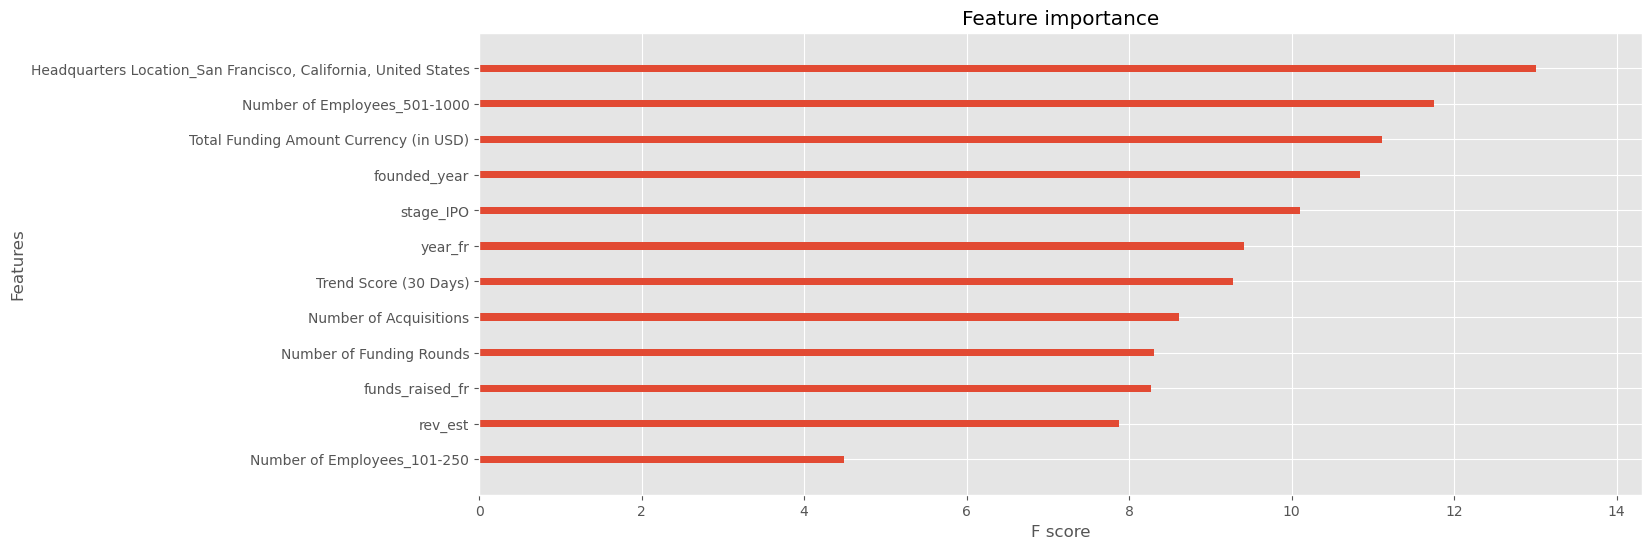

In [1869]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [1766]:
# witn industry rather than industry group
xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                    min_child_weight=30, subsample=0.5)


xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8
Testing Recall:  0.7674418604651163


Training F1:  0.5776173285198556
Testing F1:  0.4714285714285714


ROC AUC:  0.7457898957497995


Training Accuracy:  0.715674362089915
Testing Accuracy:  0.730909090909091


In [1826]:
pred_df

Empty DataFrame
Columns: [industry_Aerospace, industry_Construction, industry_Consumer, industry_Crypto, industry_Data, industry_Education, industry_Energy, industry_Finance, industry_Fitness, industry_Food, industry_HR, industry_Hardware, industry_Healthcare, industry_Infrastructure, industry_Legal, industry_Logistics, industry_Manufacturing, industry_Marketing, industry_Media, industry_Other, industry_Product, industry_Real Estate, industry_Recruiting, industry_Retail, industry_Sales, industry_Security, industry_Support, industry_Transportation, industry_Travel, stage_Acquired, stage_IPO, stage_Private Equity, stage_Seed, stage_Series A, stage_Series B, stage_Series C, stage_Series D, stage_Series E, stage_Series F, stage_Series G, stage_Series H, stage_Series I, stage_Series J, stage_Subsidiary, stage_Unknown, Number of Employees_1-10, Number of Employees_10001+, Number of Employees_1001-5000, Number of Employees_101-250, Number of Employees_11-50, Number of Employees_251-500, Number of Employees_5001-10000, Number of Employees_501-1000, Number of Employees_51-100, Operating Status_Active, Operating Status_Closed, Headquarters Location_Abba Hillel, HaDarom, Israel, Headquarters Location_Ahmedabad, Gujarat, India, Headquarters Location_Ambler, Pennsylvania, United States, Headquarters Location_American Fork, Utah, United States, Headquarters Location_Amsterdam, Noord-Holland, The Netherlands, Headquarters Location_Armonk, New York, United States, Headquarters Location_Atlanta, Georgia, United States, Headquarters Location_Auckland, Auckland, New Zealand, Headquarters Location_Austin, Texas, United States, Headquarters Location_Baltimore, Maryland, United States, Headquarters Location_Bangalore, Karnataka, India, Headquarters Location_Bangkok, Krung Thep, Thailand, Headquarters Location_Basingstoke, Hampshire, United Kingdom, Headquarters Location_Bedford, Massachusetts, United States, Headquarters Location_Beijing, Beijing, China, Headquarters Location_Bellevue, Washington, United States, Headquarters Location_Belmont, California, United States, Headquarters Location_Belo Horizonte, Minas Gerais, Brazil, Headquarters Location_Bend, Oregon, United States, Headquarters Location_Bengaluru, Karnataka, India, Headquarters Location_Berkeley, California, United States, Headquarters Location_Berlin, Berlin, Germany, Headquarters Location_Billerica, Massachusetts, United States, Headquarters Location_Birmingham, Alabama, United States, Headquarters Location_Boca Raton, Florida, United States, Headquarters Location_Bogotá, Distrito Especial, Colombia, Headquarters Location_Boston, Massachusetts, United States, Headquarters Location_Boulder, Colorado, United States, Headquarters Location_Brasil, Sao Paulo, Brazil, Headquarters Location_Brisbane, Queensland, Australia, Headquarters Location_Bristol, Bristol, City of, United Kingdom, Headquarters Location_Bronx, New York, United States, Headquarters Location_Brookline, Massachusetts, United States, Headquarters Location_Brooklyn, New York, United States, Headquarters Location_Buenos Aires, Distrito Federal, Argentina, Headquarters Location_Burlington, Massachusetts, United States, Headquarters Location_Calgary, Alberta, Canada, Headquarters Location_Cambridge, Massachusetts, United States, Headquarters Location_Campinas, Goias, Brazil, Headquarters Location_Carpinteria, California, United States, Headquarters Location_Central, Hong Kong Island, Hong Kong, Headquarters Location_Charlotte, North Carolina, United States, Headquarters Location_Chennai, Tamil Nadu, India, Headquarters Location_Chesterfield, Missouri, United States, ...]
Index: []

[0 rows x 276 columns]

In [ ]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [1748]:
xgb = XGBClassifier(random_state=42, max_depth=3,  
                    min_child_weight=30, subsample=0.5, alpha=0.5)


xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7736757624398074
Testing Recall:  0.6976744186046512


Training F1:  0.8019966722129783
Testing F1:  0.5357142857142857


ROC AUC:  0.7647854851643945


Training Accuracy:  0.8089887640449438
Testing Accuracy:  0.8109090909090909


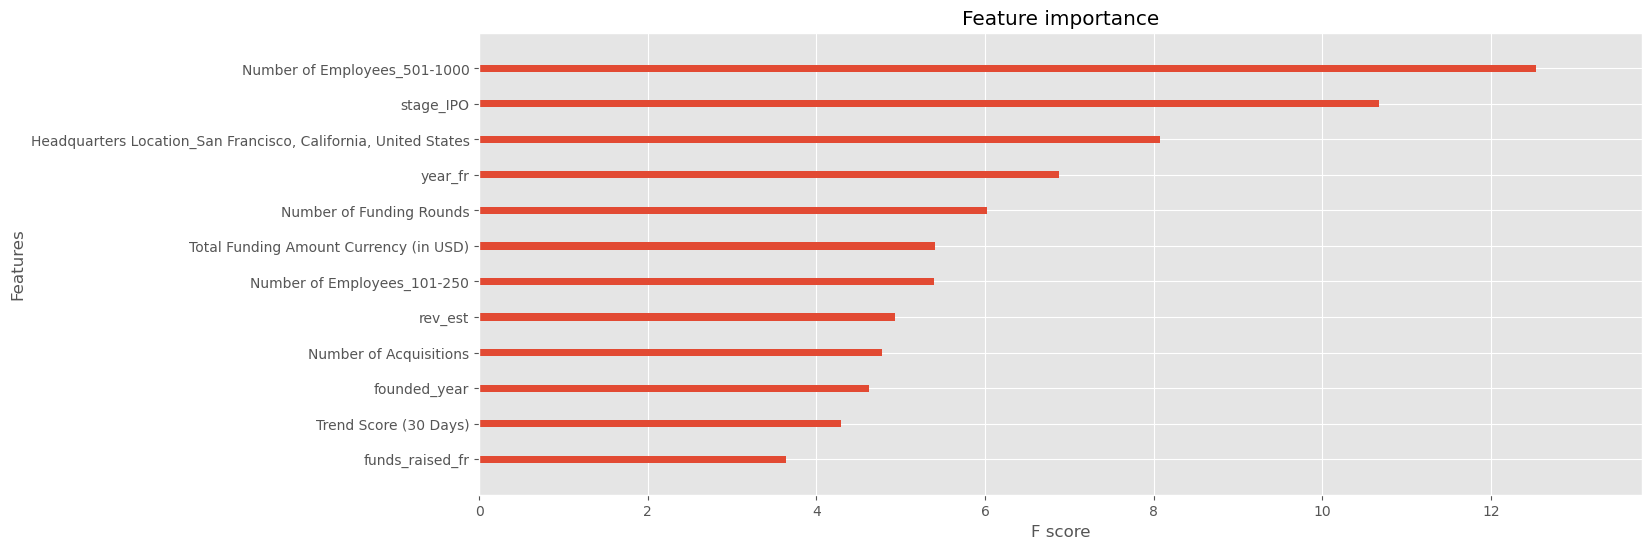

In [1749]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

### Regression

In [1073]:
# daily layoffs

total_layoffs_by_date = layoffs_raw[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()
total_layoffs_by_date.head()

date  total_laid_off
0 2020-03-11            75.0
1 2020-03-12            20.0
2 2020-03-13            14.0
3 2020-03-16           146.0
4 2020-03-18             4.0

In [1074]:
layoffs_raw['month'] = [pd.to_datetime(pd.to_datetime(day).strftime('%Y-%m')) for day in layoffs_raw['date']]

In [1075]:
total_layoffs_by_month = layoffs_raw[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()
total_layoffs_by_month.head()

month  total_laid_off
0 2020-03-01          9628.0
1 2020-04-01         26710.0
2 2020-05-01         25804.0
3 2020-06-01          7627.0
4 2020-07-01          7112.0

In [1076]:
# add in external economic data

bf_seas = pd.read_csv('data/business_formations_seasonal.csv')
bf_nonseas = pd.read_csv('data/business_formations_nonseasonal.csv')

nfp = pd.read_csv('data/nfp.csv')

In [685]:
bf_nonseas.head()

Unnamed: 0  cell_value  time_slot_id error_data category_code  \
0         977      354726             0         no         TOTAL   
1         978      319359             0         no         TOTAL   
2         979      327898             0         no         TOTAL   
3         980      299709             0         no         TOTAL   
4         981      343347             0         no         TOTAL   

  seasonally_adj data_type_code        time  us               sector  \
0             no          BA_BA  2019-01-01   1  Total for All NAICS   
1             no          BA_BA  2019-02-01   1  Total for All NAICS   
2             no          BA_BA  2019-03-01   1  Total for All NAICS   
3             no          BA_BA  2019-04-01   1  Total for All NAICS   
4             no          BA_BA  2019-05-01   1  Total for All NAICS   

       month  
0 2019-01-01  
1 2019-02-01  
2 2019-03-01  
3 2019-04-01  
4 2019-05-01

In [672]:
nfp.head()

date  change_nfp
0  1/1/20         339
1  2/1/20         376
2  3/1/20       -1498
3  4/1/20      -20493
4  5/1/20        2642

In [683]:
bf_nonseas['month'] = [pd.to_datetime(month) for month in bf_nonseas['time']]
nfp['month'] = [pd.to_datetime(month) for month in nfp['date']]

In [689]:
# monthly

all = total_layoffs_by_month.merge(bf_nonseas[['month', 'cell_value']], 
                                   on='month', how='left')

all.head()

month  total_laid_off  cell_value
0 2020-03-01          9628.0    282298.0
1 2020-04-01         26710.0    301463.0
2 2020-05-01         25804.0    285221.0
3 2020-06-01          7627.0    349320.0
4 2020-07-01          7112.0    584760.0

In [690]:
all = all.merge(nfp[['month', 'change_nfp']], on='month', how='left')
all.head()

month  total_laid_off  cell_value  change_nfp
0 2020-03-01          9628.0    282298.0     -1498.0
1 2020-04-01         26710.0    301463.0    -20493.0
2 2020-05-01         25804.0    285221.0      2642.0
3 2020-06-01          7627.0    349320.0      4505.0
4 2020-07-01          7112.0    584760.0      1388.0

In [696]:
fig = px.scatter(x=all['cell_value'][(all['total_laid_off']<50000)], 
                 y=all['total_laid_off'][(all['total_laid_off']<50000)], 
                 trendline='ols')
fig.show()

In [695]:
fig = px.scatter(x=all['change_nfp'][(all['change_nfp']>-5000) & (all['total_laid_off']<50000)], 
                 y=all['total_laid_off'][(all['change_nfp']>-5000) & (all['total_laid_off']<50000)], 
                 trendline='ols')
fig.show()

In [702]:
# monthly
df_model = all[(all['change_nfp']>-5000) & (all['total_laid_off']<50000)]
df_model.dropna()

target = df_model['total_laid_off']
features = df_model[['change_nfp', 'cell_value']]

In [ ]:
# daily

In [752]:
df_model = all_data[(all_data['change_nfp']>-5000) & 
                    (all_data['total_laid_off']<50000) & 
                    (all_data['date'] < '01-01-2023')]


target = df_model['total_laid_off']
features = df_model[['change_nfp', 'business_formations', 'close_px']]

In [753]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # If using an older version of sklearn:
    # rmse = np.sqrt(mean_squared_error(y_true, y_predict))

    # Return the score
    return [r2, rmse]


In [754]:
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, random_state=42)

In [757]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45, max_depth=30)

# Fit the model to training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

[-0.052285781241756535, 1623.5447513765127]

In [701]:
fortune_1000[fortune_1000.sector=='Technology'].head()

company  rank  rank_change   revenue   profit  \
2               Apple     3          0.0  365817.0  94680.0   
7            Alphabet     8          1.0  257637.0  76033.0   
13          Microsoft    14          1.0  168088.0  61271.0   
26     Meta Platforms    27          7.0  117929.0  39370.0   
30  Dell Technologies    31         -3.0  106995.0   5563.0   

    num. of employees      sector           city state newcomer ceo_founder  \
2            154000.0  Technology      Cupertino    CA       no          no   
7            156500.0  Technology  Mountain View    CA       no          no   
13           181000.0  Technology        Redmond    WA       no          no   
26            71970.0  Technology     Menlo Park    CA       no         yes   
30           133000.0  Technology     Round Rock    TX       no         yes   

   ceo_woman profitable prev_rank              CEO                   Website  \
2         no        yes       3.0  Timothy D. Cook             www.apple.com   
7         no        yes       9.0    Sundar Pichai       https://www.abc.xyz   
13        no        yes      15.0    Satya Nadella         www.microsoft.com   
26        no        yes      34.0  Mark Zuckerberg   https://investor.fb.com   
30        no        yes      28.0  Michael S. Dell  www.delltechnologies.com   

   Ticker Market Cap  
2    AAPL    2443962  
7   GOOGL    1309359  
13   MSFT    1941033  
26   META     475718  
30   DELL      32568

In [640]:
bf_nonseas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      48 non-null     int64 
 1   cell_value      48 non-null     int64 
 2   time_slot_id    48 non-null     int64 
 3   error_data      48 non-null     object
 4   category_code   48 non-null     object
 5   seasonally_adj  48 non-null     object
 6   data_type_code  48 non-null     object
 7   time            48 non-null     object
 8   us              48 non-null     int64 
 9   sector          48 non-null     object
dtypes: int64(4), object(6)
memory usage: 3.9+ KB


In [741]:
bf_nonseas = bf_nonseas[['time', 'cell_value']]

bf_nonseas.set_index('time', inplace=True)
bf_nonseas.index = pd.to_datetime(bf_nonseas.index)
bf_nonseas.index.rename('date')
#bf_nonseas = bf_nonseas['cell_value'].resample('D').ffill()

idx = pd.date_range(bf_nonseas.index.min(), bf_nonseas.index.max().to_period('M').to_timestamp('M'))
bf_nonseas = bf_nonseas.reindex(idx, method='ffill')


bf_nonseas = pd.DataFrame(bf_nonseas).reset_index()
bf_nonseas

index  cell_value
0    2019-01-01      354726
1    2019-01-02      354726
2    2019-01-03      354726
3    2019-01-04      354726
4    2019-01-05      354726
...         ...         ...
1456 2022-12-27      293688
1457 2022-12-28      293688
1458 2022-12-29      293688
1459 2022-12-30      293688
1460 2022-12-31      293688

[1461 rows x 2 columns]

In [742]:
bf_nonseas.columns = ['date', 'business_formations']

In [743]:
#all_data = pd.concat([total_layoffs_by_date, bf_nonseas])

all_data = total_layoffs_by_date.merge(bf_nonseas, on='date', how='left')
all_data

date  total_laid_off  business_formations
0   2020-03-11            75.0             282298.0
1   2020-03-12            20.0             282298.0
2   2020-03-13            14.0             282298.0
3   2020-03-16           146.0             282298.0
4   2020-03-18             4.0             282298.0
..         ...             ...                  ...
435 2023-01-16          1125.0                  NaN
436 2023-01-17          1816.0                  NaN
437 2023-01-18         11816.0                  NaN
438 2023-01-19          1753.0                  NaN
439 2023-01-20         14559.0                  NaN

[440 rows x 3 columns]

In [744]:
nfp.set_index('date', inplace=True)
nfp.index = pd.to_datetime(nfp.index)

#nfp = nfp['change_nfp'].resample('D').ffill()
idx = pd.date_range(nfp.index.min(), nfp.index.max().to_period('M').to_timestamp('M'))
nfp = nfp.reindex(idx, method='ffill')

nfp = pd.DataFrame(nfp).reset_index()
nfp.columns = ['date', 'change_nfp']
nfp

date  change_nfp
0    2020-01-01         339
1    2020-01-02         339
2    2020-01-03         339
3    2020-01-04         339
4    2020-01-05         339
...         ...         ...
1091 2022-12-27         223
1092 2022-12-28         223
1093 2022-12-29         223
1094 2022-12-30         223
1095 2022-12-31         223

[1096 rows x 2 columns]

In [712]:
ixn = yf.Ticker("IXN")
hist = ixn.history(period="3y")

In [713]:
hist

Open       High        Low      Close  \
Date                                                                    
2020-01-28 00:00:00-05:00  35.587471  36.019852  35.528735  35.975800   
2020-01-29 00:00:00-05:00  36.207494  36.256442  35.897481  35.988853   
2020-01-30 00:00:00-05:00  35.835477  36.138961  35.651104  36.111221   
2020-01-31 00:00:00-05:00  35.876269  35.917057  35.053928  35.140404   
2020-02-03 00:00:00-05:00  35.208932  35.749001  35.208932  35.706577   
...                              ...        ...        ...        ...   
2023-01-23 00:00:00-05:00  48.169998  49.290001  48.139999  49.099998   
2023-01-24 00:00:00-05:00  48.730000  49.130001  48.630001  48.980000   
2023-01-25 00:00:00-05:00  48.209999  49.090000  47.889999  48.930000   
2023-01-26 00:00:00-05:00  49.389999  49.700001  48.919998  49.700001   
2023-01-27 00:00:00-05:00  49.340000  50.180000  49.290001  49.880001   

                            Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                        
2020-01-28 00:00:00-05:00   366600        0.0           0.0            0.0  
2020-01-29 00:00:00-05:00   421200        0.0           0.0            0.0  
2020-01-30 00:00:00-05:00   383400        0.0           0.0            0.0  
2020-01-31 00:00:00-05:00   412800        0.0           0.0            0.0  
2020-02-03 00:00:00-05:00   640800        0.0           0.0            0.0  
...                            ...        ...           ...            ...  
2023-01-23 00:00:00-05:00   552100        0.0           0.0            0.0  
2023-01-24 00:00:00-05:00   135800        0.0           0.0            0.0  
2023-01-25 00:00:00-05:00   600500        0.0           0.0            0.0  
2023-01-26 00:00:00-05:00  1164900        0.0           0.0            0.0  
2023-01-27 00:00:00-05:00   429900        0.0           0.0            0.0  

[757 rows x 8 columns]

In [745]:
tech_stocks = hist['Close'].reset_index()
#tech_stocks['Date'][0].replace(tzinfo=None)
tech_stocks['Date'] = pd.to_datetime(tech_stocks['Date'].dt.date)

In [746]:
tech_stocks.columns = ['date', 'close_px']
tech_stocks['close_px'] = tech_stocks['close_px'].ffill()

In [747]:
tech_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      757 non-null    datetime64[ns]
 1   close_px  757 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [1199]:
tech_stocks.to_csv('data/IXN_ETF.csv')

In [748]:
all_data = all_data.merge(nfp, on='date', how='left')
all_data

date  total_laid_off  business_formations  change_nfp
0   2020-03-11            75.0             282298.0     -1498.0
1   2020-03-12            20.0             282298.0     -1498.0
2   2020-03-13            14.0             282298.0     -1498.0
3   2020-03-16           146.0             282298.0     -1498.0
4   2020-03-18             4.0             282298.0     -1498.0
..         ...             ...                  ...         ...
435 2023-01-16          1125.0                  NaN         NaN
436 2023-01-17          1816.0                  NaN         NaN
437 2023-01-18         11816.0                  NaN         NaN
438 2023-01-19          1753.0                  NaN         NaN
439 2023-01-20         14559.0                  NaN         NaN

[440 rows x 4 columns]

In [749]:
all_data = all_data.merge(tech_stocks, on='date', how='left')
all_data

date  total_laid_off  business_formations  change_nfp   close_px
0   2020-03-11            75.0             282298.0     -1498.0  30.870432
1   2020-03-12            20.0             282298.0     -1498.0  27.887814
2   2020-03-13            14.0             282298.0     -1498.0  30.976486
3   2020-03-16           146.0             282298.0     -1498.0  26.562931
4   2020-03-18             4.0             282298.0     -1498.0  27.112787
..         ...             ...                  ...         ...        ...
435 2023-01-16          1125.0                  NaN         NaN        NaN
436 2023-01-17          1816.0                  NaN         NaN  47.790001
437 2023-01-18         11816.0                  NaN         NaN  47.259998
438 2023-01-19          1753.0                  NaN         NaN  46.779999
439 2023-01-20         14559.0                  NaN         NaN  47.990002

[440 rows x 5 columns]

In [750]:
all_data['close_px'] = all_data['close_px'].ffill()

In [751]:
all_data

date  total_laid_off  business_formations  change_nfp   close_px
0   2020-03-11            75.0             282298.0     -1498.0  30.870432
1   2020-03-12            20.0             282298.0     -1498.0  27.887814
2   2020-03-13            14.0             282298.0     -1498.0  30.976486
3   2020-03-16           146.0             282298.0     -1498.0  26.562931
4   2020-03-18             4.0             282298.0     -1498.0  27.112787
..         ...             ...                  ...         ...        ...
435 2023-01-16          1125.0                  NaN         NaN  47.660000
436 2023-01-17          1816.0                  NaN         NaN  47.790001
437 2023-01-18         11816.0                  NaN         NaN  47.259998
438 2023-01-19          1753.0                  NaN         NaN  46.779999
439 2023-01-20         14559.0                  NaN         NaN  47.990002

[440 rows x 5 columns]

In [ ]:
### Add more data? public companies htat havent had layoffs with easy data??

In [300]:
layoffs = layoffs_raw.dropna(subset=['total_laid_off', 'industry', 'stage']).reset_index(drop=True)
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1411 non-null   object 
 1   location             1411 non-null   object 
 2   industry             1411 non-null   object 
 3   total_laid_off       1411 non-null   float64
 4   percentage_laid_off  1054 non-null   float64
 5   date                 1411 non-null   object 
 6   stage                1411 non-null   object 
 7   country              1411 non-null   object 
 8   funds_raised         1315 non-null   float64
dtypes: float64(3), object(6)
memory usage: 99.3+ KB


In [302]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1411 non-null   object 
 1   location             1411 non-null   object 
 2   industry             1411 non-null   object 
 3   total_laid_off       1411 non-null   float64
 4   percentage_laid_off  1054 non-null   float64
 5   date                 1411 non-null   object 
 6   stage                1411 non-null   object 
 7   country              1411 non-null   object 
 8   funds_raised         1411 non-null   object 
dtypes: float64(2), object(7)
memory usage: 99.3+ KB


In [ ]:
#### JUST DO REGRESSION WITH PUBLIC COMPANIES, CLASSIFICATION WITH 

In [303]:
layoffs.company.value_counts()[layoffs.company.value_counts() > 1]

Loft          5
Swiggy        5
Uber          5
Gopuff        4
Salesforce    4
             ..
Unico         2
ChowNow       2
Clutch        2
Hubilo        2
ConsenSys     2
Name: company, Length: 175, dtype: int64

In [166]:
print(len(layoffs))

2047


In [258]:
layoffs['implied_no_employees'] = round(layoffs['total_laid_off'] / layoffs['percentage_laid_off'], 0)
layoffs.head()

company         location    industry  total_laid_off  \
0     Google      SF Bay Area    Consumer         12000.0   
1    Wayfair           Boston      Retail          1750.0   
2     Swiggy        Bengaluru        Food           380.0   
3  MediBuddy        Bengaluru  Healthcare           200.0   
4  Vox Media  Washington D.C.       Media           130.0   

   percentage_laid_off        date     stage        country  funds_raised  \
0                 0.06  2023-01-20       IPO  United States          26.0   
1                 0.10  2023-01-20       IPO  United States        1700.0   
2                 0.06  2023-01-20   Unknown          India        3600.0   
3                  NaN  2023-01-20  Acquired          India         192.0   
4                 0.07  2023-01-20  Series F  United States         307.0   

   multiple  implied_no_employees  
0         0              200000.0  
1         1               17500.0  
2         1                6333.0  
3         0                   NaN  
4         1                1857.0

In [259]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company               1411 non-null   object 
 1   location              1411 non-null   object 
 2   industry              1411 non-null   object 
 3   total_laid_off        1411 non-null   float64
 4   percentage_laid_off   1054 non-null   float64
 5   date                  1411 non-null   object 
 6   stage                 1411 non-null   object 
 7   country               1411 non-null   object 
 8   funds_raised          1315 non-null   float64
 9   multiple              1411 non-null   int64  
 10  implied_no_employees  1054 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 121.4+ KB


In [261]:
list(layoffs.company[layoffs.percentage_laid_off.isna()])

['MediBuddy',
 'Karat',
 'Edifecs',
 'Capital One',
 'WeWork ',
 'Riot Games',
 'Hydrow',
 'Rappi',
 'Clutch',
 'Tul',
 'Luxury Presence',
 'RingCentral',
 'Gramophone',
 'Captain Fresh ',
 'Ola',
 'Vial',
 'Skit.ai',
 'Cashfree Payments',
 'Mapbox',
 'Career Karma',
 'CoinDCX',
 'HashiCorp',
 'Embark',
 'Citizen',
 'Till Payments',
 'LEAD',
 'Carbon Health',
 'Cue',
 'Twitter',
 'Zoopla',
 'Qualcomm',
 'GoStudent',
 'Quanergy Systems',
 'Freshly',
 'Balto',
 'Chrono24',
 'Inscripta',
 'Vedantu',
 'Recur Forever',
 'Intel',
 'Adobe',
 'OYO',
 'HealthifyMe',
 'ShareChat',
 'StudySmarter',
 'Etermax',
 'Bitso',
 'Splyt',
 'Orchard',
 'Homepoint',
 'Chili Piper',
 'Properly',
 'The Zebra',
 'Sema4',
 'Science 37',
 'Science 37 ',
 'Cardlytics',
 'Nestcoin',
 'Coinbase',
 'Wistia',
 'Cameo',
 'HighRadius',
 'EverBridge',
 'Brainly',
 'Udaan',
 'Delivery Hero',
 'Argo AI',
 'Booking.com',
 'Oracle',
 'Drop',
 'Tapps Games',
 'Notarize',
 'Dukaan',
 'Amazon',
 'Lattice',
 'Argo AI',
 'Philip

In [264]:
layoffs[(layoffs.percentage_laid_off.isna()) & (layoffs.stage=='IPO')] 
# might be able to get revenue / 

company         location        industry  total_laid_off  \
8           Capital One  Washington D.C.         Finance          1100.0   
9               WeWork     New York City     Real Estate           300.0   
37          RingCentral      SF Bay Area           Other            30.0   
64            HashiCorp      SF Bay Area        Security            69.0   
85                  Cue        San Diego      Healthcare           388.0   
90              Twitter      SF Bay Area        Consumer            40.0   
109            Qualcomm        San Diego        Hardware           153.0   
121    Quanergy Systems      SF Bay Area  Transportation            72.0   
163               Intel      SF Bay Area        Hardware           201.0   
166               Adobe      SF Bay Area       Marketing           100.0   
221           Homepoint          Phoenix     Real Estate           113.0   
249               Sema4         Stamford      Healthcare           500.0   
254          Science 37      Los Angeles      Healthcare            90.0   
255         Science 37       Los Angeles      Healthcare            90.0   
257          Cardlytics          Atlanta       Marketing            51.0   
266            Coinbase      SF Bay Area          Crypto            60.0   
280          EverBridge           Boston           Other           200.0   
296       Delivery Hero           Berlin            Food           100.0   
308              Oracle      SF Bay Area           Other           200.0   
322              Amazon          Seattle          Retail           150.0   
335             Philips        Amsterdam      Healthcare          4000.0   
360          Salesforce      SF Bay Area           Sales            90.0   
372          HelloFresh      SF Bay Area            Food           611.0   
388            Westwing           Munich          Retail           125.0   
399             Compass    New York City     Real Estate           271.0   
413             Netflix      SF Bay Area           Media            30.0   
429                Uber          Vilnius  Transportation            60.0   
439             Shopify           Ottawa          Retail            70.0   
457                Okta      SF Bay Area           Other            24.0   
502                 Wix         Tel Aviv       Marketing           100.0   
507               Absci        Vancouver      Healthcare            40.0   
511               Vroom    New York City  Transportation           337.0   
512        Warby Parker    New York City        Consumer            63.0   
527         RingCentral      SF Bay Area         Support            50.0   
530         Beyond Meat      Los Angeles            Food            40.0   
555              Laybuy         Auckland         Finance            45.0   
556            Allbirds      SF Bay Area          Retail            23.0   
583   Just Eat Takeaway        Amsterdam            Food           390.0   
593             Invitae      SF Bay Area      Healthcare          1000.0   
619             Babylon           London      Healthcare           100.0   
632             Shopify           Ottawa          Retail            50.0   
684                 Cue        San Diego      Healthcare           170.0   
701            Sprinklr    New York City         Support            50.0   
819              PayPal      SF Bay Area         Finance            83.0   
859             Netflix      SF Bay Area           Media            25.0   
866            Lemonade    New York City         Finance            52.0   
876            Goodfood          Calgary            Food            70.0   
880                 Sea        Bengaluru          Retail           350.0   
905      Root Insurance         Columbus         Finance           330.0   
906       Delivery Hero           Berlin            Food           300.0   
911            Zymergen      SF Bay Area           Other           120.0   
944          LivePerson    New York City         Support        

In [289]:
display(layoffs[layoffs['implied_no_employees'] == layoffs['implied_no_employees'].max()])
#layoffs['implied_no_employees'][layoffs['implied_no_employees'] == layoffs['implied_no_employees'].max()] = np.nan

company location industry  total_laid_off  percentage_laid_off        date  \
96  Amazon  Seattle   Retail          8000.0                 0.02  2023-01-04   

   stage        country  funds_raised  multiple  implied_no_employees  
96   IPO  United States         108.0         1              400000.0

In [291]:
layoffs_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 0 to 1409
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company               1054 non-null   object 
 1   location              1054 non-null   object 
 2   industry              1054 non-null   object 
 3   total_laid_off        1054 non-null   float64
 4   percentage_laid_off   1054 non-null   float64
 5   date                  1054 non-null   object 
 6   stage                 1054 non-null   object 
 7   country               1054 non-null   object 
 8   funds_raised          976 non-null    float64
 9   multiple              1054 non-null   int64  
 10  implied_no_employees  1053 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 98.8+ KB


In [293]:
#np.corrcoef(layoffs_nonan['implied_no_employees'], layoffs_nonan['percentage_laid_off'])
from scipy.stats import pearsonr

corr, _ = pearsonr(layoffs_nonan['implied_no_employees'], layoffs_nonan['percentage_laid_off'])

In [294]:
corr

-0.10021612156147094

In [295]:
np.corrcoef(layoffs_nonan['implied_no_employees'], layoffs_nonan['percentage_laid_off'])

array([[ 1.        , -0.10021612],
       [-0.10021612,  1.        ]])

In [292]:
layoffs_nonan = layoffs[~layoffs.percentage_laid_off.isna() & ~layoffs.implied_no_employees.isna()]

fig = px.scatter(x=np.log(layoffs_nonan['implied_no_employees']), 
                 y=np.log(layoffs_nonan['percentage_laid_off']), 
                 trendline='ols')
fig.show()

array([[<AxesSubplot: title={'center': 'implied_no_employees'}>,
        <AxesSubplot: title={'center': 'total_laid_off'}>],
       [<AxesSubplot: title={'center': 'percentage_laid_off'}>,
        <AxesSubplot: >]], dtype=object)

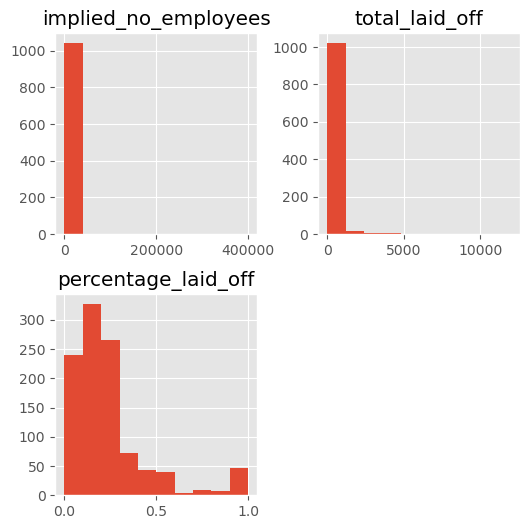

In [282]:
#layoffs[layoffs['implied_no_employees'] == layoffs['implied_no_employees'].max()]
layoffs_nonan[['implied_no_employees', 'total_laid_off', 
               'percentage_laid_off']].hist(figsize  = [6, 6])

In [ ]:
# DATA I WANT:

# no. employees
# revenues / earnings etc

In [11]:
total_layoffs_by_month.head()

total_laid_off
month                     
2020-03-01          9628.0
2020-04-01         26710.0
2020-05-01         25804.0
2020-06-01          7627.0
2020-07-01          7112.0

In [ ]:
## Gather company data from Crunchbase - need paid subscription

In [191]:
companies = list(set(layoffs['company']))
print(len(companies))
companies[:10]

1177


['Pegasystems',
 'Dynamic Signal',
 'Kavak',
 'Lambda School',
 'Teleport',
 'Apartment List',
 'Instructure',
 'Snappy',
 'Hopin',
 'SoFi']

In [494]:
print(companies)

['Pegasystems', 'Dynamic Signal', 'Kavak', 'Lambda School', 'Teleport', 'Apartment List', 'Instructure', 'Snappy', 'Hopin', 'SoFi', 'Cisco', 'Airbnb', 'Moss', 'PayJoy', 'People.ai', 'Kontist', 'Lola', 'Aqgromalin', 'Tidepool', 'ApplyBoard', 'CTO.ai', 'Thriver', 'OrCam', 'BlackBuck', 'Carbon Health', 'Revelate', 'Community', 'Foodpanda', 'Bird', 'TravelBank', 'HOOQ', 'Shipsi', 'Sauce Labs', 'Pear Therapeutics', 'Rubrik', 'Superloop', 'Voyage SMS', 'Gopuff', 'Aura', 'Zipcar', 'Captain Fresh ', 'Triplebyte', 'Aqua Security', 'Rows', 'Shelf Engine', 'Grab', 'CyCognito', 'Skit.ai', 'Simple Feast', 'Artnight', 'Noom', 'Oye Rickshaw', 'Rasa', 'Heroes', 'Kitopi', 'Synthego', 'Xerpa', 'Truiloo', 'WanderJaunt', 'Qualtrics', 'Intuit', 'GoStudent', 'Showpad', 'OneWeb', 'CodeCombat', 'Tomorrow', 'Houzz', 'Parallel Wireless', 'Monzo', 'Momentive', 'GrayMeta', 'InfoSum', 'TripAdvisor', 'Waze', 'Polarr', 'Clear', 'Built In', 'Buy.com / Rakuten', 'WeDoctor', 'TripActions', 'Zak', 'CS Disco', 'SynapseFI

In [192]:
companies_ipo = list(set(layoffs['company'][layoffs['stage']=='IPO']))
len(companies_ipo)

173

In [231]:
companies_ipo = [name.lower() for name in companies_ipo]

In [232]:
companies_ipo[:20]

['pegasystems',
 'thinkific',
 'funding circle',
 'cisco',
 'delivery hero',
 'netflix',
 'splunk',
 'root insurance',
 'vtex',
 'playtika',
 'nutanix',
 'zymergen',
 'teladoc health',
 'bird',
 'laybuy',
 'microsoft',
 'definitive healthcare',
 'pear therapeutics',
 'blend',
 'applovin']

In [217]:
import json
def get_data(path):
    with open(path) as f:
        return json.load(f)
    
ticker_dict = get_data('data/company_tickers.json')

In [219]:
ticker_dict['0']

{'cik_str': 320193, 'ticker': 'AAPL', 'title': 'Apple Inc.'}

In [481]:
tickers = []
co_names = []
ticker_map = {}

for key in ticker_dict:
    #print(key, '->', tickers[key]['ticker'])
    ticker = ticker_dict[key]['ticker']
    co_name = ticker_dict[key]['title'].lower()
    
    ticker_map[co_name] = ticker
    tickers.append(ticker)
    co_names.append(co_name)

In [482]:
ticker_map

{'apple inc.': 'AAPL',
 'microsoft corp': 'MSFT',
 'berkshire hathaway inc': 'BRK-A',
 'taiwan semiconductor manufacturing co ltd': 'TSM',
 'exxon mobil corp': 'XOM',
 'nvidia corp': 'NVDA',
 'unitedhealth group inc': 'UNH',
 'johnson & johnson': 'JNJ',
 'lvmh moet hennessy louis vuitton': 'LVMHF',
 'jpmorgan chase & co': 'AMJ',
 'walmart inc.': 'WMT',
 'mastercard inc': 'MA',
 'spdr s&p 500 etf trust': 'SPY',
 'chevron corp': 'CVX',
 'procter & gamble co': 'PG',
 'home depot, inc.': 'HD',
 'eli lilly & co': 'LLY',
 'alibaba group holding ltd': 'BABAF',
 'novo nordisk a s': 'NONOF',
 'bank of america corp /de/': 'BAC-PQ',
 'merck & co., inc.': 'MRK',
 'asml holding nv': 'ASMLF',
 'abbvie inc.': 'ABBV',
 'coca cola co': 'KO',
 'pfizer inc': 'PFE',
 'broadcom inc.': 'AVGO',
 'thermo fisher scientific inc.': 'TMO',
 'oracle corp': 'ORCL',
 'pepsico inc': 'PEP',
 'costco wholesale corp /new': 'COST',
 'astrazeneca plc': 'AZNCF',
 'novartis ag': 'NVSEF',
 'nike, inc.': 'NKE',
 'toyota motor

In [486]:
layoffs_raw['ticker'] = [ticker_map[co.lower()] if co.lower() in ticker_map else np.nan for co in layoffs_raw['company']]

In [488]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              2040 non-null   object        
 1   location             2040 non-null   object        
 2   industry             2040 non-null   object        
 3   total_laid_off       1411 non-null   float64       
 4   percentage_laid_off  1371 non-null   float64       
 5   date                 2040 non-null   datetime64[ns]
 6   stage                2040 non-null   object        
 7   country              2040 non-null   object        
 8   funds_raised         2040 non-null   float64       
 9   year                 2040 non-null   int64         
 10  multiple             2040 non-null   int64         
 11  ticker               4 non-null      object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 191.4+ KB


In [235]:
ipos = pd.DataFrame({'cos': companies_ipo})

ipos['ticker'] = np.nan
ipos.head()

cos  ticker
0     pegasystems     NaN
1       thinkific     NaN
2  funding circle     NaN
3           cisco     NaN
4   delivery hero     NaN

In [491]:
ipos['ticker'] = [ticker_map[co] if co in ticker_map else np.nan for co in ipos['cos']]

In [493]:
ipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cos     173 non-null    object
 1   ticker  1 non-null      object
dtypes: object(2)
memory usage: 2.8+ KB


In [514]:

'''
Credit: bruhbruhroblox @ github
https://gist.github.com/bruhbruhroblox/dd9d981c8c37983f61e423a45085e063
Company name to ticker using Yahoo Finance API endpoint
'''

def getTicker(company_name):
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    data = res.json()
    
    if data['quotes']:
        company_code = data['quotes'][0]['symbol']
        return company_code
   
    else:
        return 'N/A'

In [511]:
ipos['cos'][2]

'funding circle'

In [515]:
ipos['ticker'] = [getTicker(co) for co in ipos['cos']]
ipos

cos   ticker
0          pegasystems     PEGA
1            thinkific  THNC.TO
2       funding circle    FCH.L
3                cisco     CSCO
4        delivery hero  DHER.DE
..                 ...      ...
168              edgio     EGIO
169  fate therapeutics     FATE
170         cardlytics     CDLX
171             oracle     ORCL
172           cargurus     CARG

[173 rows x 2 columns]

In [519]:
ipos[ipos.ticker=='N/A']

cos ticker
7         root insurance    N/A
11              zymergen    N/A
25                 jd.id    N/A
35   deliveroo australia    N/A
56                 sema4    N/A
63          lending club    N/A
67             homepoint    N/A
110      hippo insurance    N/A
113            forescout    N/A
139              pagbank    N/A
142           goto group    N/A
145             mindbody    N/A
167      rubicon project    N/A

In [498]:
getTicker('Google')

'GOOG'

In [229]:
#ticker_map = pd.DataFrame({, 'co_name': co_names, 'ticker': tickers})
#ticker_map.head()

ticker                                    co_name
0   AAPL                                 apple inc.
1   MSFT                             microsoft corp
2  BRK-B                     berkshire hathaway inc
3    TSM  taiwan semiconductor manufacturing co ltd
4    XOM                           exxon mobil corp

In [173]:
import yfinance as yf

In [174]:
msft = yf.Ticker("MSFT")

In [176]:
msft.fast_info

lazy-loading dict with keys = ['currency', 'exchange', 'timezone', 'shares', 'market_cap', 'last_price', 'previous_close', 'open', 'day_high', 'day_low', 'last_volume', 'fifty_day_average', 'two_hundred_day_average', 'ten_day_average_volume', 'three_month_average_volume', 'year_high', 'year_low', 'year_change']

In [531]:
# stock price 3m before and after layoff?
#hist = msft.history(period="1y")
hist

Open        High         Low       Close  \
Date                                                                        
2022-01-28 00:00:00-05:00  297.442922  305.616335  291.716580  305.398376   
2022-01-31 00:00:00-05:00  306.081986  309.480137  303.525919  308.093140   
2022-02-01 00:00:00-05:00  307.528415  307.746373  302.297431  305.893738   
2022-02-02 00:00:00-05:00  306.755647  312.194673  306.012610  310.550079   
2022-02-03 00:00:00-05:00  306.616927  308.340795  297.175397  298.453430   
...                               ...         ...         ...         ...   
2023-01-23 00:00:00-05:00  241.100006  245.169998  239.649994  242.580002   
2023-01-24 00:00:00-05:00  242.500000  243.949997  240.440002  242.039993   
2023-01-25 00:00:00-05:00  234.479996  243.300003  230.899994  240.610001   
2023-01-26 00:00:00-05:00  243.649994  248.309998  242.000000  248.000000   
2023-01-27 00:00:00-05:00  248.990005  249.830002  246.830002  248.160004   

                             Volume  Dividends  Stock Splits  
Date                                                          
2022-01-28 00:00:00-05:00  49743700        0.0           0.0  
2022-01-31 00:00:00-05:00  46444500        0.0           0.0  
2022-02-01 00:00:00-05:00  40950400        0.0           0.0  
2022-02-02 00:00:00-05:00  36636000        0.0           0.0  
2022-02-03 00:00:00-05:00  43730000        0.0           0.0  
...                             ...        ...           ...  
2023-01-23 00:00:00-05:00  31934000        0.0           0.0  
2023-01-24 00:00:00-05:00  40234400        0.0           0.0  
2023-01-25 00:00:00-05:00  66526600        0.0           0.0  
2023-01-26 00:00:00-05:00  33454500        0.0           0.0  
2023-01-27 00:00:00-05:00  26480800        0.0           0.0  

[251 rows x 7 columns]

In [533]:
earn = msft.earnings

In [532]:
info = msft.info

In [558]:
info

{'zip': '98052-6399', 'sector': 'Technology', 'fullTimeEmployees': 221000, 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. The company operates in three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva, and Skype for Business; Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. The Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related Client Access Licenses; GitHub that provides a collaboration platform and code hosting service for developers; Nuance provides healthcare and enterprise AI solutions; and Azure, a cloud platform. It also offers enterprise su

In [535]:
print(info['sector'])
print(info['industry'])
print(info['fullTimeEmployees'])
print(info['earningsQuarterlyGrowth'])

Technology
Software—Infrastructure
221000
-0.125


In [547]:
len(list(info.values()))

Price data removed from info. Use Ticker.fast_info or history() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Symbol removed from info. You know this already
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed 

155

In [553]:
ex = pd.DataFrame([list(info.values())], columns=list(info.keys()))
#ex.iloc[0] = [list(info.values())]
ex

Price data removed from info. Use Ticker.fast_info or history() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Exchange data removed from info. Use Ticker.fast_info or Ticker.get_history_metadata() instead
Symbol removed from info. You know this already
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed from info. Use Ticker.fast_info or history() instead
Price data removed 

zip      sector  fullTimeEmployees  \
0  98052-6399  Technology             221000   

                                 longBusinessSummary     city         phone  \
0  Microsoft Corporation develops, licenses, and ...  Redmond  425 882 8080   

  state        country companyOfficers                    website  ...  \
0    WA  United States              []  https://www.microsoft.com  ...   

      bid tradeable dividendYield bidSize  dayHigh  coinMarketCapLink  \
0  244.87     False        0.0112     900     None               None   

   regularMarketPrice  preMarketPrice  \
0                None          243.51   

                                  logo_url  trailingPegRatio  
0  https://logo.clearbit.com/microsoft.com            2.0536  

[1 rows x 155 columns]

In [557]:
public_cos = ipos[ipos.ticker!='N/A'].reset_index(drop=True)
public_cos

cos   ticker
0          pegasystems     PEGA
1            thinkific  THNC.TO
2       funding circle    FCH.L
3                cisco     CSCO
4        delivery hero  DHER.DE
..                 ...      ...
155              edgio     EGIO
156  fate therapeutics     FATE
157         cardlytics     CDLX
158             oracle     ORCL
159           cargurus     CARG

[160 rows x 2 columns]

In [563]:
test['ticker'][0]

'PEGA'

In [621]:
cols = ['company', 'ticker', 'sector', 'industry', 'fullTimeEmployees', 
        'profitMargins', 'earningsGrowth', 'earningsQuarterlyGrowth',  
        'recommendationKey', 'totalRevenue', 'totalCash', 'forwardPE', 
        'freeCashflow', 'targetMedianPrice'] #, 'currentPrice', 'marketCap'],

new_df = pd.DataFrame(columns=cols, index=range(0,len(public_cos)))

#test = public_cos[:5]

for i in range(len(public_cos)):
    
    company = public_cos['cos'][i]
    ticker = public_cos['ticker'][i]
    
    yf_data = yf.Ticker(public_cos['ticker'][i])
    info = yf_data.info
          
    try:
    
        sector = info['sector']
        industry = info['industry']
        fullTimeEmployees = info['fullTimeEmployees']
        profitMargins = info['profitMargins']
        earningsGrowth = info['earningsGrowth']
        earningsQuarterlyGrowth = info['earningsQuarterlyGrowth']
        recommendationKey = info['recommendationKey']
        totalRevenue = info['totalRevenue']
        totalCash = info['totalCash']
        forwardPE = info['forwardPE']
        freeCashflow = info['freeCashflow']
        targetMedianPrice = info['targetMedianPrice']
        currentPrice = info['currentPrice']
        marketCap = info['marketCap']
        
        print('The key exists in the dictionary')
        
    except KeyError as error:
        print("The key doesn't exist in the dictionary", 'index = ', str(i)) 
        # also print missing key?
    
    new_df.iloc[i,:] = [company, ticker, sector, industry, fullTimeEmployees, 
                        profitMargins, earningsGrowth, earningsQuarterlyGrowth, 
                        recommendationKey, totalRevenue, totalCash, forwardPE, 
                        freeCashflow, targetMedianPrice]#, currentPrice, marketCap]
    

Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data remov

Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
The key doesn't exist in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
The key doesn't exist in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info

Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data removed from info. Use Ticker.fast_info or history() instead
Market cap removed from info. Use Ticker.fast_info instead
The key exists in the dictionary
Price data remov

In [623]:
# for i in range(len(public_cos)):
    
#     company = public_cos['cos'][i]
#     ticker = public_cos['ticker'][i]
    
#     new_df.iloc[i,0] = company
#     new_df.iloc[i,1] = ticker

In [624]:
new_df

company   ticker                  sector  \
0          pegasystems     PEGA              Technology   
1            thinkific  THNC.TO              Technology   
2       funding circle    FCH.L      Financial Services   
3                cisco     CSCO              Technology   
4        delivery hero  DHER.DE       Consumer Cyclical   
..                 ...      ...                     ...   
155              edgio     EGIO              Technology   
156  fate therapeutics     FATE              Healthcare   
157         cardlytics     CDLX  Communication Services   
158             oracle     ORCL              Technology   
159           cargurus     CARG  Communication Services   

                           industry fullTimeEmployees profitMargins  \
0              Software—Application              6133      -0.33731   
1              Software—Application               450      -0.87031   
2                   Credit Services              1029       0.18804   
3           Communication Equipment             83300       0.21997   
4                   Internet Retail             49417      -0.21792   
..                              ...               ...           ...   
155         Software—Infrastructure              1317      -0.20424   
156                   Biotechnology               542             0   
157            Advertising Agencies               710      -0.50145   
158         Software—Infrastructure            143000       0.13153   
159  Internet Content & Information              1203      -0.00756   

    earningsGrowth earningsQuarterlyGrowth recommendationKey totalRevenue  \
0             None                    None              hold   1237559040   
1             None                    None               buy     48438004   
2           -0.795                  -0.787               buy    185600000   
3           -0.071                  -0.104               buy  52288999424   
4             None                    None               buy   7213700096   
..             ...                     ...               ...          ...   
155           None                    None               buy    250356992   
156           None                    None               buy     68257000   
157           None                    None              hold    298366016   
158         -0.349                   -0.37              hold  44157001728   
159           None                  -0.313               buy   1504093952   

       totalCash  forwardPE freeCashflow targetMedianPrice  
0      275711008  62.967213    159770000                36  
1       95358336     -7.625    -16069208              3.99  
2      292000000   1.996552     30475000             116.5  
3    19783999488  12.665796  10578499584                52  
4     3062000128 -22.234818   -857574976                62  
..           ...        ...          ...               ...  
155     77333000       None    -28278250                 6  
156    568849984  -2.740741   -176060128                71  
157    157038000  -37.63158     22818750                15  
158  11219999744  18.539581   9601750016              84.5  
159    368238016  15.690909    148468128                28  

[160 rows x 14 columns]

In [236]:
fortune_1000 = pd.read_csv('data/Fortune_1000.csv')
fortune_1000.head()

company  rank  rank_change   revenue   profit  \
0             Walmart     1          0.0  572754.0  13673.0   
1              Amazon     2          0.0  469822.0  33364.0   
2               Apple     3          0.0  365817.0  94680.0   
3          CVS Health     4          0.0  292111.0   7910.0   
4  UnitedHealth Group     5          0.0  287597.0  17285.0   

   num. of employees       sector         city state newcomer ceo_founder  \
0          2300000.0    Retailing  Bentonville    AR       no          no   
1          1608000.0    Retailing      Seattle    WA       no          no   
2           154000.0   Technology    Cupertino    CA       no          no   
3           258000.0  Health Care   Woonsocket    RI       no          no   
4           350000.0  Health Care   Minnetonka    MN       no          no   

  ceo_woman profitable prev_rank                  CEO  \
0        no        yes       1.0  C. Douglas McMillon   
1        no        yes       2.0      Andrew R. Jassy   
2        no        yes       3.0      Timothy D. Cook   
3       yes        yes       4.0          Karen Lynch   
4        no        yes       5.0      Andrew P. Witty   

                         Website Ticker Market Cap  
0  https://www.stock.walmart.com    WMT     352037  
1                 www.amazon.com   AMZN    1202717  
2                  www.apple.com   AAPL    2443962  
3      https://www.cvshealth.com    CVS     125204  
4      www.unitedhealthgroup.com    UNH     500468

In [239]:
layoffs_comb = pd.concat([layoffs, fortune_1000], axis=1, keys='company', join='inner')
layoffs_comb.head()

c                                                                  \
     company         location    industry total_laid_off percentage_laid_off   
0     Google      SF Bay Area    Consumer        12000.0                0.06   
1    Wayfair           Boston      Retail         1750.0                0.10   
2     Swiggy        Bengaluru        Food          380.0                0.06   
3  MediBuddy        Bengaluru  Healthcare          200.0                 NaN   
4  Vox Media  Washington D.C.       Media          130.0                0.07   

                                                                      o  ...  \
         date     stage        country funds_raised             company  ...   
0  2023-01-20       IPO  United States         26.0             Walmart  ...   
1  2023-01-20       IPO  United States       1700.0              Amazon  ...   
2  2023-01-20   Unknown          India       3600.0               Apple  ...   
3  2023-01-20  Acquired          India        192.0          CVS Health  ...   
4  2023-01-20  Series F  United States        307.0  UnitedHealth Group  ...   

                                                             \
  state newcomer ceo_founder ceo_woman profitable prev_rank   
0    AR       no          no        no        yes       1.0   
1    WA       no          no        no        yes       2.0   
2    CA       no          no        no        yes       3.0   
3    RI       no          no       yes        yes       4.0   
4    MN       no          no        no        yes       5.0   

                                                                         
                   CEO                        Website Ticker Market Cap  
0  C. Douglas McMillon  https://www.stock.walmart.com    WMT     352037  
1      Andrew R. Jassy                 www.amazon.com   AMZN    1202717  
2      Timothy D. Cook                  www.apple.com   AAPL    2443962  
3          Karen Lynch      https://www.cvshealth.com    CVS     125204  
4      Andrew P. Witty      www.unitedhealthgroup.com    UNH     500468  

[5 rows x 27 columns]

In [245]:
cb_data = pd.read_csv("/Users/natalyadoris/flatiron_datascience_flex/phase_3/dsc-project-3/data/investments_VC.csv", 
                      encoding="ISO-8859-1")
cb_data.head()

permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list        market   \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      status country_code state_code         region  ...  \
0          17,50,000    acquired          USA         NY  New York City  ...   
1          40,00,000   operating          USA         CA    Los Angeles  ...   
2             40,000   operating          EST        NaN        Tallinn  ...   
3          15,00,000   operating          GBR        NaN         London  ...   
4             60,000   operating          USA         TX         Dallas  ...   

  secondary_market  product_crowdfunding round_A round_B round_C  round_D  \
0              0.0                   0.0     0.0     0.0     0.0      0.0   
1              0.0                   0.0     0.0     0.0     0.0      0.0   
2              0.0                   0.0     0.0     0.0     0.0      0.0   
3              0.0                   0.0     0.0     0.0     0.0      0.0   
4              0.0                   0.0     0.0     0.0     0.0      0.0   

  round_E round_F  round_G  round_H  
0     0.0     0.0      0.0      0.0  
1     0.0     0.0      0.0      0.0  
2     0.0     0.0      0.0      0.0  
3     0.0     0.0      0.0      0.0  
4     0.0     0.0      0.0      0.0  

[5 rows x 39 columns]

In [246]:
layoffs_comb2 = pd.concat([layoffs, cb_data], axis=1, keys=['company', 'name'], join='inner')
layoffs_comb2.head()

company                                                                  \
     company         location    industry total_laid_off percentage_laid_off   
0     Google      SF Bay Area    Consumer        12000.0                0.06   
1    Wayfair           Boston      Retail         1750.0                0.10   
2     Swiggy        Bengaluru        Food          380.0                0.06   
3  MediBuddy        Bengaluru  Healthcare          200.0                 NaN   
4  Vox Media  Washington D.C.       Media          130.0                0.07   

                                                     \
         date     stage        country funds_raised   
0  2023-01-20       IPO  United States         26.0   
1  2023-01-20       IPO  United States       1700.0   
2  2023-01-20   Unknown          India       3600.0   
3  2023-01-20  Acquired          India        192.0   
4  2023-01-20  Series F  United States        307.0   

                              name  ...                                        \
                         permalink  ... secondary_market product_crowdfunding   
0            /organization/waywire  ...              0.0                  0.0   
1  /organization/tv-communications  ...              0.0                  0.0   
2    /organization/rock-your-paper  ...              0.0                  0.0   
3   /organization/in-touch-network  ...              0.0                  0.0   
4   /organization/r-ranch-and-mine  ...              0.0                  0.0   

                                                                   
  round_A round_B round_C round_D round_E round_F round_G round_H  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 48 columns]

In [247]:
layoffs.shape

(1411, 9)

In [169]:
layoffs.head()

company         location    industry  total_laid_off  \
0     Google      SF Bay Area    Consumer         12000.0   
1    Wayfair           Boston      Retail          1750.0   
2     Swiggy        Bengaluru        Food           380.0   
3  MediBuddy        Bengaluru  Healthcare           200.0   
4  Vox Media  Washington D.C.       Media           130.0   

   percentage_laid_off        date     stage        country  funds_raised  
0                 0.06  2023-01-20       IPO  United States          26.0  
1                 0.10  2023-01-20       IPO  United States        1700.0  
2                 0.06  2023-01-20   Unknown          India        3600.0  
3                  NaN  2023-01-20  Acquired          India         192.0  
4                 0.07  2023-01-20  Series F  United States         307.0

In [ ]:
layoffs_reg = layoffs[['location', 'industry', 'stage', 'country']]

In [ ]:
X = layoffs.drop(["total_laid_off", "percentage_laid_off"], axis=1)
y = layoffs["total_laid_off"]

In [15]:
pd.to_datetime(total_layoffs_by_month.index)

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='month', freq=None)

In [16]:
df_monthly = total_layoffs_by_month

# index needs to be DatetimeIndex named "date"
if isinstance(df_monthly.index, pd.DatetimeIndex):
    df_monthly.index.name = 'date'
else:
    df_monthly.index = pd.to_datetime(df_monthly.index)
    df_monthly.index.name = 'date'
    
    #df_monthly.rename(columns={'index':'date'}, inplace=True)
    #df_monthly.set_index('month', inplace=True)

In [17]:
isinstance(df_monthly.index, pd.DatetimeIndex)

True

In [18]:
# setting frequency to monthly and backfilling any missing values

#df_monthly = df_monthly.asfreq('MS')
df_monthly = df_monthly.fillna(df_monthly.bfill())
df_monthly = df_monthly['total_laid_off'].resample('MS').mean()

In [19]:
df_monthly.head()

date
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64

In [42]:
df_weekly = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_weekly.index, pd.DatetimeIndex):
    df_weekly.index.name = 'date'
else:
    df_weekly.rename(columns={'index':'date'}, inplace=True)
    df_weekly.set_index('day', inplace=True)
    
    
df_weekly = df_weekly['total_laid_off'].resample('W').sum()
df_weekly.head()

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

<AxesSubplot: >

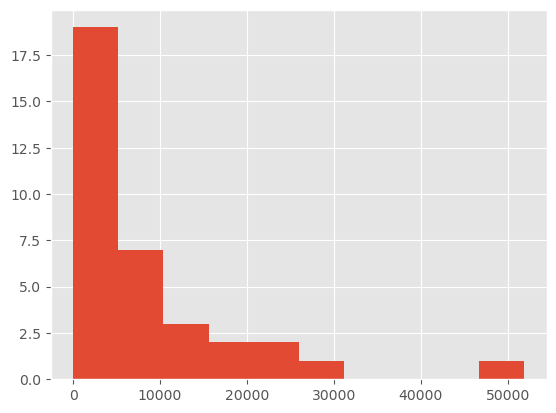

In [45]:
df_monthly.hist()

<AxesSubplot: >

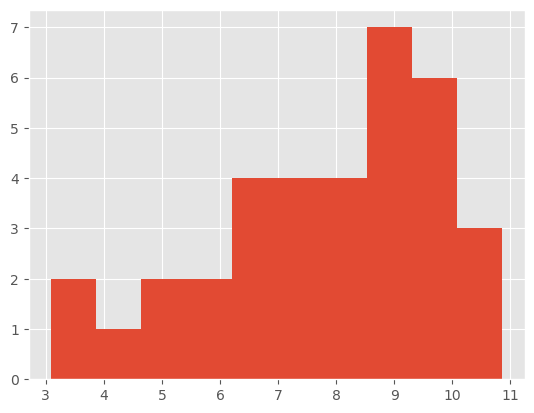

In [46]:
np.log(df_monthly).hist()

In [47]:
df_log = np.log(df_monthly)
df_log.head()

month
2020-03-01     9.172431
2020-04-01    10.192793
2020-05-01    10.158285
2020-06-01     8.939450
2020-07-01     8.869539
Freq: MS, Name: total_laid_off, dtype: float64

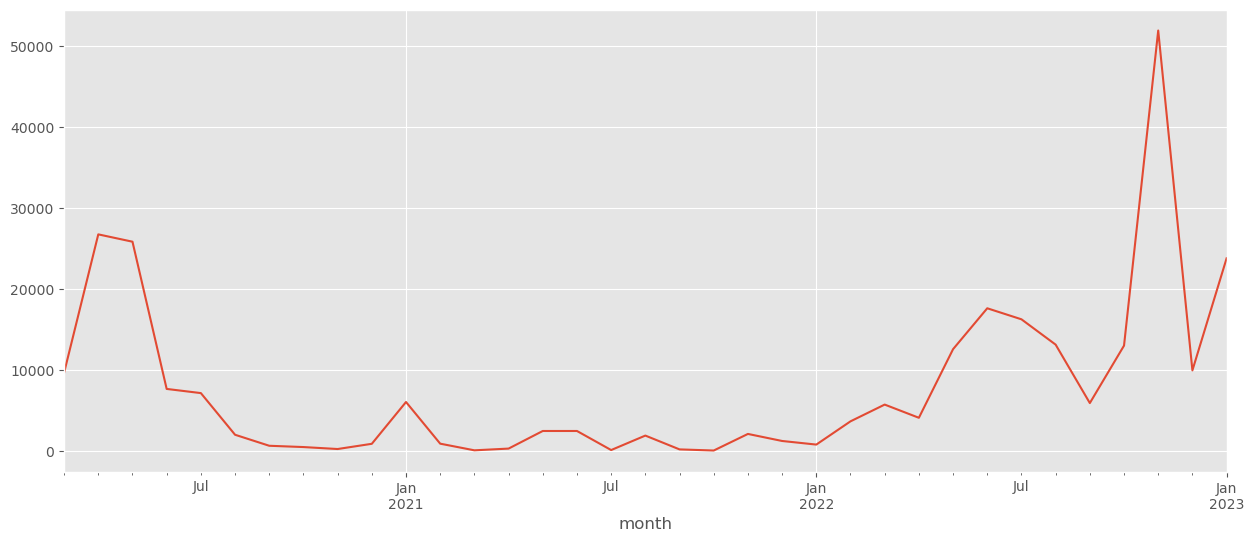

month
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64


In [48]:
df_monthly.plot(figsize=(15, 6))
plt.show()
print(df_monthly.head())

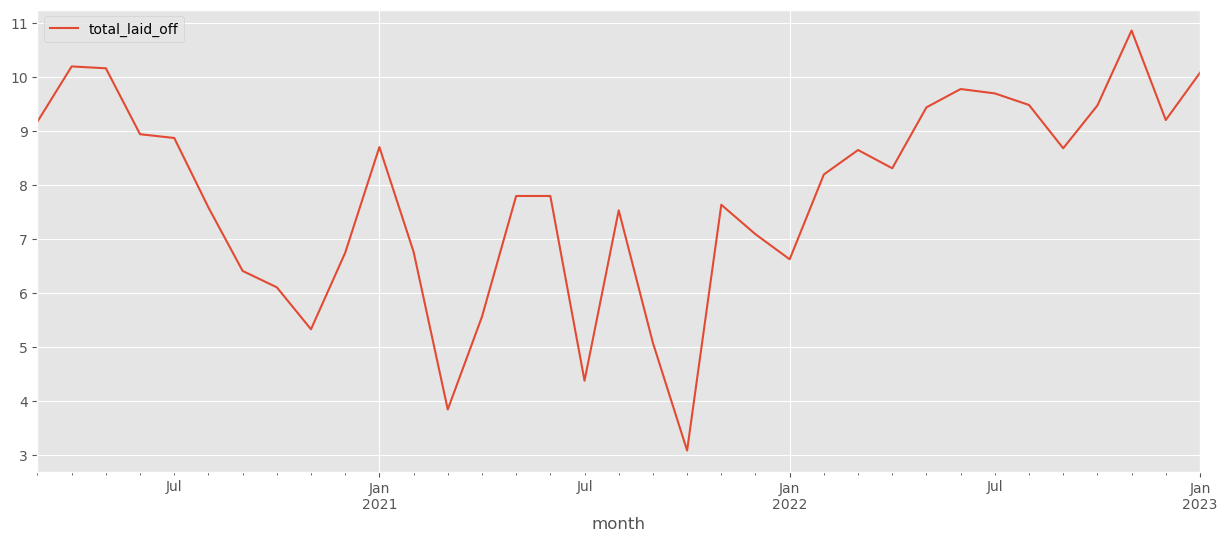

            total_laid_off
month                     
2020-03-01          9628.0
2020-04-01         26710.0
2020-05-01         25804.0
2020-06-01          7627.0
2020-07-01          7112.0


In [180]:
df_log.plot(figsize=(15, 6))
plt.show()
print(df.head())

# Appendix - Extra Code / Do Not Run

### Adding Exog

In [203]:
# start date needs to be on or after 3/15/2020
# end date needs to be on or before 12/30/2022
display(df.head())
display(df.tail())
display(df_weekly.head())
display(df_weekly.tail())

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

date
2022-12-02   -0.000331
2022-12-09    0.072500
2022-12-16   -0.015000
2022-12-23   -0.049500
2022-12-30   -0.221000
Freq: W-FRI, Name: bg_posts, dtype: float64

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

day
2022-12-18     1989.0
2022-12-25      836.0
2023-01-01      150.0
2023-01-08    18392.0
2023-01-15     5358.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

In [204]:
df_layoffs = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_layoffs.index, pd.DatetimeIndex):
    df_layoffs.index.name = 'date'
else:
    df_layoffs.rename(columns={'index':'date'}, inplace=True)
    df_layoffs.set_index('day', inplace=True)
    
    
df_layoffs = df_layoffs['total_laid_off'].resample('W-FRI').sum()
df_layoffs.head()

day
2020-03-13     109.0
2020-03-20    1315.0
2020-03-27    5473.0
2020-04-03    7480.0
2020-04-10    6742.0
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [205]:
df_postings = df['2020-03-13':]
df_postings.head()

date
2020-03-13    0.0208
2020-03-20    0.0572
2020-03-27   -0.0760
2020-04-03   -0.2180
2020-04-10   -0.3020
Freq: W-FRI, Name: bg_posts, dtype: float64

In [ ]:
df_log_layoffs = df_layoffs[:'2023-01-01']
df_layoffs.tail()

In [214]:
df_log_layoffs = np.log(df_layoffs[:'2023-01-01']).fillna(value=0)

day
2022-12-02    2.143833
2022-12-09    2.167912
2022-12-16    2.031638
2022-12-23    1.906371
2022-12-30    1.611563
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [218]:
mod_exog = sm.tsa.statespace.SARIMAX(endog=df_postings,
                                     exog=df_layoffs,
                                     order=order_52,
                                     seasonal_order=seasonal_order_52).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.87238D-01    |proj g|=  4.61113D-01

At iterate    5    f= -8.15711D-01    |proj g|=  2.05640D-01

At iterate   10    f= -8.15890D-01    |proj g|=  4.44269D-02

At iterate   15    f= -8.15944D-01    |proj g|=  3.65224D-03

At iterate   20    f= -8.15944D-01    |proj g|=  1.77664D-03

At iterate   25    f= -8.15954D-01    |proj g|=  1.91002D-03

At iterate   30    f= -8.15959D-01    |proj g|=  1.20183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

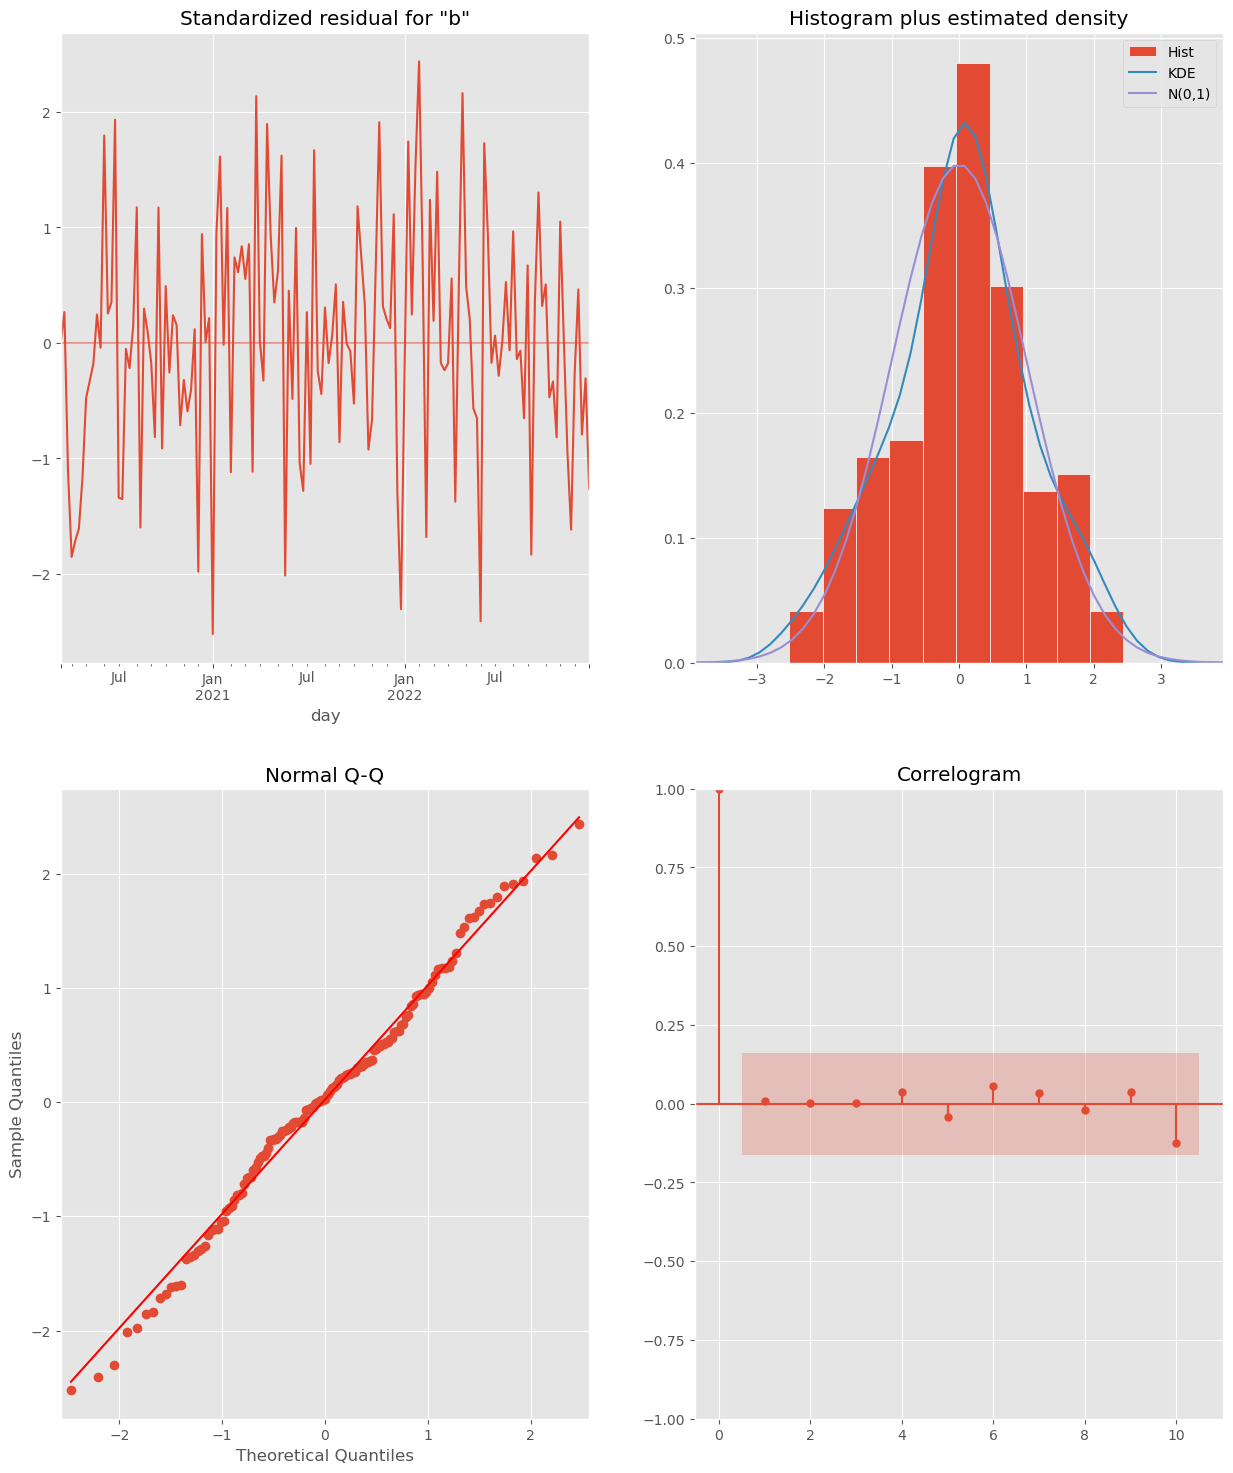

In [219]:
mod_exog.plot_diagnostics(figsize=(15, 18))
plt.show()

In [220]:
mod_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            bg_posts   No. Observations:                  147
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                 119.946
Date:                             Fri, 20 Jan 2023   AIC                           -229.892
Time:                                     17:24:40   BIC                           -214.940
Sample:                                 03-13-2020   HQIC                          -223.817
                                      - 12-30-2022                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_laid_off     0.0130      0.014      0.904      0.366      -0.015       0.041
ar.L1              0.9524      0.026     36.804      0.000       0.902       1.003
ma.L1             -0.4495      0.076     -5.947      0.000      -0.598      -0.301
ar.S.L52           0.2168      0.092      2.348      0.019       0.036       0.398
sigma2             0.0111      0.001      8.208      0.000       0.008       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.92   Prob(JB):                         0.84
Heteroskedasticity (H):               1.00   Skew:                            -0.11
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
pred = mod_exog.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=False, exog=df_layoffs['2022-01-07':])
pred_conf = pred.conf_int()

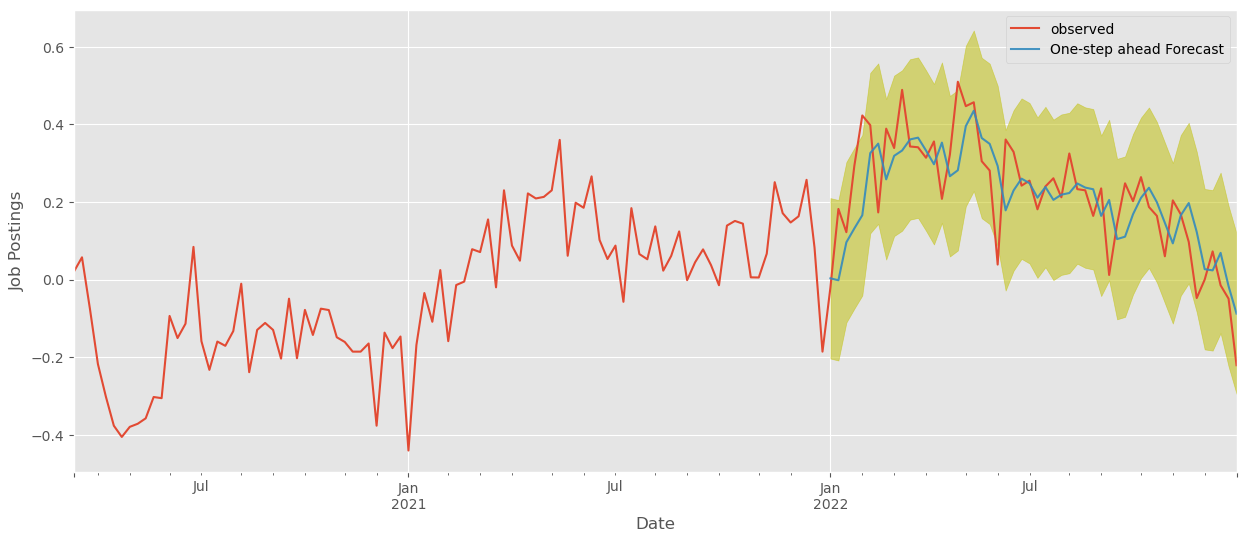

In [226]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df_postings.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [227]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df_layoffs['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.09


Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Target)')

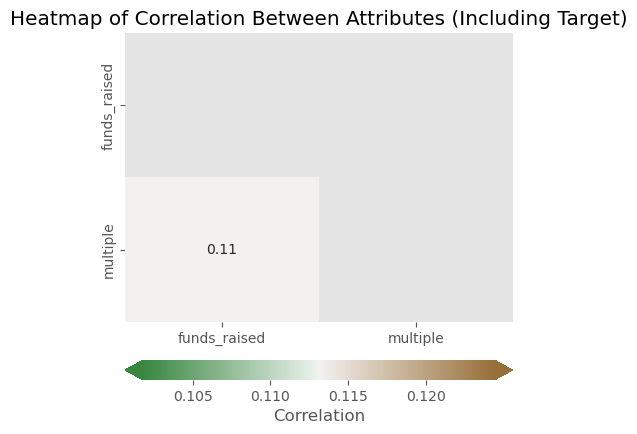

In [1008]:
# check correlations

heatmap_data = pd.concat([X, y], axis=1)
h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(5, 5))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Target)')

https://github.com/statsmodels/statsmodels/issues/4284

EXOG ISSUES

In [224]:
forecast = mod_exog.predict(start=df.shape[0], end=df.shape[0] + 8, exog=df_layoffs)
forecast

ValueError: Provided exogenous values are not of the appropriate shape. Required (18, 1), got (147,).

In [221]:
# Get forecast 1yr ahead in future
prediction = mod_exog.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [222]:
forecast = mod_exog.forecast(steps=52)

fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')

plt.legend();

ValueError: Provided exogenous values are not of the appropriate shape. Required (52, 1), got (147,).

In [ ]:
    
    # need to add try / except for if row dosnt exist
    
#     for col in cols:
        
#         for var in col_vars:
        
#             if col in info.keys():

#                 var = info[col]

#             else:

#                 var = 'N/A'
                
#             lst.append(var)

# sector = 0
# industry = 0
# fullTimeEmployees = 0
# profitMargins = 0
# earningsGrowth = 0
# earningsQuarterlyGrowth = 0
# recommendationKey = 0
# totalRevenue = 0
# totalCash = 0
# forwardPE = 0
# freeCashflow = 0
# targetMedianPrice = 0

# col_vars = [sector, industry, fullTimeEmployees, profitMargins, 
#             earningsGrowth, earningsQuarterlyGrowth, recommendationKey, 
#             totalRevenue, totalCash, forwardPE, freeCashflow, 
#             targetMedianPrice]
  

#### ARMA Test

In [580]:
data_diff = df.diff().dropna()
data_diff

date
2020-01-17    0.158700
2020-01-24   -0.213400
2020-01-31    0.113700
2020-02-07   -0.112600
2020-02-14    0.299300
                ...   
2022-12-02    0.047469
2022-12-09    0.072831
2022-12-16   -0.087500
2022-12-23   -0.034500
2022-12-30   -0.171500
Freq: W-FRI, Name: bg_posts, Length: 155, dtype: float64

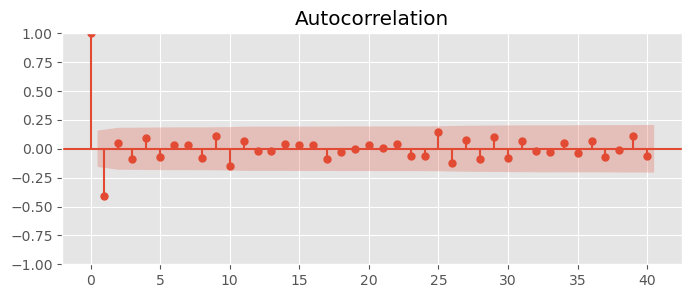

In [594]:
# Plot the ACF
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags=40);

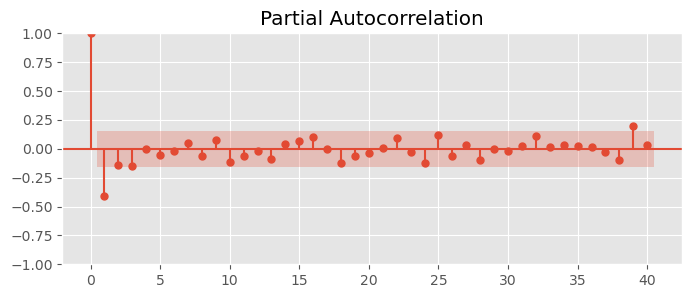

In [595]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=40);

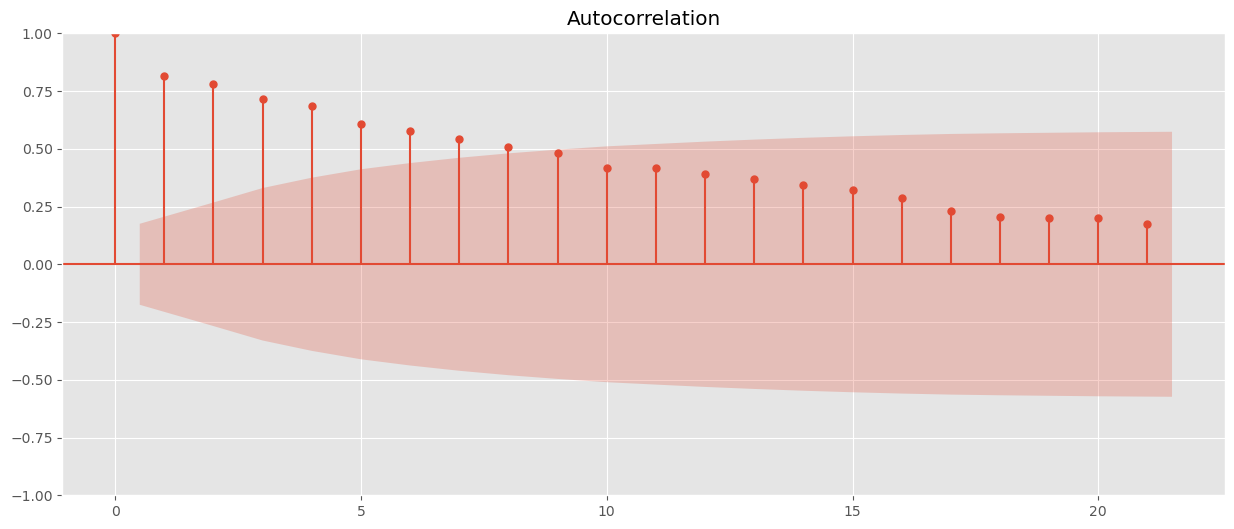

In [192]:
plot_acf(train); # period of 9-10 weeks

In [592]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(1,1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  67.705
Date:                Thu, 19 Jan 2023   AIC                           -131.410
Time:                        17:58:28   BIC                           -125.337
Sample:                    01-17-2020   HQIC                          -128.943
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6679      0.058    -11.597      0.000      -0.781      -0.555
sigma2         0.0242      0.003      8.084      0.000       0.018       0.030
Ljung-Box (L1) (Q):                  10.48   Jarque-

In [601]:
# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(0,0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 120.994
Date:                Thu, 19 Jan 2023   AIC                           -235.987
Time:                        18:03:07   BIC                           -226.857
Sample:                    01-17-2020   HQIC                          -232.279
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.172      0.863      -0.009       0.008
ma.L1         -0.5080      0.064     -7.903      0.000      -0.634      -0.382
sigma2         0.0123      0.001      8.909      0.0

## Time Series ARMA / cross val

In [ ]:
# cross validation split - will run on ARIMA models

In [92]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84] [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13

In [93]:
train_with_ind = train.reset_index()

In [185]:
order_52

(1, 0, 1)

In [94]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 0, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.11623070392021657
0.1658068259880681
0.18453464278901135
0.1281475316229865
0.37522835264206783


In [190]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.21855766439680074
0.19926201742447877
0.09911119738964623
0.10524074295630546
0.3981136068001826


In [189]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.30261965367816046
0.1954849863183548
0.10282301812443947
0.10566157420918747
0.3873463613596733


Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term

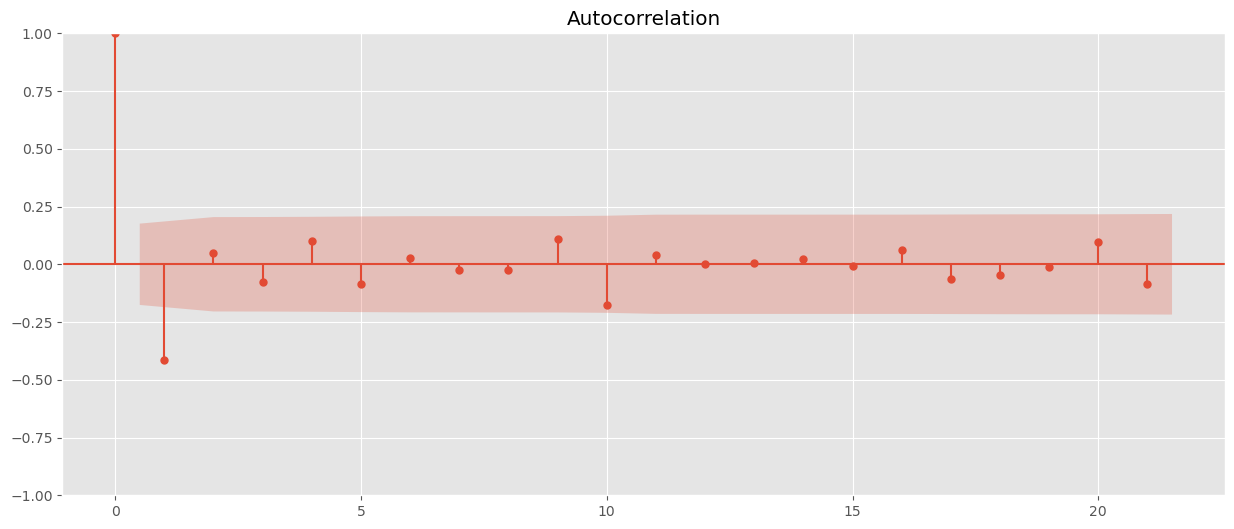

In [193]:
plot_acf(train.diff().dropna()); # 1 lag

- A sharp drop after lag "k" suggests an AR-k model. In this case, k=1
- A gradual decline suggests an MA.

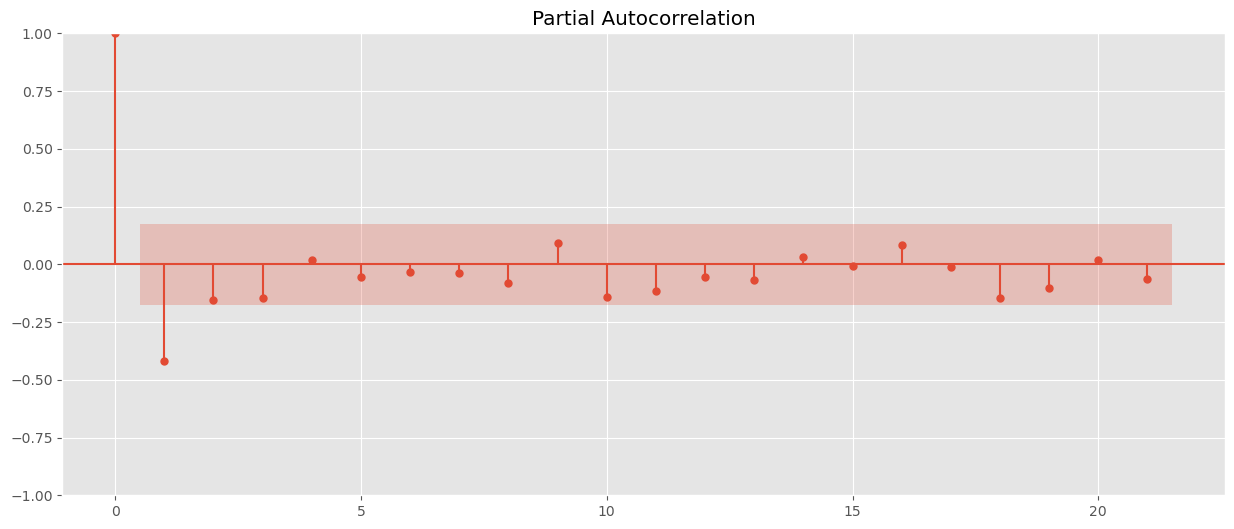

In [191]:
plot_pacf(train.diff().dropna()); 

In [96]:
print(order)
seasonal_order

(1, 0, 1)


(1, 0, 0, 52)

In [131]:
# sari_mod = sm.tsa.statespace.SARIMAX(train,
#                                      order=order,
#                                      seasonal_order=seasonal_order,
#                                      enforce_stationarity=True,
#                                      enforce_invertibility=True).fit()

In [130]:
# display(sari_mod.summary())
# sari_mod.plot_diagnostics(figsize=(15, 18))
# plt.show()

Train / val on Sarima model

In [ ]:
split = TimeSeriesSplit()

In [136]:
# dynamic
errors = []

for train_ind, val_ind in split.split(train_with_ind):
    sarimax = sm.tsa.statespace.SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                                        order=order,
                                        seasonal_order=seasonal_order,
                                        enforce_stationarity=True,
                                        enforce_invertibility=True).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1], dynamic=True)
    true = train_with_ind.iloc[val_ind, -1]
    error = np.sqrt(mean_squared_error(true, preds))
    errors.append(error)
    
print(errors)

[0.16725511758360487, 0.14395392598863074, 0.15686205745801654, 0.11640142096106322, 0.3239794163805492]


In [ ]:
print(errors)

In [138]:
# static / one step ahead
errors = []
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = sm.tsa.statespace.SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                                        order=order,
                                        seasonal_order=seasonal_order,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1], dynamic=True)
    true = train_with_ind.iloc[val_ind, -1]
    error = np.sqrt(mean_squared_error(true, preds))
    errors.append(error)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

 This problem is unconstrained.



At iterate    5    f= -3.17669D-01    |proj g|=  6.02107D-01

At iterate   10    f= -3.31166D-01    |proj g|=  4.62468D-01

At iterate   15    f= -3.34393D-01    |proj g|=  3.22404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.066D-05  -3.344D-01
  F = -0.33439304746691451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.42774D-01    |proj g|=  1.02686D+00


 This problem is unconstrained.



At iterate    5    f= -3.80381D-01    |proj g|=  2.73700D+00

At iterate   10    f= -4.09324D-01    |proj g|=  5.12258D-01

At iterate   15    f= -4.32449D-01    |proj g|=  1.08042D-01

At iterate   20    f= -4.32582D-01    |proj g|=  2.28824D-02

At iterate   25    f= -4.32616D-01    |proj g|=  2.70927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   4.050D-05  -4.326D-01
  F = -0.43261644494866996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[0.18590659615007044,
 0.14090778202625834,
 0.18078085547767916,
 0.11392760504509068,
 0.32896169706255]

In [139]:
print(errors)

[0.18590659615007044, 0.14090778202625834, 0.18078085547767916, 0.11392760504509068, 0.32896169706255]


In [96]:
train.tail()

date
2022-04-29    0.510
2022-05-06    0.447
2022-05-13    0.457
2022-05-20    0.305
2022-05-27    0.281
Freq: W-FRI, Name: bg_posts, dtype: float64

In [140]:
#valid = train[val_ind[0]:]

# y_hat_train = sarimax.predict(typ='levels')
# y_hat_val = sarimax.predict(start=val_ind[0], end=val_ind[-1],typ='levels')

# fig, ax = plt.subplots()
# ax.plot(train, label='train')
# ax.plot(valid, label='validation') # valid
# ax.plot(y_hat_train, label='train_pred')
# ax.plot(y_hat_val, label='val_pred')

# plt.legend();

In [141]:
# # Let's zoom in on validation
# fig, ax = plt.subplots()

# ax.plot(valid, label='true')
# ax.plot(y_hat_val, label='pred')

# plt.legend();

In [105]:
# print(np.sqrt(mean_squared_error(valid, y_hat_val)))
# print(np.sqrt(mean_squared_error(train, y_hat_train)))

0.12100707023898231
0.10948173385866404


In [142]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order,
                                     enforce_stationarity=True,
                                     enforce_invertibility=True).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


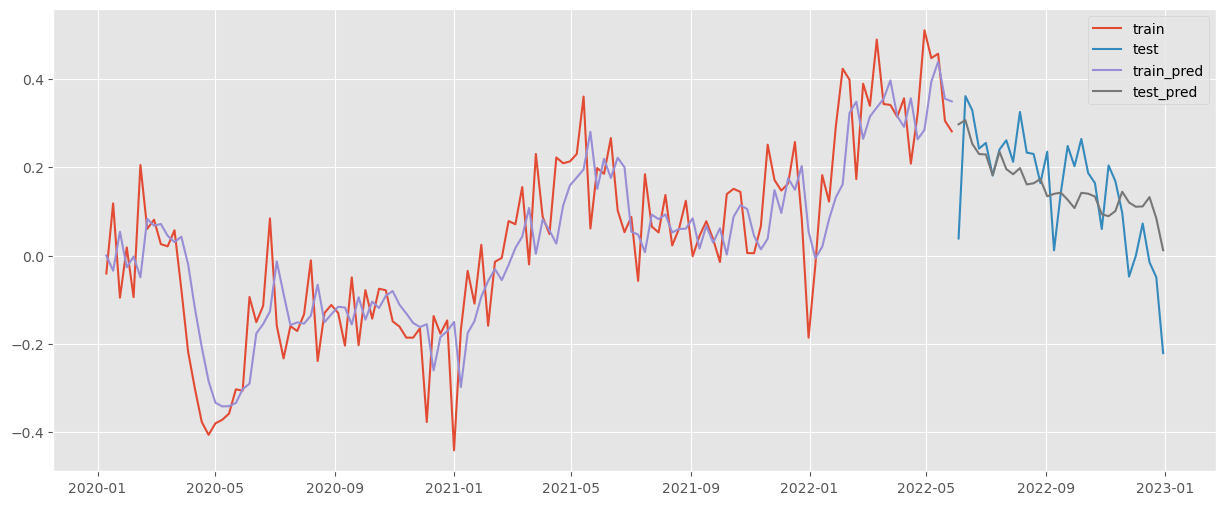

In [143]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels', dynamic=True)

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [61]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [62]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=df,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40399D-01    |proj g|=  2.26146D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     16      1     0     0   2.261D-04  -1.404D-01
  F = -0.14039867915566170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-41.80438789656645
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0       

 This problem is unconstrained.



At iterate   10    f= -1.51941D-01    |proj g|=  1.00551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     16      1     0     0   9.248D-05  -1.519D-01
  F = -0.15194065710788707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 1, 52): AIC Calculated=-43.405485017660766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28667D-02    |proj g|=  1.53860D+00

At iterate    5    f=  6.13551D-02    |proj g|=  1.09426D-06

 

 This problem is unconstrained.


ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=21.142788765382164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48267D-01    |proj g|=  3.14050D+00


 This problem is unconstrained.



At iterate    5    f=  5.41722D-02    |proj g|=  6.27420D-02

At iterate   10    f=  5.39000D-02    |proj g|=  9.69997D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     16      1     0     0   9.700D-06   5.390D-02
  F =   5.3899981440039199E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=20.81679420929223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42242D-01    |proj g|=  1.78347D-01


 This problem is unconstrained.



At iterate    5    f= -1.42620D-01    |proj g|=  9.14297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   6.605D-07  -1.426D-01
  F = -0.14262041796551489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-40.497570405240644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38915D-01    |proj g|=  3.90152D-01


 This problem is unconstrained.



At iterate    5    f= -1.44182D-01    |proj g|=  1.74486D-01

At iterate   10    f= -1.48081D-01    |proj g|=  5.01669D-01

At iterate   15    f= -1.71927D-01    |proj g|=  6.20964D-03

At iterate   20    f= -1.72682D-01    |proj g|=  9.75467D-03

At iterate   25    f= -1.72939D-01    |proj g|=  1.06627D-02

At iterate   30    f= -1.72967D-01    |proj g|=  6.71227D-03

At iterate   35    f= -1.72972D-01    |proj g|=  1.61381D-03

At iterate   40    f= -1.72973D-01    |proj g|=  4.04139D-04

At iterate   45    f= -1.72973D-01    |proj g|=  3.21192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     51   

 This problem is unconstrained.



At iterate    5    f=  5.42982D-02    |proj g|=  2.17962D-02

At iterate   10    f=  5.39000D-02    |proj g|=  3.30572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     17      1     0     0   2.992D-05   5.390D-02
  F =   5.3899981474985967E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=20.81679422019562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48267D-01    |proj g|=  3.14050D+00


 This problem is unconstrained.



At iterate    5    f=  5.39037D-02    |proj g|=  1.15984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   8.864D-06   5.390D-02
  F =   5.3899981473344932E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=22.81679421968362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50383D-01    |proj g|=  1.81963D+00

At iterate    5    f= -4.00013D-01    |proj g|=  2.94646D-01

At 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -4.01631D-01    |proj g|=  4.97785D-01

At iterate   10    f= -4.19332D-01    |proj g|=  1.91665D-01

At iterate   15    f= -4.20717D-01    |proj g|=  8.76351D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   4.993D-05  -4.207D-01
  F = -0.42071720512124228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-125.26376799782759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     32      1     0     0   2.815D-05  -1.338D-01
  F = -0.13380658717496435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-37.74765519858888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.85880D-02    |proj g|=  1.06330D+00

At iterate    5    f= -1.30808D-01    |proj g|=  1.42326D-01

At iterate   10    f= -1.33868D-01    |proj g|=  2.93721D-03

At

 This problem is unconstrained.



At iterate   10    f= -4.12520D-01    |proj g|=  8.00577D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.006D-06  -4.125D-01
  F = -0.41251971117187747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-122.70614988562576
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50383D-01    |proj g|=  1.81963D+00


 This problem is unconstrained.



At iterate    5    f= -4.03479D-01    |proj g|=  5.91355D-01

At iterate   10    f= -4.15949D-01    |proj g|=  1.54487D-02

At iterate   15    f= -4.17500D-01    |proj g|=  3.75863D-01

At iterate   20    f= -4.28931D-01    |proj g|=  5.15442D-02

At iterate   25    f= -4.30749D-01    |proj g|=  2.71269D-02

At iterate   30    f= -4.31156D-01    |proj g|=  2.23399D-02

At iterate   35    f= -4.31228D-01    |proj g|=  1.27756D-02

At iterate   40    f= -4.31239D-01    |proj g|=  7.37215D-03

At iterate   45    f= -4.31241D-01    |proj g|=  1.11046D-04

At iterate   50    f= -4.31241D-01    |proj g|=  7.98064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.64202D-02    |proj g|=  1.07709D+00

At iterate    5    f= -1.29619D-01    |proj g|=  1.33454D-01

At iterate   10    f= -1.33815D-01    |proj g|=  2.88217D-02

At iterate   15    f= -1.33883D-01    |proj g|=  5.51474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   5.515D-05  -1.339D-01
  F = -0.13388344332821206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0

 This problem is unconstrained.



At iterate    5    f= -1.30901D-01    |proj g|=  1.43991D-01

At iterate   10    f= -1.33757D-01    |proj g|=  1.65486D-02

At iterate   15    f= -1.33883D-01    |proj g|=  7.61857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.200D-05  -1.339D-01
  F = -0.13388339777523345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-33.771620105872834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -6.90367D-01    |proj g|=  1.90289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   7.475D-06  -6.904D-01
  F = -0.69036725761692341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-211.3945843764801
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96388D-01    |proj g|=  2.84435D+00

At iterate    5    f= -3.29214D-01    |proj g|=  1.87228D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     29      1     0     0   3.211D-04  -3.292D-01
  F = -0.32921425134848331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-100.71484642072679
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29199D-01    |proj g|=  1.32453D-01

At iterate    5    f= -3.57544D-01    |proj g|=  1.24111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     19      1     0     0   3.256D-04  -3.576D-01
  F = -0.35761504171511416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 52): AIC Calculated=-107.57589301511561
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

 This problem is unconstrained.


At iterate   10    f= -6.93019D-01    |proj g|=  2.23694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   1.485D-05  -6.930D-01
  F = -0.69301872214144311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-212.22184130813025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63340D-01    |proj g|=  1.93244D-01


 This problem is unconstrained.



At iterate    5    f= -6.91903D-01    |proj g|=  5.74749D-03

At iterate   10    f= -6.92545D-01    |proj g|=  9.56858D-02

At iterate   15    f= -6.93588D-01    |proj g|=  2.98666D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   2.927D-06  -6.936D-01
  F = -0.69359148546564164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 1, 52): AIC Calculated=-210.4005434652802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -3.57571D-01    |proj g|=  2.33972D-02

At iterate   10    f= -3.57615D-01    |proj g|=  3.22859D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     19      1     0     0   9.712D-05  -3.576D-01
  F = -0.35761505060241261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-107.57589578795273
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29199D-01    |proj g|=  1.32453D-01


 This problem is unconstrained.



At iterate    5    f= -3.57601D-01    |proj g|=  4.53462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   5.043D-05  -3.576D-01
  F = -0.35761504637058278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-105.57589446762182
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75169D-01    |proj g|=  2.54278D-02

At iterate    5    f= -7.75504D-01    |proj g|=  4.77998D-04

 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.96358D-01    |proj g|=  1.07187D-02

At iterate   10    f= -7.96469D-01    |proj g|=  9.63245D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.632D-06  -7.965D-01
  F = -0.79646925325065687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-242.49840701420493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93627D-01    |proj g|=  1.23463D-01

A

 This problem is unconstrained.



At iterate   10    f= -3.93802D-01    |proj g|=  1.37918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     19      1     0     0   1.557D-04  -3.938D-01
  F = -0.39380188647585446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-118.8661885804666


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93627D-01    |proj g|=  1.25489D-01

At iterate    5    f= -4.21083D-01    |proj g|=  8.60838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   1.062D-05  -4.211D-01
  F = -0.42111750218689648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-125.3886606823117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.



At iterate    5    f= -7.98685D-01    |proj g|=  7.47048D-02

At iterate   10    f= -7.98750D-01    |proj g|=  8.50735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   6.335D-06  -7.987D-01
  F = -0.79874974501756824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-243.2099204454813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75169D-01    |proj g|=  1.69167D-01


 This problem is unconstrained.



At iterate    5    f= -7.97721D-01    |proj g|=  9.17240D-03

At iterate   10    f= -7.97847D-01    |proj g|=  6.87711D-02

At iterate   15    f= -7.97950D-01    |proj g|=  8.46778D-02

At iterate   20    f= -7.98973D-01    |proj g|=  1.43566D-01

At iterate   25    f= -7.99518D-01    |proj g|=  3.59768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   6.373D-05  -7.995D-01
  F = -0.79951808196699869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-241.4496415737036
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -4.21005D-01    |proj g|=  3.70582D-02

At iterate   10    f= -4.21116D-01    |proj g|=  9.29002D-04

At iterate   15    f= -4.21118D-01    |proj g|=  6.94547D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     21      1     0     0   6.945D-05  -4.211D-01
  F = -0.42111750288852473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 52): AIC Calculated=-125.38866090121971
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -4.21092D-01    |proj g|=  8.83715D-03

At iterate   10    f= -4.21107D-01    |proj g|=  2.93489D-02

At iterate   15    f= -4.21118D-01    |proj g|=  2.81573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.816D-05  -4.211D-01
  F = -0.42111750365934669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-123.38866114171617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.36640D-01    |proj g|=  3.81546D-04

At iterate   10    f= -7.36641D-01    |proj g|=  6.43574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.952D-06  -7.366D-01
  F = -0.73664066341765222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-223.8318869863075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.57541D-01    |proj g|=  3.49371D-02

At

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     21      1     0     0   2.826D-04  -3.576D-01
  F = -0.35759298089312919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-107.5690100386563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.57541D-01    |proj g|=  1.15675D-01


 This problem is unconstrained.



At iterate    5    f= -3.79587D-01    |proj g|=  9.09002D-03

At iterate   10    f= -3.80291D-01    |proj g|=  2.91553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.945D-04  -3.803D-01
  F = -0.38029109425186486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 52): AIC Calculated=-112.65082140658184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25702D-01    |proj g|=  3.33418D-01


 This problem is unconstrained.



At iterate    5    f= -7.29287D-01    |proj g|=  5.81889D-01

At iterate   10    f= -7.37750D-01    |proj g|=  3.76068D-03

At iterate   15    f= -7.37811D-01    |proj g|=  2.20475D-03

At iterate   20    f= -7.37816D-01    |proj g|=  2.00111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     40      1     0     0   2.001D-05  -7.378D-01
  F = -0.73781631503113054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-224.19869028971274



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10720D-01    |proj g|=  1.81071D-01

At iterate    5    f= -7.37461D-01    |proj g|=  2.14552D-03

At iterate   10    f= -7.37819D-01    |proj g|=  6.55072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   8.146D-06  -7.378D-01
  F = -0.73781903933321535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 0, 1, 52): AIC Calculated=-222.1995402719632
RUN

 This problem is unconstrained.



At iterate    5    f= -3.79018D-01    |proj g|=  4.12591D-02

At iterate   10    f= -3.79174D-01    |proj g|=  1.12322D-01

At iterate   15    f= -3.80180D-01    |proj g|=  1.92988D-02

At iterate   20    f= -3.80186D-01    |proj g|=  7.17327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   3.640D-04  -3.802D-01
  F = -0.38018633421875686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-112.61813627625214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -3.79294D-01    |proj g|=  1.10094D-02

At iterate   10    f= -3.80219D-01    |proj g|=  7.11549D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -3.80222D-01    |proj g|=  1.97341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     44      2     0     0   1.973D-04  -3.802D-01
  F = -0.38022166855365525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-110.62916058874043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.89008D-01    |proj g|=  1.44194D-01

At iterate    5    f= -7.89287D-01    |proj g|=  1.79123D-01

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.10640D-01    |proj g|=  3.10622D-02

At iterate   10    f= -8.10668D-01    |proj g|=  4.90022D-03

At iterate   15    f= -8.10675D-01    |proj g|=  2.50858D-02

At iterate   20    f= -8.10779D-01    |proj g|=  4.79871D-02

At iterate   25    f= -8.10803D-01    |proj g|=  1.10081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   1.101D-05  -8.108D-01
  F = -0.81080266399124046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-244.97043116526703
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -4.02839D-01    |proj g|=  2.99962D-02

At iterate   10    f= -4.02929D-01    |proj g|=  2.20160D-02

At iterate   15    f= -4.03330D-01    |proj g|=  8.93908D-02

At iterate   20    f= -4.03389D-01    |proj g|=  1.48273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   1.923D-04  -4.034D-01
  F = -0.40338907170488086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-119.85739037192283
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -4.29755D-01    |proj g|=  6.79850D-03

At iterate   10    f= -4.29796D-01    |proj g|=  9.63017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   1.066D-04  -4.298D-01
  F = -0.42979603103405867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-126.09636168262631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-24

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.89008D-01    |proj g|=  1.67301D-01

At iterate    5    f= -8.11877D-01    |proj g|=  1.98279D-02

At iterate   10    f= -8.12178D-01    |proj g|=  3.06193D-02

At iterate   15    f= -8.13326D-01    |proj g|=  2.75555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   2.756D-03  -8.133D-01
  F = -0.81332582026574307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79455D-01    |proj g|=  1.72178D-01

At iterate    5    f= -4.29557D-01    |proj g|=  7.85010D-03

At iterate   10    f= -4.29623D-01    |proj g|=  2.35467D-03

At iterate   15    f= -4.29623D-01    |proj g|=  3.13549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   3.135D-03  -4.296D-01
  F = -0.42962336124123485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-126.

 This problem is unconstrained.



At iterate    5    f= -4.29643D-01    |proj g|=  1.03929D-02

At iterate   10    f= -4.29663D-01    |proj g|=  3.37137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   2.007D-04  -4.297D-01
  F = -0.42967607599851182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 1, 52): AIC Calculated=-124.0589357115357
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56051D-01    |proj g|=  3.56682D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.78533D-01    |proj g|=  8.67602D-03

At iterate   10    f= -7.78590D-01    |proj g|=  3.29448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.687D-06  -7.786D-01
  F = -0.77858981509107472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-236.9200223084153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  4.60342D-02

At

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     35      2     0     0   1.787D-04  -3.811D-01
  F = -0.38112441873646652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-114.91081864577755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  1.29076D-01


 This problem is unconstrained.



At iterate    5    f= -4.09000D-01    |proj g|=  9.59215D-03

At iterate   10    f= -4.09052D-01    |proj g|=  1.59619D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     30      1     0     0   5.521D-05  -4.091D-01
  F = -0.40905169363273591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-121.6241284134136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.78833D-01    |proj g|=  6.19837D-01


 This problem is unconstrained.



At iterate    5    f= -7.80277D-01    |proj g|=  5.43336D-02

At iterate   10    f= -7.80288D-01    |proj g|=  2.89590D-03

At iterate   15    f= -7.80288D-01    |proj g|=  6.32683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   6.327D-04  -7.803D-01
  F = -0.78028824085355131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-237.44993114630802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -7.79534D-01    |proj g|=  9.69384D-03

At iterate   10    f= -7.80496D-01    |proj g|=  8.32505D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -7.80549D-01    |proj g|=  1.04042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     54      2     0     0   1.040D-04  -7.805D-01
  F = -0.78054891492556855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-235.53126145677737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.04311D-01    |proj g|=  7.71809D-01


 This problem is unconstrained.



At iterate    5    f= -4.09030D-01    |proj g|=  2.33612D-02

At iterate   10    f= -4.09053D-01    |proj g|=  2.98357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.099D-04  -4.091D-01
  F = -0.40905305829228766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 52): AIC Calculated=-121.62455418719375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  1.29172D-01


 This problem is unconstrained.



At iterate    5    f= -4.09051D-01    |proj g|=  9.56790D-04

At iterate   10    f= -4.09052D-01    |proj g|=  4.18559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   8.073D-05  -4.091D-01
  F = -0.40905223806078295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-119.62429827496427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74829D-01    |proj g|=  2.46395D-02

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.95504D-01    |proj g|=  4.14583D-02

At iterate   10    f= -7.96404D-01    |proj g|=  3.15055D-03

At iterate   15    f= -7.96452D-01    |proj g|=  2.69304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   4.080D-06  -7.965D-01
  F = -0.79647756960552762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-240.50100171692463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   10    f= -3.93737D-01    |proj g|=  1.86792D-02

At iterate   15    f= -3.93818D-01    |proj g|=  4.27859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     28      1     0     0   2.215D-04  -3.938D-01
  F = -0.39383252127314550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 52): AIC Calculated=-116.8757466372214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93560D-01    |proj g|=  1.25512D-01


 This problem is unconstrained.



At iterate    5    f= -4.20874D-01    |proj g|=  6.76444D-03

At iterate   10    f= -4.21150D-01    |proj g|=  6.42271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   2.206D-04  -4.212D-01
  F = -0.42115257022043667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-123.39960190877625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.97009D-01    |proj g|=  6.73643D-01


 This problem is unconstrained.



At iterate    5    f= -7.98612D-01    |proj g|=  5.55295D-02

At iterate   10    f= -7.98699D-01    |proj g|=  2.16314D-02

At iterate   15    f= -7.98755D-01    |proj g|=  1.53889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   7.406D-06  -7.988D-01
  F = -0.79875492308646145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-241.21153600297598


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74829D-01    |proj g|=  1.69972D-01

At iterate    5    f= -7.97611D-01    |proj g|=  8.81377D-02

At iterate   10    f= -7.97686D-01    |proj g|=  3.72646D-02

At iterate   15    f= -7.98200D-01    |proj g|=  2.45171D-01

At iterate   20    f= -7.98597D-01    |proj g|=  4.98966D-03

At iterate   25    f= -7.98946D-01    |proj g|=  2.66889D-01

At iterate   30    f= -7.99520D-01    |proj g|=  3.00399D-03

At iterate   35    f= -7.99521D-01    |proj g|=  4.26041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -4.20929D-01    |proj g|=  3.67924D-02

At iterate   10    f= -4.21028D-01    |proj g|=  1.90341D-02

At iterate   15    f= -4.21138D-01    |proj g|=  6.70207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     35      1     0     0   1.141D-04  -4.212D-01
  F = -0.42115903742656685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-123.40161967708886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93560D-01    |proj g|=  1.25512D-01


 This problem is unconstrained.



At iterate    5    f= -4.21029D-01    |proj g|=  7.42698D-03

At iterate   10    f= -4.21045D-01    |proj g|=  3.14633D-02

At iterate   15    f= -4.21108D-01    |proj g|=  5.02243D-02

At iterate   20    f= -4.21156D-01    |proj g|=  6.23967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   2.032D-05  -4.212D-01
  F = -0.42115614000696028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-121.40071568217161


In [63]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

pdq         (1, 0, 1)
pdqs    (1, 0, 0, 52)
aic        -245.60464
Name: 44, dtype: object

In [64]:
#order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
#seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [129]:
#order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
#seasonal_order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [150]:
# Plug the optimal parameter values into a new SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=order,
                                seasonal_order=seasonal_order)
                                #enforce_invertibility=False, 
                                #enforce_stationarity=False)

# Fit the model and print results
output = mod.fit()
print(output.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Resul

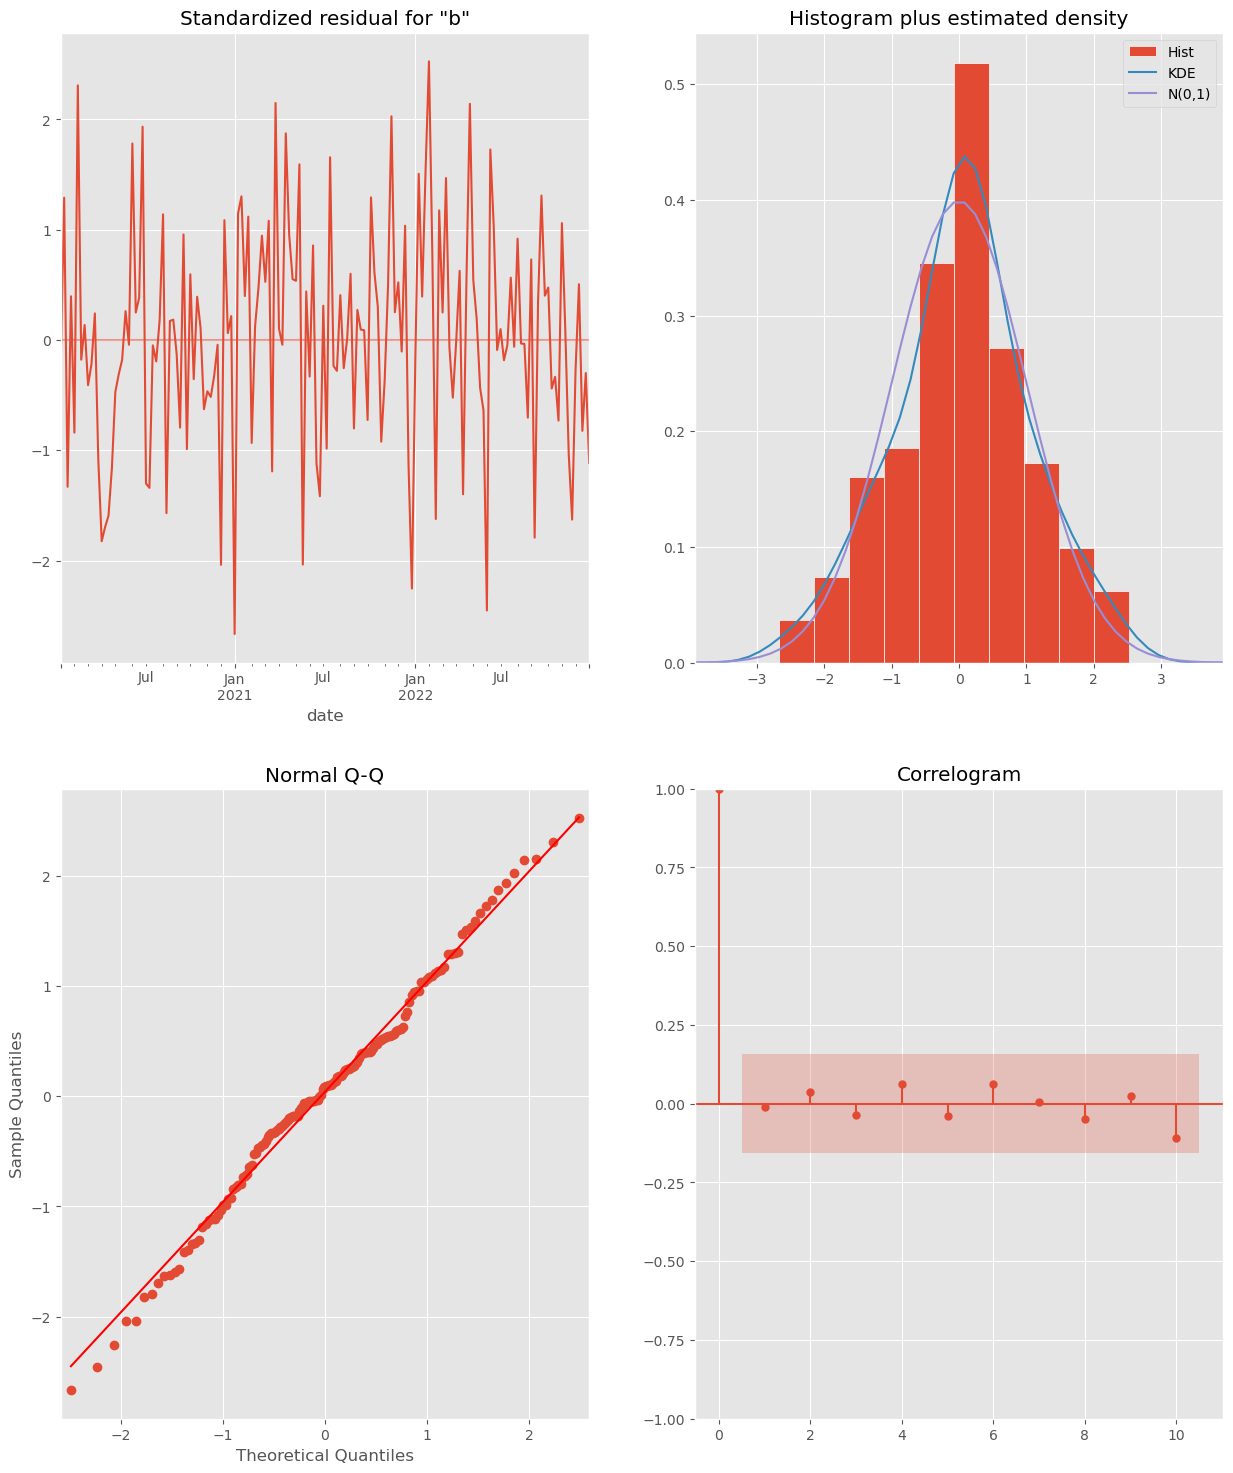

In [151]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [152]:
pred = output.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=True)
pred_conf = pred.conf_int()

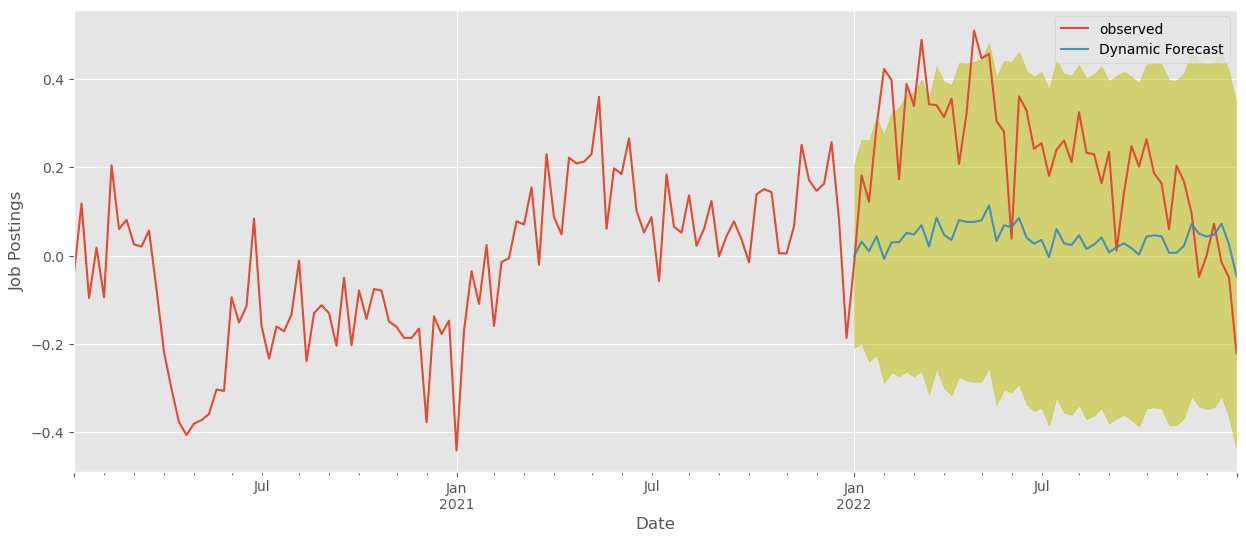

In [153]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [154]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.05


In [79]:
#jobs_forecasted[1] - jobs_truth[1]

In [80]:
# Get forecast 1yr ahead in future
prediction = output.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [544]:
#forecast = output.predict(start=df.shape[0], end=df.shape[0] + 8)
#forecast

In [81]:
prediction.predicted_mean[:10]

2023-01-06   -0.114719
2023-01-13   -0.055429
2023-01-20   -0.066422
2023-01-27   -0.015941
2023-02-03    0.023354
2023-02-10    0.021015
2023-02-17   -0.034971
2023-02-24    0.026671
2023-03-03    0.017052
2023-03-10    0.060688
Freq: W-FRI, Name: predicted_mean, dtype: float64

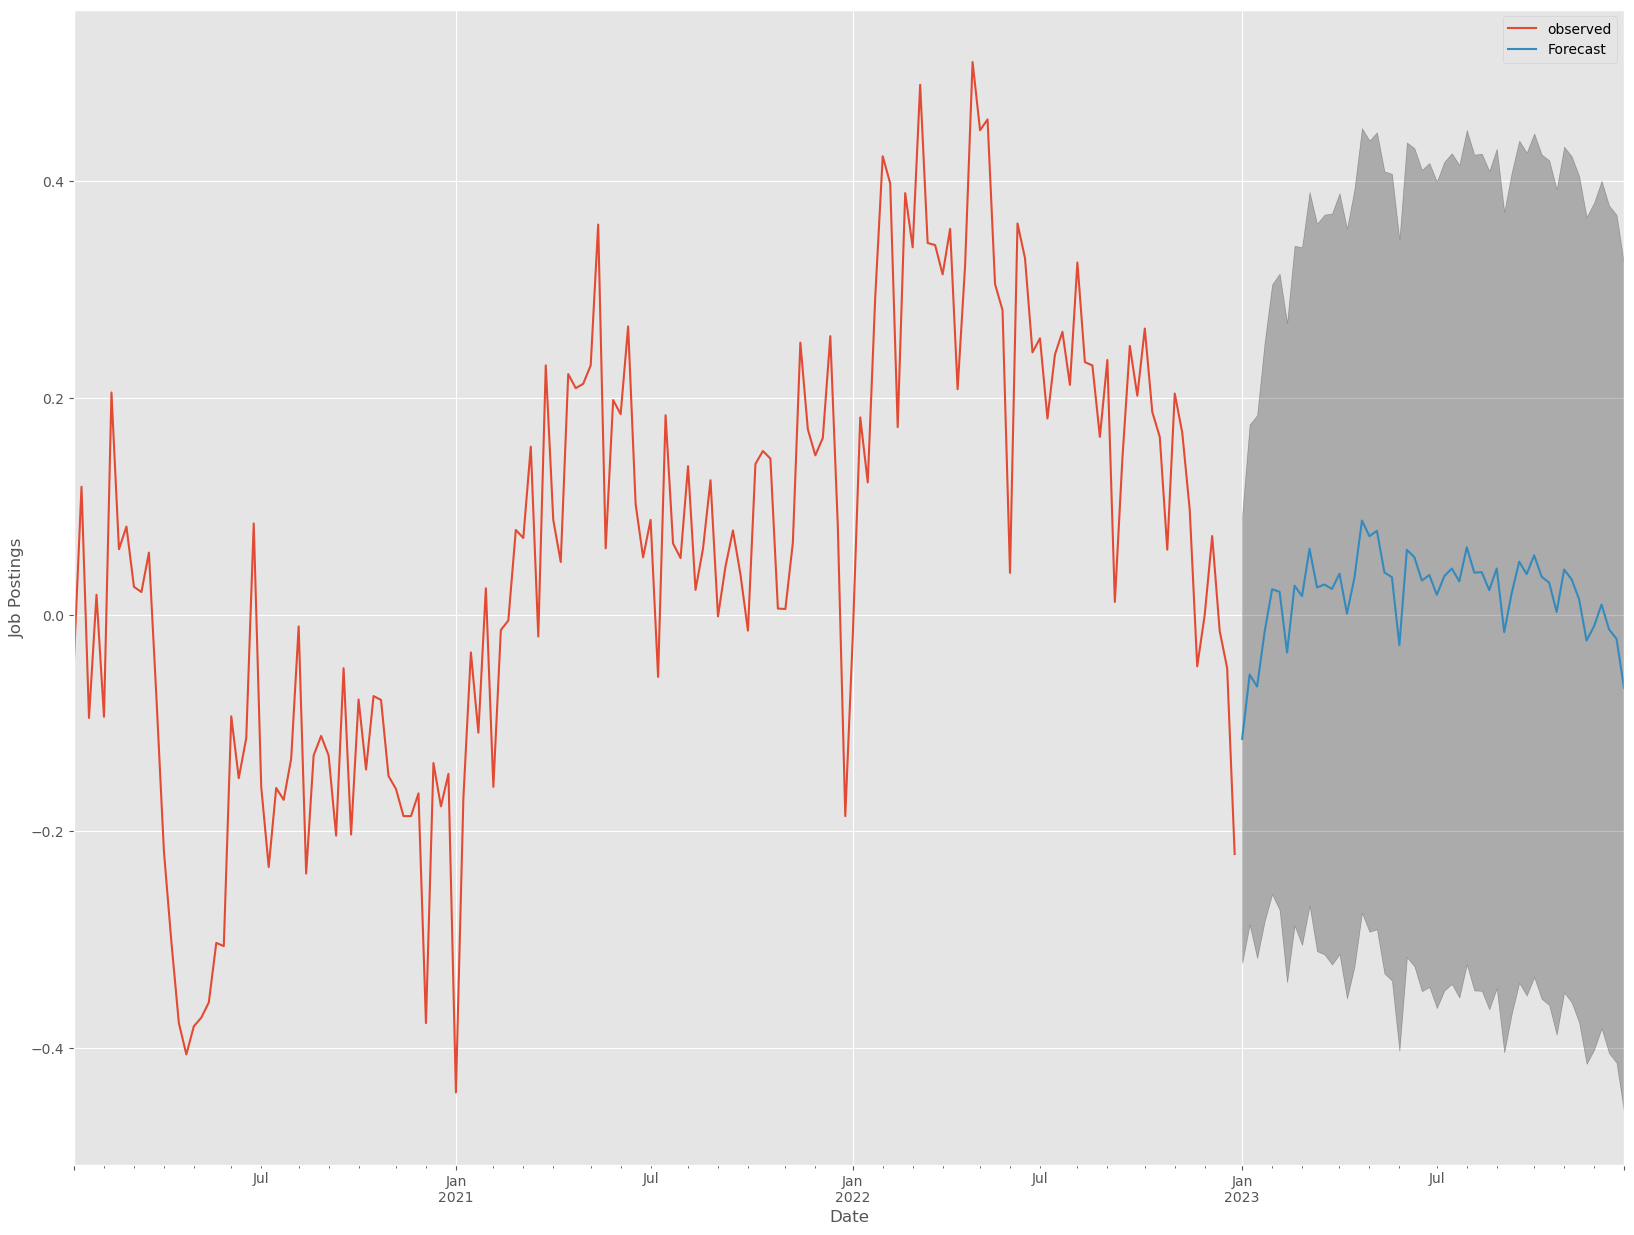

In [82]:
# Plot future predictions with confidence intervals
ax = df.plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')

plt.legend()
plt.show()